<a href="https://colab.research.google.com/github/jheancamargo/AI-Talks/blob/main/lstm_erica_funcional.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!apt-get update
!apt-get install -y graphviz libgraphviz-dev pkg-config
!pip install tabulate

Hit:1 http://archive.ubuntu.com/ubuntu jammy InRelease
Get:2 http://archive.ubuntu.com/ubuntu jammy-updates InRelease [128 kB]
Get:3 https://cloud.r-project.org/bin/linux/ubuntu jammy-cran40/ InRelease [3,632 B]
Get:4 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu2204/x86_64  InRelease [1,581 B]
Get:5 http://archive.ubuntu.com/ubuntu jammy-backports InRelease [127 kB]
Get:6 http://security.ubuntu.com/ubuntu jammy-security InRelease [129 kB]
Get:7 https://r2u.stat.illinois.edu/ubuntu jammy InRelease [6,555 B]
Get:8 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu2204/x86_64  Packages [1,607 kB]
Get:9 http://archive.ubuntu.com/ubuntu jammy-updates/universe amd64 Packages [1,543 kB]
Get:10 http://archive.ubuntu.com/ubuntu jammy-updates/main amd64 Packages [3,154 kB]
Get:11 https://r2u.stat.illinois.edu/ubuntu jammy/main all Packages [8,863 kB]
Hit:12 https://ppa.launchpadcontent.net/deadsnakes/ppa/ubuntu jammy InRelease
Get:13 https://r2u.stat.illinois.edu/

In [2]:
!pip install datasets
!pip install pygraphviz
!pip install torchexplorer

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 491.2/491.2 kB 9.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 8.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 183.9/183.9 kB 14.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 143.5/143.5 kB 11.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.8/194.8 kB 14.8 MB/s eta 0:00:00
  Attempting uninstall: fsspec
    Found existing installation: fsspec 2025.3.2
    Uninstalling fsspec-2025.3.2:
      Successfully uninstalled fsspec-2025.3.2
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
gcsfs 2025.3.2 requires fsspec==2025.3.2, but you have fsspec 2024.12.0 which is incompatible.
torch 2.6.0+cu124 requires nvidia-cublas-cu12==12.4.5.8; platform_system == "Linux" and platform_machine == "x86_64", but you have nvidia-cublas-cu12 12.5.3.2 which i

In [3]:
import gc
import os
import pickle
import requests
import pandas as pd
import numpy as np
import zipfile
from io import StringIO, BytesIO
from datasets import Dataset
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import seaborn as sns

# Configurar estilo dos plots
sns.set(style="whitegrid")

In [4]:
from datasets import load_dataset

dataset = load_dataset(
    "ealvaradob/phishing-dataset",
    "combined_full",
    download_mode="force_redownload",
    trust_remote_code=True
)

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


README.md:   0%|          | 0.00/6.75k [00:00<?, ?B/s]

phishing-dataset.py:   0%|          | 0.00/3.27k [00:00<?, ?B/s]

phishing-dataset.py:   0%|          | 0.00/3.27k [00:00<?, ?B/s]

README.md:   0%|          | 0.00/6.75k [00:00<?, ?B/s]

combined_full.json:   0%|          | 0.00/591M [00:00<?, ?B/s]

Generating train split: 0 examples [00:00, ? examples/s]

In [5]:
df = dataset['train'].to_pandas()
train, test = train_test_split(df, test_size=0.2, random_state=42)
train, test = Dataset.from_pandas(train, preserve_index=False), Dataset.from_pandas(test, preserve_index=False)

In [6]:
import requests
import pandas as pd
import io
import gzip

def get_phishtank_data():
    # Primeira tentativa: CSV "puro"
    csv_url = "http://data.phishtank.com/data/online-valid.csv"
    response = requests.get(csv_url)

    if response.status_code == 200:
        # Lê diretamente o CSV em memória
        phishing_csv = io.StringIO(response.text)
        phishing_df = pd.read_csv(phishing_csv)
        print("Download do PhishTank CSV realizado com sucesso.")
        return phishing_df
    else:
        print(f"Erro no download do CSV (Status Code {response.status_code}).")
        print("Tentando baixar o arquivo .gz...")

    # Segunda tentativa: CSV comprimido (.gz)
    gz_url = "http://data.phishtank.com/data/online-valid.csv.gz"
    gz_response = requests.get(gz_url)

    if gz_response.status_code == 200:
        # Abre o conteúdo via gzip e lê em pandas
        with gzip.open(io.BytesIO(gz_response.content), "rt") as f:
            phishing_df = pd.read_csv(f)
        print("Download do PhishTank .gz realizado com sucesso.")
        return phishing_df
    else:
        print(f"Erro no download do CSV .gz (Status Code {gz_response.status_code}).")
        print("Tentando baixar o arquivo .xml...")

    # Terceira tentativa: XML
    xml_url = "http://data.phishtank.com/data/online-valid.xml"
    xml_response = requests.get(xml_url)

    if xml_response.status_code == 200:
        # Tenta converter o XML em DataFrame (pandas >= 1.3.0 possui read_xml)
        try:
            phishing_df = pd.read_xml(xml_response.content)
            print("Download do PhishTank XML realizado com sucesso.")
            return phishing_df
        except Exception as e:
            print("Erro ao converter XML em DataFrame:", e)
            return pd.DataFrame()
    else:
        print(f"Erro no download do XML (Status Code {xml_response.status_code}).")
        print("Nenhum método de download funcionou.")
        return pd.DataFrame()

# Exemplo de uso:
phishing_df = get_phishtank_data()
print("Total de linhas carregadas:", len(phishing_df))

Erro no download do CSV (Status Code 404).
Tentando baixar o arquivo .gz...
Download do PhishTank .gz realizado com sucesso.
Total de linhas carregadas: 62520


In [7]:
if not phishing_df.empty:
    # Selecionar a coluna 'URL' e renomear para 'text'
    phishing_df = phishing_df[['url']].rename(columns={'url': 'text'})

    # Adicionar a coluna 'label' com valor 1 (Phishing)
    phishing_df['label'] = 1

    # Exibir as primeiras linhas
    print("Dataset do PhishTank processado:")
    display(phishing_df.head())

Dataset do PhishTank processado:


,text,label
0,https://ezpass.com-nlx.win/,1
1,https://ezpass.com-nqy.win/,1
2,https://ezpass.com-nvc.win/,1
3,https://ezpass.com-okm.win/,1
4,https://ezpass.com-omv.win/,1


In [8]:
# URL do arquivo ZIP do Alexa (ajuste se necessário)
alexa_zip_url = "https://github.com/PeterDaveHello/top-1m-domains/raw/master/backup/alexa.zip"

# Realizar o download do ZIP
response = requests.get(alexa_zip_url)

# Verificar se o download foi bem-sucedido
if response.status_code == 200:
    with zipfile.ZipFile(BytesIO(response.content)) as zip_ref:
        zip_ref.extractall("data/alexa")
    print("Download e descompactação do Alexa realizado com sucesso.")
else:
    print(f"Erro no download do Alexa: Status Code {response.status_code}")

Download e descompactação do Alexa realizado com sucesso.


In [9]:
# Caminho para o arquivo descompactado
alexa_csv_path = "data/alexa/top-1m.csv"  # Ajuste conforme o nome real do arquivo

# Verificar se o arquivo existe
if os.path.exists(alexa_csv_path):
    # Carregar o CSV sem header
    alexa_df = pd.read_csv(alexa_csv_path, header=None)

    # Selecionar a segunda coluna (domínio) e renomear para 'text'
    alexa_df = alexa_df.iloc[:, 1].to_frame(name='text')

    # Adicionar a coluna 'label' com valor 0 (Benign)
    alexa_df['label'] = 0

    print("Dataset do Alexa processado:")
    display(alexa_df.head())
else:
    print(f"Arquivo {alexa_csv_path} não encontrado.")
    alexa_df = pd.DataFrame()  # Criar DataFrame vazio para evitar erros posteriores

Dataset do Alexa processado:


,text,label
0,google.com,0
1,youtube.com,0
2,baidu.com,0
3,facebook.com,0
4,bilibili.com,0


In [10]:
# Concatenar todos os DataFrames
combined_df = pd.concat([df, phishing_df, alexa_df], ignore_index=True)

print(f"Total de registros antes de remover duplicatas: {combined_df.shape[0]}")

Total de registros antes de remover duplicatas: 1722045


In [11]:
# Remover duplicatas com base na coluna 'text'
combined_df.drop_duplicates(subset=['text'], inplace=True)

print(f"Total de registros após remover duplicatas: {combined_df.shape[0]}")

Total de registros após remover duplicatas: 1707021


Distribuição das classes:
label
0    1245312
1     461709
Name: count, dtype: int64


<ipython-input-12-ed392c7fde32>:8: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=class_counts.index, y=class_counts.values, palette='viridis')


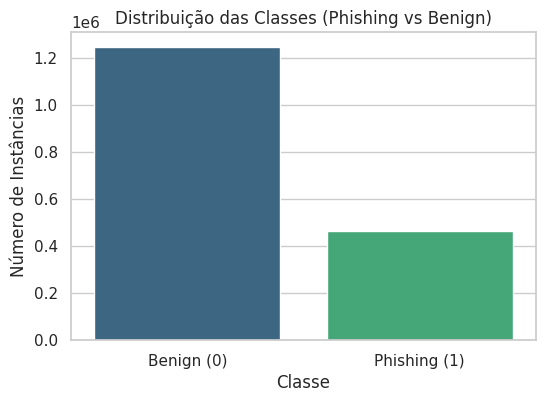

In [12]:
# Contar a distribuição das classes
class_counts = combined_df['label'].value_counts()
print("Distribuição das classes:")
print(class_counts)

# Plotar a distribuição das classes
plt.figure(figsize=(6,4))
sns.barplot(x=class_counts.index, y=class_counts.values, palette='viridis')
plt.title('Distribuição das Classes (Phishing vs Benign)')
plt.xlabel('Classe')
plt.ylabel('Número de Instâncias')
plt.xticks(ticks=[0,1], labels=['Benign (0)', 'Phishing (1)'])
plt.show()

Distribuição das classes após balanceamento:
label
1    461709
0    461709
Name: count, dtype: int64


<ipython-input-13-66a08952a62a>:27: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=balanced_class_counts.index, y=balanced_class_counts.values, palette='viridis')


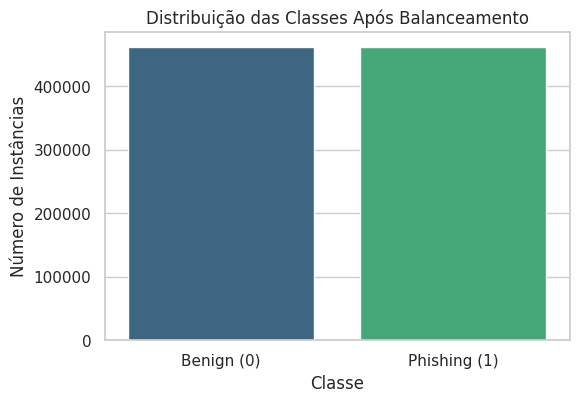

In [13]:
from sklearn.utils import resample

# Separar as classes
df_phishing = combined_df[combined_df['label'] == 1]
df_benign = combined_df[combined_df['label'] == 0]

# Definir o tamanho mínimo entre as duas classes
min_count = min(len(df_phishing), len(df_benign))

# Aplicar undersampling nas classes majoritárias
df_phishing_balanced = resample(df_phishing, replace=False, n_samples=min_count, random_state=42)
df_benign_balanced = resample(df_benign, replace=False, n_samples=min_count, random_state=42)

# Combinar as classes balanceadas
df_balanced = pd.concat([df_phishing_balanced, df_benign_balanced])

# Embaralhar o DataFrame balanceado
df_balanced = df_balanced.sample(frac=1, random_state=42).reset_index(drop=True)

# Verificar a nova distribuição das classes
balanced_class_counts = df_balanced['label'].value_counts()
print("Distribuição das classes após balanceamento:")
print(balanced_class_counts)

# Plotar a nova distribuição
plt.figure(figsize=(6,4))
sns.barplot(x=balanced_class_counts.index, y=balanced_class_counts.values, palette='viridis')
plt.title('Distribuição das Classes Após Balanceamento')
plt.xlabel('Classe')
plt.ylabel('Número de Instâncias')
plt.xticks(ticks=[0,1], labels=['Benign (0)', 'Phishing (1)'])
plt.show()

In [14]:
# Converter para Dataset do Hugging Face
final_dataset = Dataset.from_pandas(df_balanced, preserve_index=False)

# Dividir novamente em treino e teste (se necessário)
train_final, test_final = train_test_split(df_balanced, test_size=0.2, random_state=42)
train_final = Dataset.from_pandas(train_final, preserve_index=False)
test_final = Dataset.from_pandas(test_final, preserve_index=False)

print("Dataset final preparado para treinamento.")

Dataset final preparado para treinamento.


In [15]:
final_dataset

Dataset({
    features: ['text', 'label'],
    num_rows: 923418
})

In [16]:
# Salvar os datasets
final_dataset.save_to_disk("data/phishing_dataset/final_dataset")
train_final.save_to_disk("data/phishing_dataset/train_final")
test_final.save_to_disk("data/phishing_dataset/test_final")

# Também é possível salvar como CSV
df_balanced.to_csv("data/phishing_dataset/final_dataset.csv", index=False)

Saving the dataset (0/1 shards):   0%|          | 0/923418 [00:00<?, ? examples/s]

Saving the dataset (0/1 shards):   0%|          | 0/738734 [00:00<?, ? examples/s]

Saving the dataset (0/1 shards):   0%|          | 0/184684 [00:00<?, ? examples/s]

# Documentação de Engenharia de Software para Carregamento e Preparação do Dataset de Phishing

## 1. Introdução

Este documento descreve a **fase de carregamento e preparação de dados** para um **modelo de deep learning** focado na **detecção de phishing**. A implementação utiliza **Python** no ambiente **Google Colab**, integrando bibliotecas como **TensorFlow/Keras**, **PyTorch**, **Torchexplorer**, e **Hugging Face Datasets**. O objetivo é preparar um pipeline robusto para processar dados de phishing provenientes de múltiplas fontes, garantindo a consistência e a eficácia do modelo treinado.

### Objetivos do Projeto

- **Carregar e preparar** um conjunto de dados abrangente de phishing para treinamento e avaliação do modelo.
- **Integrar** ferramentas de visualização e exploração de modelos, como **Torchexplorer**.
- **Documentar** as premissas, justificativas técnicas e a arquitetura do processo de preparação de dados.
- **Contribuição Acadêmica**: Demonstrar a eficácia de um modelo de deep learning para detecção de phishing utilizando um dataset diversificado e bem estruturado.

---

## 2. Escopo e Requisitos

### Requisitos Funcionais

1. **RF01** – Atualizar os repositórios do sistema e instalar dependências necessárias (`graphviz`, `libgraphviz-dev`, `pkg-config`).
2. **RF02** – Instalar bibliotecas Python essenciais para o projeto (`datasets`, `pygraphviz`, `torchexplorer`).
3. **RF03** – Carregar o dataset de phishing utilizando a biblioteca **Hugging Face Datasets**.
4. **RF04** – Realizar a divisão do dataset em conjuntos de treinamento e teste de forma balanceada.
5. **RF05** – Garantir que todos os dados estejam limpos, sem valores nulos, duplicados ou vazios, e que o balanceamento de classes seja mantido.

### Requisitos Não Funcionais

1. **RNF01** – Utilizar um ambiente **Google Colab** para facilitar a execução e colaboração.
2. **RNF02** – Assegurar que a instalação de dependências seja automatizada e reproduzível.
3. **RNF03** – Manter o código modular e bem documentado para facilitar futuras manutenções e expansões.

### Restrições

- O dataset deve seguir a estrutura especificada: duas colunas (`text` e `label`).
- A implementação deve ser compatível com o formato do **Hugging Face Datasets**.
- O ambiente de execução (Google Colab) deve suportar as instalações e dependências requeridas.

---

## 3. Arquitetura e Fluxo

A solução está organizada em etapas principais que gerenciam a atualização do sistema, instalação de pacotes, carregamento do dataset, e preparação para o treinamento do modelo.

### Fluxo Esquemático em Mermaid

A seguir, um diagrama que ilustra o fluxo geral do processo de carregamento e preparação dos dados.

```mermaid
flowchart LR
    A[Início] --> B[Atualizar Repositórios e Instalar Dependências]
    B --> C[Instalar Bibliotecas Python]
    C --> D[Carregar Dataset de Phishing]
    D --> E[Dividir Dataset em Treino e Teste]
    E --> F[Pré-processamento dos Dados]
    F --> G[Salvar Datasets Preparados]
    G --> H[Fim da Preparação de Dados]

```

# Justificativas Técnicas

## 4.1. Atualização de Repositórios e Instalação de Dependências

* **Motivação**: Algumas bibliotecas Python, como **pygraphviz**, requerem dependências de sistema específicas (graphviz, libgraphviz-dev, pkg-config) para serem compiladas corretamente.

* **Implementação**:
```
bash
Copy code
!apt-get update
!apt-get install -y graphviz libgraphviz-dev pkg-config
```

* **Justificativa**: Garantir que todas as dependências de sistema estejam presentes para evitar erros durante a instalação de pacotes Python que dependem de bibliotecas externas.

## 4.2. Instalação de Bibliotecas Python

* **Pacotes Instalados**:

  * **datasets**: Facilita o carregamento e manipulação de datasets de diversas fontes.

  * **pygraphviz**: Utilizado para visualização de grafos, essencial para ferramentas como Torchexplorer.

  * **torchexplorer**: Ferramenta para exploração e visualização de modelos PyTorch.

* **Implementação**:

```
bash
!pip install datasets
!pip install pygraphviz
!pip install torchexplorer
```
* **Justificativa**: Essas bibliotecas são fundamentais para o carregamento eficiente dos dados e para a exploração aprofundada do modelo durante o desenvolvimento.

# 4.3. Carregamento e Preparação do Dataset

* **Fonte do Dataset**: Phishing Dataset compilado a partir de múltiplas fontes, garantindo diversidade e balanceamento entre classes.

* **Estrutura do Dataset**:

  * **Colunas**: text (contendo URLs, SMS, Emails, HTML) e label (0 = Benign, 1 = Phishing).

  * **Características**: Dados pré-processados para eliminar valores nulos, duplicados e balanceamento de classes para evitar vieses.

* **Implementação**:
```
from datasets import load_dataset
dataset = load_dataset(
    "ealvaradob/phishing-dataset",
    "combined_full",
    download_mode="force_redownload",
    trust_remote_code=True
)
```

* **Justificativa**: Utilizar um dataset consolidado e diversificado é crucial para treinar um modelo robusto que generalize bem em diferentes tipos de phishing.

# 4.4. Divisão do Dataset em Treino e Teste

* **Implementação**:

```
from datasets import Dataset
from sklearn.model_selection import train_test_split

df = dataset['train'].to_pandas()
train, test = train_test_split(df, test_size=0.2, random_state=42)
train, test = Dataset.from_pandas(train, preserve_index=False), Dataset.from_pandas(test, preserve_index=False)
```

* **Justificativa**: Dividir o dataset em conjuntos de treinamento e teste permite avaliar o desempenho do modelo de forma imparcial, assegurando que ele generalize bem para dados não vistos.

# 4.5. Persistência do Pipeline de Preparação

* **Motivação**: Garantir que o processo de contagem de caracteres especiais (top_chars) seja consistente entre as fases de treinamento e inferência.

* **Implementação**: Salvar objetos tokenizer e top_chars usando Pickle para reutilização futura.

* Exemplo:

```
import pickle

with open("tokenizer.pkl", "wb") as f:
    pickle.dump(tokenizer, f)

with open("top_chars.pkl", "wb") as f:
    pickle.dump(top_chars, f)
```

* **Justificativa**: Preservar a ordem e a seleção de caracteres especiais evita inconsistências que poderiam comprometer a eficácia do modelo durante a inferência.

# 5. Classes e Argumentos Utilizados
Embora nesta etapa não sejam definidas classes personalizadas, a seguir estão as principais funções e seus argumentos utilizados no processo de carregamento e preparação de dados.

## 5.1. Função load_dataset
* Objetivo: Carregar o dataset de phishing a partir do Hugging Face Datasets.

* Argumentos:

  * "ealvaradob/phishing-dataset": Nome do dataset.
  * "combined_full": Configuração específica do dataset (pode ser "combined_reduced" conforme necessidade).
  * download_mode="force_redownload": Força o re-download do dataset.
trust_remote_code=True: Confia no código remoto para carregar o dataset.

* Retorno:
  * Objeto DatasetDict contendo os splits do dataset.

##5.2. Função train_test_split

* Objetivo: Dividir o DataFrame em conjuntos de treinamento e teste.

* Argumentos:
  * df: DataFrame contendo os dados.
  * test_size=0.2: Proporção do dataset a ser usada como teste.
  * random_state=42: Semente para reprodução dos resultados.

* Retorno:
  * Dois DataFrames: train e test.

##5.3. Função Dataset.from_pandas

* Objetivo: Converter DataFrames pandas para objetos Dataset do Hugging Face.

* Argumentos:
  * train ou test: DataFrame a ser convertido.
  * preserve_index=False: Não preservar o índice original do DataFrame.
* Retorno:
  * Objetos Dataset prontos para serem utilizados no treinamento do modelo.

## 6. Implementação e Organização de Arquivos

* Estrutura do Projeto
A organização dos arquivos facilita a manutenção e a escalabilidade do projeto, além de garantir que todas as dependências e artefatos estejam corretamente versionados e acessíveis.

```
projeto_phishing/
├── data/
│   └── phishing_dataset/
│       ├── combined_full/
│       ├── combined_reduced/
│       ├── mail_dataset.csv
│       ├── sms_dataset.csv
│       ├── url_dataset.csv
│       └── website_dataset.csv
├── models/
│   ├── best_model_checkpoint.keras
│   ├── model_final.keras
│   ├── tokenizer.pkl
│   └── top_chars.pkl
├── notebooks/
│   └── treinamento.ipynb
├── src/
│   ├── pipeline.py
│   ├── model.py
│   └── predict.py
├── requirements.txt
└── README.md
```

* Descrição dos Diretórios e Arquivos
  * data/: Contém os datasets de phishing organizados por tipo e configuração.
    * phishing_dataset/: Subdiretório específico para os datasets carregados do Hugging Face.

* models/: Armazena os modelos treinados e artefatos associados.
  * best_model_checkpoint.keras: Checkpoint do melhor modelo baseado no val_loss.
  * model_final.keras: Modelo final treinado.
  * tokenizer.pkl: Objeto Tokenizer salvo para reutilização.
  * top_chars.pkl: Lista de caracteres especiais utilizados, salva para garantir a consistência na contagem durante a inferência.

* notebooks/: Contém os notebooks Jupyter utilizados para treinamento e análise exploratória.
  * treinamento.ipynb: Notebook principal para treinamento do modelo.
* src/: Diretório para scripts Python que implementam funções e classes.
  * pipeline.py: Implementação do pipeline de pré-processamento.
  * model.py: Definição da arquitetura do modelo.
  * predict.py: Funções para realizar predições com o modelo treinado.
* requirements.txt: Lista de dependências Python necessárias para o projeto.
* README.md: Documentação geral do projeto.

# Implementação no Google Colab
No Google Colab, a organização de arquivos pode seguir uma estrutura similar, utilizando diretórios virtuais ou montando o Google Drive para persistência.

Exemplo de Estrutura no Colab:

```
# Criação de diretórios
!mkdir -p data/phishing_dataset
!mkdir -p models
!mkdir -p src
!mkdir -p notebooks
```

**Documentação de Engenharia de Software do Modelo de Predição de Phishing utilizando arquitetura de Deep Learning**

**1. Introdução**

* Este documento descreve um **pipeline de classificação binária** focado na **detecção de URLs de phishing** utilizando um modelo **multi-input** (texto tokenizado + contagem de caracteres especiais). O desenvolvimento foi realizado em **Python** com **TensorFlow/Keras**.

**Objetivos do Projeto**

* **Criar, treinar e aplicar** um modelo de deep learning para identificar URLs potencialmente maliciosas.

* **Demonstrar boas práticas** de engenharia de software, incluindo organização do código, salvamento de artefatos e reutilização de funções.

* **Documentar** o processo de forma clara e padronizada para fins acadêmicos e/ou industriais.



---



**2. Escopo e Requisitos**

**Requisitos Funcionais**

  1. RF01 - Ler um conjunto de dados contendo colunas: [`"text", "label"`].
  2. RF02 - Gerar um **pipeline** de pré-processamento, tokenização, contagem de caracteres especiais e criação de um modelo multi-input de rede neural.
  3. RF03 - Treinar o modelo (validando parte dos dados), avaliar a performance e salvar o artefato final (modelo e metadados) para uso futuro.
  4. RF04 - Permitir a **predição** de novas URLs, gerando a probabilidade e a classe final (phishing ou não).


**Requisitos Não Funcionais**

  1. RNF01 - Utilizar **TensorFlow/Keras** como framework principal de deep learning.
  2. RNF02 - Código em **Python 3** organizado em funções claras (e.g., train_and_evaluate, predict_url, etc.).
  3. RNF03 - Ser modular, permitindo a fácil substituição do método de contagem de caracteres especiais, caso necessário.

**Restrições**

* O dataset de entrada deve ter **colunas específicas** (`"text"` e `"label"`) para o funcionamento do pipeline.

* O código está focado em classificação **binária** (0/1). Adaptações para multi-classes exigiriam mudanças na camada de saída.

---

**3. Arquitetura e Fluxo**

* A solução está organizada em funções principais que gerenciam diferentes etapas do processo:

* 3.1. `create_pipeline(df, ...)`

    * Realiza limpeza (`preprocess_url`), detecção de caracteres especiais, tokenização (char-level) e geração de features numéricas (contagem de caracteres).

  * Retorna:
    * `urls_padded` (matriz de tokens)
    * `numeric_features` (contagens)
    * `labels` (vetor 0/1)
    * `tokenizer` (objeto de tokenização)
    * `top_chars` (lista de caracteres especiais utilizados)

* 3.2. `create_model(...)`

  * Constrói um modelo Keras multi-input (entrada de texto tokenizado + entrada de features numéricas) para classificação binária.

* 3.3. `train_and_evaluate(df, ...)`

  * Executa a pipeline (`create_pipeline`), gera e treina o modelo (`create_model`), avalia métricas e salva artefatos:

    * Modelo em formato `.keras`

    * `tokenizer.pkl` e `top_chars.pkl` (para reutilização no momento da inferência)

* 3.4. `predict_url(model, tokenizer, top_chars, new_url, ...)`

  * Pré-processa uma URL, gera features textuais (tokenização + pad) e numéricas (contagem de caracteres) e retorna a probabilidade de phishing e a classe (0/1).

* 3.5. `explain_with_shap(...)` (opcional)

  * Usa **SHAP** (KernelExplainer) para explicar as predições do modelo, selecionando amostras de background para o SHAP.

---

**4. Justificativas Técnicas**

* 4.1. Tokenização Char-Level

  **Motivação**: Capturar detalhes das strings de URL, já que domínios e caminhos podem conter subdomínios, caracteres especiais, etc.

  **Implementação**: Utilização do `Tokenizer` do Keras com `char_level=True` para simplificar o processo.

* 4.2. Contagem de Caracteres Especiais

  * **Motivação**: Criar features numéricas que indicam a frequência de certos símbolos (`/, ?, =, @, &, ...`), que são relevantes em URLs suspeitas.

  * **Implementação**: Utilização de `top_chars` para manter a **consistência** entre treino e inferência (ordem e conjunto de caracteres).

* 4.3. Modelo Multi-Input

  * **Branch 1 (Texto)**:

    * **Camadas**: Embedding → Conv1D → GlobalMaxPooling → LSTM → RNN.
    
    * **Justificativa**: Capturar padrões de sequência curtos e reter contexto sequencial.

  * **Branch 2 (Numérico)**:

    * **Camadas**: Dense + Dropout + BatchNormalization.

    * **Justificativa**: Processar as contagens de caracteres especiais de forma eficaz.

  * **Combinação**: Concatenação das duas ramificações seguida por camadas densas para a **classificação binária**.

* 4.4. Formato de Salvamento `.keras`

  * **Motivação**: A partir das versões recentes do Keras (2.13+), o formato `.keras` é recomendado para armazenar modelos em SavedModel, substituindo o antigo `.h5`.

  * **Implementação**: Checkpoints intermediários são salvos em `best_model_checkpoint.keras`, e o modelo final em `model_final.keras`.

* 4.5. Persistência de tokenizer e top_chars
  * **Motivação**: Garantir que a lista de caracteres especiais (top_chars) e o tokenizer sejam **reutilizados** na fase de inferência, mantendo a consistência do pipeline de pré-processamento.

  * **Implementação**: Salvamento em arquivos **Pickle** (`tokenizer.pkl e top_chars.pkl`).

  ---

**5. Classes e Argumentos Utilizados**

* 5.1. Função `create_pipeline`

  * **Objetivo**: Realizar o pré-processamento dos dados, incluindo limpeza, detecção e contagem de caracteres especiais, tokenização e geração de features numéricas.

  * **Argumentos**:

    * `df`: DataFrame de entrada com colunas [`"text"`, `"label"`].

    * `maxlen`: Tamanho máximo de cada URL tokenizada (default: 200).

    * `vocab_size`: Tamanho do vocabulário de caracteres (default: 1000).

    * `max_special_chars`: Limite de caracteres especiais a considerar (default: 50).

  * **Retorno**:

    * `urls_padded`: Matriz de tokens (numpy array, int32).

    * `numeric_features`: Matriz de contagens de caracteres especiais (numpy array, float32).

    * `labels`: Vetor de labels binários (numpy array, float32).

    * `tokenizer`: Objeto Tokenizer treinado.

    * `top_chars`: Lista dos caracteres especiais considerados.

* 5.2. Função `create_model`

  * **Objetivo**: Construir a arquitetura do modelo multi-input utilizando Keras.

  * **Argumentos**:

    * `vocab_size`: Tamanho do vocabulário de caracteres.

    * `maxlen`: Tamanho máximo das sequências tokenizadas.

    * `numeric_dim`: Dimensão das features numéricas (número de caracteres especiais considerados).

    * `l2_reg`: Fator de regularização L2 (default: 0.01).

  * **Retorno**:

    * `model`: Objeto `tensorflow.keras.models.Model` compilado.

* 5.3. Função `train_and_evaluate`

  * **Objetivo**: Orquestrar o processo de pré-processamento, treinamento do modelo, avaliação e salvamento dos artefatos.

  * **Argumentos**:

    * `df`: DataFrame de entrada.

    * `maxlen`: Tamanho máximo das sequências tokenizadas.

    * `vocab_size`: Tamanho do vocabulário de caracteres.

    * `max_special_chars`: Limite de caracteres especiais a considerar.

    * `epochs`: Número de épocas de treinamento (default: 5).

    * `batch_size`: Tamanho do lote de treinamento (default: 128).

  * **Processos**:

    1. Chama `create_pipeline` para gerar as features.
    2. Cria o modelo com `create_model`.
    3. Configura callbacks de TensorBoard e ModelCheckpoint.
    4. Treina o modelo.
    5. Avalia o modelo e imprime métricas.
    6. Salva o modelo final em `.keras`.
    7. Salva `tokenizer.pkl` e `top_chars.pkl`.

  * Retorno:

    * (`model`, `tokenizer`, `top_chars`)

* 5.4. Função `predict_url`

  * **Objetivo**: Realizar a predição de uma nova URL utilizando o modelo treinado.

  * **Argumentos**:

    * `model`: Modelo treinado.

    * `tokenizer`: Objeto Tokenizer treinado.

    * `top_chars`: Lista de caracteres especiais utilizados.

    * `new_url`: URL a ser classificada.

    * `maxlen`: Tamanho máximo das sequências tokenizadas (default: 200).

  * **Processos**:

    1. Pré-processa a URL (lowercase e strip).
    2. Conta os caracteres especiais na ordem exata de `top_chars`.
    3. Tokeniza e aplica padding na sequência.
    4. Faz a predição com o modelo.

  * **Retorno**:

    * `prob`: Probabilidade de phishing (float).
    * `predicted_class`: Classe prevista (0 = não phishing, 1 = phishing).

* 5.5. Função explain_with_shap

  * **Objetivo**: Explicar as predições do modelo utilizando SHAP (KernelExplainer).

  * **Argumentos**:

    * `model`: Modelo treinado.

    * `urls_padded`: Matriz de tokens (numpy array).

    * `numeric_features`: Matriz de contagens de caracteres especiais (numpy array).

    * `sample_size`: Número de amostras para o background do SHAP (default: 100).

  * Processos:
    1. Seleciona amostras de background.
    2. Configura o `KernelExplainer` com os dados de background.
    3. Calcula os valores SHAP para as amostras selecionadas.

  * Retorno:
    * `explainer`: Objeto SHAP explainer.

    * `shap_values`: Valores SHAP calculados.

---

6. **Implementação e Organização de Arquivos**

* **Artefatos Salvos**

  * `model_final.keras`: Arquivo final do modelo (arquitetura + pesos).

  * `best_model_checkpoint.keras`: Arquivo de checkpoint com o melhor `val_loss`.

  * `tokenizer.pkl`: Objeto Tokenizer salvo para reutilização.

  * `top_chars.pkl`: Lista de caracteres especiais utilizados, salva para garantir a consistência na contagem durante a inferência.

* **Código Principal**

  * **Funções Principais**:

    * `train_and_evaluate(df, ...)`: Ponto de entrada para treinamento.

    * `predict_url(model, tokenizer, top_chars, "nova_url")`: Ponto de entrada para predição isolada.

---

7. **Conclusão**

Este documento apresenta a **documentação de engenharia de software** para o projeto de detecção de phishing utilizando um modelo multi-input em **TensorFlow/Keras**. A solução abrange:

* **Pipeline** de pré-processamento (char-level + contagem de caracteres especiais).

* **Modelo** com duas ramificações (texto e features numéricas), culminando na **classificação binária**.

* **Persistência** dos artefatos (modelo `.keras`, `tokenizer.pkl`, `top_chars.pkl`).

* **Predição e explicabilidade** (via SHAP).

Dessa forma, assegura-se a **consistência** do pipeline entre treino e inferência, demonstrando práticas sólidas de engenharia de software para um projeto de conclusão de mestrado.

**Observação**: Em ambientes de produção, recomenda-se também um pipeline robusto de logging, testes unitários (e.g., PyTest) e CI/CD, bem como verificações de segurança no manuseio de URLs maliciosas. Contudo, para fins de demonstração acadêmica, a arquitetura aqui descrita atende ao escopo definido.

In [17]:
# -------------------------------------------------------------
# 0. IMPORTAÇÕES
# -------------------------------------------------------------

# 0.1. Importações da Biblioteca Padrão
import gc
import os
import pickle
import re
from io import StringIO
import multiprocessing

# 0.2. Importações de Terceiros
import pandas as pd
import numpy as np
import tensorflow as tf
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras import regularizers
from tensorflow.keras.layers import (
    Input, Embedding, Conv1D, LSTM, SimpleRNN, Dense, Dropout,
    GlobalMaxPooling1D, BatchNormalization, Reshape, concatenate
)
from tensorflow.keras.models import Model, load_model
from tensorflow.keras.callbacks import (
    TensorBoard, ModelCheckpoint, EarlyStopping, ReduceLROnPlateau
)
from sklearn.metrics import (
    precision_score,
    recall_score,
    f1_score,
    classification_report,
    confusion_matrix,
    roc_auc_score,
    matthews_corrcoef,
    cohen_kappa_score,
    roc_curve
)
from sklearn.model_selection import StratifiedKFold
from tabulate import tabulate  # Necessário para criar tabelas formatadas
from joblib import Parallel, delayed

# 0.3. Importações de Visualização
import matplotlib.pyplot as plt
import seaborn as sns
sns.set(style="whitegrid")

# -------------------------------------------------------------
# 1. FUNÇÕES AUXILIARES
# -------------------------------------------------------------

def preprocess_url(url):
    """
    Preprocessa a URL: converte para minúsculas e remove espaços em branco.

    Args:
        url (str): URL a ser pré-processada.

    Returns:
        str: URL pré-processada.
    """
    return url.lower().strip()

def normalize_domain(url):
    """
    Normaliza a URL para começar com 'http://www.' ou 'https://www.' se não iniciar com esses prefixos.

    Args:
        url (str): URL a ser normalizada.

    Returns:
        str: URL normalizada.
    """
    if not url.startswith("http://www.") and not url.startswith("https://www."):
        if url.startswith("http://"):
            url = url.replace("http://", "http://www.")
        elif url.startswith("https://"):
            url = url.replace("https://", "https://www.")
        else:
            url = "https://www." + url + "/"
    return url

def count_characters(text, char):
    """
    Conta a ocorrência de um caractere específico em um texto.

    Args:
        text (str): Texto onde o caractere será contado.
        char (str): Caractere a ser contado.

    Returns:
        int: Número de ocorrências do caractere no texto.
    """
    return text.count(char)

# -------------------------------------------------------------
# 2. PIPELINE DE PRÉ-PROCESSAMENTO COM COMPUTAÇÃO PARALLELA
# -------------------------------------------------------------
def create_pipeline(df, maxlen=200, vocab_size=1000, max_special_chars=50, tokenizer=None, top_chars=None, n_jobs=-1):
    """
    Processa o DataFrame para gerar features tokenizadas e numéricas, aplicando normalização nas URLs.
    Utiliza computação paralela para acelerar o pré-processamento.

    Args:
        df (pd.DataFrame): DataFrame contendo as colunas 'text' e 'label'.
        maxlen (int): Tamanho máximo das sequências tokenizadas.
        vocab_size (int): Tamanho do vocabulário de caracteres.
        max_special_chars (int): Número máximo de caracteres especiais a considerar.
        tokenizer (Tokenizer, optional): Tokenizer já treinado. Se None, um novo será criado.
        top_chars (list, optional): Lista de caracteres especiais a considerar. Se None, será selecionado.
        n_jobs (int): Número de jobs para paralelização. -1 usa todos os processadores.

    Returns:
        tuple: (urls_padded, numeric_features, labels, tokenizer, top_chars)
    """
    # 1) Converter label para int8
    df["label"] = df["label"].astype(np.int8)
    labels = df["label"].values.astype(np.float32)
    del df["label"]
    gc.collect()

    # 2) Pre-processar 'text' com normalização utilizando Parallel
    def process_text(url):
        return normalize_domain(preprocess_url(url))

    df["text_cleaned"] = Parallel(n_jobs=n_jobs)(delayed(process_text)(url) for url in df["text"])
    del df["text"]
    gc.collect()

    # 3) Detectar caracteres especiais
    if top_chars is None:
        all_special_chars = set()
        for txt in df["text_cleaned"]:
            for ch in txt:
                if not ch.isalnum() and not ch.isspace():
                    all_special_chars.add(ch)
        all_special_chars = sorted(all_special_chars)

        # Limitar a max_special_chars, se necessário
        if len(all_special_chars) > max_special_chars:
            freq_dict = {}
            for ch in all_special_chars:
                freq_dict[ch] = df["text_cleaned"].apply(lambda x: x.count(ch)).sum()
            sorted_by_freq = sorted(freq_dict.items(), key=lambda x: x[1], reverse=True)
            top_chars = [item[0] for item in sorted_by_freq[:max_special_chars]]
        else:
            top_chars = all_special_chars
    else:
        top_chars = top_chars

    # 4) Criar colunas de contagem utilizando Parallel
    def count_char(text, ch):
        return count_characters(text, ch)

    for ch in top_chars:
        col_name = f"count_char_{ord(ch)}"
        df[col_name] = Parallel(n_jobs=n_jobs)(
            delayed(count_char)(text, ch) for text in df["text_cleaned"]
        )
        df[col_name] = df[col_name].astype(np.int16)

    # 5) Tokenizar (char-level)
    texts_cleaned = df["text_cleaned"].tolist()
    if tokenizer is None:
        tokenizer = Tokenizer(num_words=vocab_size, char_level=True, oov_token="<OOV>")
        tokenizer.fit_on_texts(texts_cleaned)
    sequences = tokenizer.texts_to_sequences(texts_cleaned)

    # pad_sequences
    urls_padded = pad_sequences(
        sequences, maxlen=maxlen, padding='post', truncating='post', dtype='int16'
    ).astype(np.int32)

    # Remover coluna text_cleaned
    del df["text_cleaned"]
    gc.collect()

    # 6) Extrair features numéricas
    count_columns = [col for col in df.columns if col.startswith("count_char_")]
    numeric_features = df[count_columns].astype(np.float32).values

    for col in count_columns:
        del df[col]
    gc.collect()

    del df
    gc.collect()

    return urls_padded, numeric_features, labels, tokenizer, top_chars

# -------------------------------------------------------------
# 3. CRIAÇÃO DO MODELO COM LEARNING RATE SCHEDULER
# -------------------------------------------------------------
def create_cnn_model(vocab_size, maxlen, numeric_dim, l2_reg=0.01):
    """
    Modelo simples de CNN.
    """
    # Input para texto
    text_input = Input(shape=(maxlen,), name='text_input')
    x = Embedding(input_dim=vocab_size + 1, output_dim=64)(text_input)
    x = Conv1D(filters=64, kernel_size=3, activation='relu')(x)
    x = GlobalMaxPooling1D()(x)
    x = Dropout(0.5)(x)

    # Input para features numéricas
    numeric_input = Input(shape=(numeric_dim,), name='numeric_input')
    y = Dense(32, activation='relu')(numeric_input)
    y = Dropout(0.2)(y)
    y = BatchNormalization()(y)

    # Concatenar as duas ramificações
    combined = concatenate([x, y])
    z = Dense(64, activation='relu', kernel_regularizer=regularizers.l2(l2_reg))(combined)
    z = Dropout(0.5)(z)
    output = Dense(1, activation='sigmoid')(z)

    model = Model(inputs=[text_input, numeric_input], outputs=output)
    model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
    return model

def create_rnn_model(vocab_size, maxlen, numeric_dim, l2_reg=0.01):
    """
    Modelo simples de RNN (SimpleRNN).
    """
    text_input = Input(shape=(maxlen,), name='text_input')
    x = Embedding(input_dim=vocab_size + 1, output_dim=64)(text_input)
    x = SimpleRNN(64)(x)
    x = Dropout(0.5)(x)

    numeric_input = Input(shape=(numeric_dim,), name='numeric_input')
    y = Dense(32, activation='relu')(numeric_input)
    y = Dropout(0.2)(y)
    y = BatchNormalization()(y)

    combined = concatenate([x, y])
    z = Dense(64, activation='relu', kernel_regularizer=regularizers.l2(l2_reg))(combined)
    z = Dropout(0.5)(z)
    output = Dense(1, activation='sigmoid')(z)

    model = Model(inputs=[text_input, numeric_input], outputs=output)
    model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
    return model

def create_lstm_model(vocab_size, maxlen, numeric_dim, l2_reg=0.01):
    """
    Modelo simples de LSTM.
    """
    text_input = Input(shape=(maxlen,), name='text_input')
    x = Embedding(input_dim=vocab_size + 1, output_dim=64)(text_input)
    x = LSTM(64)(x)
    x = Dropout(0.5)(x)

    numeric_input = Input(shape=(numeric_dim,), name='numeric_input')
    y = Dense(32, activation='relu')(numeric_input)
    y = Dropout(0.2)(y)
    y = BatchNormalization()(y)

    combined = concatenate([x, y])
    z = Dense(64, activation='relu', kernel_regularizer=regularizers.l2(l2_reg))(combined)
    z = Dropout(0.5)(z)
    output = Dense(1, activation='sigmoid')(z)

    model = Model(inputs=[text_input, numeric_input], outputs=output)
    model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
    return model

def create_combined_model(vocab_size, maxlen, numeric_dim, l2_reg=0.01):
    """
    Modelo que combina CNN, RNN e LSTM ao mesmo tempo (exemplo ilustrativo).
    - Único input de texto que se ramifica em 3 caminhos (CNN, RNN, LSTM) e depois concatena.
    """
    text_input = Input(shape=(maxlen,), name='text_input')
    # Embedding inicial compartilhado
    emb = Embedding(input_dim=vocab_size + 1, output_dim=64)(text_input)

    # Caminho 1: CNN
    x1 = Conv1D(filters=32, kernel_size=3, activation='relu')(emb)
    x1 = GlobalMaxPooling1D()(x1)

    # Caminho 2: RNN
    x2 = SimpleRNN(32)(emb)

    # Caminho 3: LSTM
    x3 = LSTM(32)(emb)

    # Concatenar as saídas dos 3 caminhos
    x_text = concatenate([x1, x2, x3])
    x_text = Dropout(0.5)(x_text)

    # Input para features numéricas
    numeric_input = Input(shape=(numeric_dim,), name='numeric_input')
    y = Dense(32, activation='relu')(numeric_input)
    y = Dropout(0.2)(y)
    y = BatchNormalization()(y)

    # Concatenar texto com features numéricas
    combined = concatenate([x_text, y])
    z = Dense(64, activation='relu', kernel_regularizer=regularizers.l2(l2_reg))(combined)
    z = Dropout(0.5)(z)
    output = Dense(1, activation='sigmoid')(z)

    model = Model(inputs=[text_input, numeric_input], outputs=output)
    model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
    return model

def create_original_model(vocab_size, maxlen, numeric_dim, l2_reg=0.01):
    """
    Modelo "original" conforme seu código, que utiliza:
    - Embedding -> Conv1D -> GlobalMaxPooling1D -> Reshape -> LSTM -> RNN -> ...
    """
    text_input = Input(shape=(maxlen,), name='text_input')
    x = Embedding(input_dim=vocab_size + 1, output_dim=64)(text_input)
    x = Conv1D(filters=64, kernel_size=3, activation='relu')(x)
    x = GlobalMaxPooling1D()(x)
    x = Reshape((1, -1))(x)
    x = LSTM(
        128,
        return_sequences=True,
        kernel_regularizer=regularizers.l2(l2_reg),
        bias_regularizer=regularizers.l2(l2_reg)
    )(x)
    x = SimpleRNN(64)(x)
    x = Dropout(0.5)(x)

    numeric_input = Input(shape=(numeric_dim,), name='numeric_input')
    y = Dense(32, activation='relu')(numeric_input)
    y = Dropout(0.2)(y)
    y = BatchNormalization()(y)

    combined = concatenate([x, y])
    z = Dense(64, activation='relu', kernel_regularizer=regularizers.l2(l2_reg))(combined)
    z = Dropout(0.5)(z)
    output = Dense(1, activation='sigmoid')(z)

    model = Model(inputs=[text_input, numeric_input], outputs=output)
    model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
    return model

# -------------------------------------------------------------
# 4. TREINAMENTO E AVALIAÇÃO COM EARLY STOPPING E CROSS-VALIDATION
# -------------------------------------------------------------
def train_and_evaluate_model(
    df,
    model_fn,           # Função que cria o modelo (ex: create_cnn_model)
    model_name="Modelo",
    url_col="text",     # Nome da coluna com as URLs/textos
    label_col="label",  # Nome da coluna com os labels
    maxlen=200,
    vocab_size=1000,
    max_special_chars=50,
    epochs=25,
    batch_size=128,
    n_splits=5,
    n_jobs=-1
):
    """
    Treina e avalia um modelo usando cross-validation, gerando métricas e tabelas.
    model_fn: referência para a função de criação do modelo (ex: create_cnn_model).
    model_name: nome para identificar o modelo nos prints e nos arquivos salvos.
    url_col: nome da coluna do DataFrame que contém os textos/URLs.
    label_col: nome da coluna do DataFrame que contém os labels.
    """
    # Cria uma cópia do DataFrame e renomeia as colunas para os nomes esperados pela pipeline
    df = df.copy().rename(columns={url_col: "text", label_col: "label"})

    from sklearn.model_selection import StratifiedKFold
    from sklearn.metrics import (
        precision_score, recall_score, f1_score,
        confusion_matrix, roc_auc_score,
        matthews_corrcoef, cohen_kappa_score
    )
    from tensorflow.keras.callbacks import (
        ModelCheckpoint, EarlyStopping, ReduceLROnPlateau
    )
    from tabulate import tabulate
    import gc
    import matplotlib.pyplot as plt
    import seaborn as sns

    skf = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=42)

    # Dicionário de métricas
    metrics_cv = {
        'accuracy': [],
        'precision': [],
        'recall': [],
        'f1_score': [],
        'roc_auc': [],
        'mcc': [],
        'kappa': []
    }

    tokenizer_final = None
    top_chars_final = None

    fold = 1
    for train_index, val_index in skf.split(df, df['label']):
        print(f"\n=== {model_name} - Fold {fold} ===")
        train_df = df.iloc[train_index].reset_index(drop=True)
        val_df = df.iloc[val_index].reset_index(drop=True)

        # Pré-processamento (usa a função create_pipeline que já espera colunas "text" e "label")
        urls_padded_train, numeric_features_train, labels_train, tokenizer, top_chars = create_pipeline(
            train_df, maxlen=maxlen, vocab_size=vocab_size,
            max_special_chars=max_special_chars, n_jobs=n_jobs
        )
        urls_padded_val, numeric_features_val, labels_val, _, _ = create_pipeline(
            val_df, maxlen=maxlen, vocab_size=vocab_size,
            max_special_chars=max_special_chars,
            tokenizer=tokenizer, top_chars=top_chars, n_jobs=n_jobs
        )

        # Criação do modelo via model_fn
        model = model_fn(
            vocab_size=vocab_size,
            maxlen=maxlen,
            numeric_dim=numeric_features_train.shape[1]
        )

        # Configuração dos callbacks
        checkpoint_path = f"best_model_{model_name}_fold_{fold}.keras"
        checkpoint_callback = ModelCheckpoint(
            filepath=checkpoint_path,
            monitor="val_loss",
            save_best_only=True,
            verbose=1
        )
        early_stop = EarlyStopping(
            monitor='val_loss',
            patience=5,
            restore_best_weights=True,
            verbose=1
        )
        reduce_lr = ReduceLROnPlateau(
            monitor='val_loss',
            factor=0.2,
            patience=3,
            min_lr=1e-5,
            verbose=1
        )

        # Treinamento
        history = model.fit(
            x=[urls_padded_train, numeric_features_train],
            y=labels_train,
            epochs=epochs,
            batch_size=batch_size,
            validation_data=([urls_padded_val, numeric_features_val], labels_val),
            callbacks=[checkpoint_callback, early_stop, reduce_lr],
            verbose=1
        )

        # Avaliação
        loss_val, accuracy_val = model.evaluate([urls_padded_val, numeric_features_val], labels_val, verbose=0)
        print(f"{model_name} - Fold {fold} - Val Loss: {loss_val:.4f} - Val Accuracy: {accuracy_val:.4f}")

        # Predições
        probs_val = model.predict([urls_padded_val, numeric_features_val], verbose=0)
        y_pred_val = (probs_val >= 0.5).astype(np.int8).ravel()

        # Cálculo das métricas
        prec = precision_score(labels_val, y_pred_val, zero_division=0)
        rec = recall_score(labels_val, y_pred_val, zero_division=0)
        f1 = f1_score(labels_val, y_pred_val, zero_division=0)
        roc_auc = roc_auc_score(labels_val, probs_val)
        mcc = matthews_corrcoef(labels_val, y_pred_val)
        kappa = cohen_kappa_score(labels_val, y_pred_val)

        print(f"{model_name} - Fold {fold} - Precision: {prec:.4f}")
        print(f"{model_name} - Fold {fold} - Recall:    {rec:.4f}")
        print(f"{model_name} - Fold {fold} - F1 Score:  {f1:.4f}")
        print(f"{model_name} - Fold {fold} - ROC-AUC:   {roc_auc:.4f}")
        print(f"{model_name} - Fold {fold} - MCC:       {mcc:.4f}")
        print(f"{model_name} - Fold {fold} - Cohen's Kappa: {kappa:.4f}\n")

        # Armazenar métricas
        metrics_cv['accuracy'].append(accuracy_val)
        metrics_cv['precision'].append(prec)
        metrics_cv['recall'].append(rec)
        metrics_cv['f1_score'].append(f1)
        metrics_cv['roc_auc'].append(roc_auc)
        metrics_cv['mcc'].append(mcc)
        metrics_cv['kappa'].append(kappa)

        # Matriz de confusão (plot)
        cm = confusion_matrix(labels_val, y_pred_val)
        plt.figure(figsize=(6,4))
        sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                    xticklabels=['Benign','Phishing'], yticklabels=['Benign','Phishing'])
        plt.title(f'{model_name} - Confusion Matrix - Fold {fold}')
        plt.xlabel('Predicted')
        plt.ylabel('Actual')
        plt.show()

        # Guardar tokenizer e top_chars do último fold
        tokenizer_final = tokenizer
        top_chars_final = top_chars

        fold += 1
        gc.collect()

    # Exibição das métricas de Cross-Validation
    print(f"\n=== {model_name} - Cross-Validation Metrics ===")
    for metric in metrics_cv:
        scores = metrics_cv[metric]
        print(f"{metric.capitalize()}: {np.mean(scores):.4f} ± {np.std(scores):.4f}")

    # Gerar tabela de métricas por fold
    print(f"\n=== {model_name} - Tabela de Métricas por Fold ===")
    table_data = []
    for i in range(n_splits):
        table_data.append([
            i + 1,
            metrics_cv['accuracy'][i],
            metrics_cv['precision'][i],
            metrics_cv['recall'][i],
            metrics_cv['f1_score'][i],
            metrics_cv['roc_auc'][i],
            metrics_cv['mcc'][i],
            metrics_cv['kappa'][i]
        ])

    mean_acc = np.mean(metrics_cv['accuracy'])
    mean_prec = np.mean(metrics_cv['precision'])
    mean_rec = np.mean(metrics_cv['recall'])
    mean_f1 = np.mean(metrics_cv['f1_score'])
    mean_roc = np.mean(metrics_cv['roc_auc'])
    mean_mcc = np.mean(metrics_cv['mcc'])
    mean_kappa = np.mean(metrics_cv['kappa'])

    std_acc = np.std(metrics_cv['accuracy'])
    std_prec = np.std(metrics_cv['precision'])
    std_rec = np.std(metrics_cv['recall'])
    std_f1 = np.std(metrics_cv['f1_score'])
    std_roc = np.std(metrics_cv['roc_auc'])
    std_mcc = np.std(metrics_cv['mcc'])
    std_kappa = np.std(metrics_cv['kappa'])

    table_data.append(["Média", mean_acc, mean_prec, mean_rec, mean_f1, mean_roc, mean_mcc, mean_kappa])
    table_data.append(["Desv.Pad", std_acc, std_prec, std_rec, std_f1, std_roc, std_mcc, std_kappa])

    headers = [
        "Fold", "Acurácia", "Precisão", "Recall",
        "F1-Score", "ROC-AUC", "MCC", "Cohen's Kappa"
    ]
    print(tabulate(table_data, headers=headers, floatfmt=".4f", tablefmt="github"))

    # Salvar o modelo final (do último fold)
    final_model_path = f"model_final_{model_name}.keras"
    model.save(final_model_path)
    print(f"{model_name}: Modelo final salvo em '{final_model_path}'.")

    # Salvar tokenizer e top_chars
    with open(f"tokenizer_{model_name}.pkl", "wb") as f:
        pickle.dump(tokenizer_final, f)
    with open(f"top_chars_{model_name}.pkl", "wb") as f:
        pickle.dump(top_chars_final, f)
    print(f"{model_name}: Tokenizer e top_chars salvos.\n")

    return metrics_cv, tokenizer_final, top_chars_final

Datasets train_final e test_final carregados com sucesso.
Conjunto de treinamento possui 738734 registros.
Conjunto de teste possui 184684 registros.

=== CNN - Fold 1 ===
Epoch 1/5
4615/4618 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - accuracy: 0.7869 - loss: 0.5419
Epoch 1: val_loss improved from inf to 0.37724, saving model to best_model_CNN_fold_1.keras
4618/4618 ━━━━━━━━━━━━━━━━━━━━ 109s 23ms/step - accuracy: 0.7870 - loss: 0.5418 - val_accuracy: 0.8507 - val_loss: 0.3772 - learning_rate: 0.0010
Epoch 2/5
4616/4618 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - accuracy: 0.8493 - loss: 0.3741
Epoch 2: val_loss improved from 0.37724 to 0.35861, saving model to best_model_CNN_fold_1.keras
4618/4618 ━━━━━━━━━━━━━━━━━━━━ 103s 22ms/step - accuracy: 0.8493 - loss: 0.3741 - val_accuracy: 0.8574 - val_loss: 0.3586 - learning_rate: 0.0010
Epoch 3/5
4617/4618 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - accuracy: 0.8549 - loss: 0.3614
Epoch 3: val_loss improved from 0.35861 to 0.33763, saving model to best_model_CNN_f

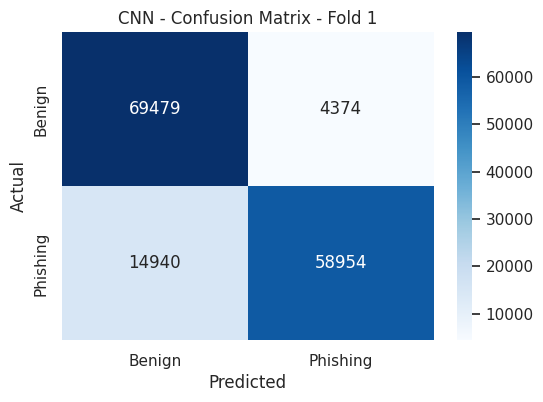


=== CNN - Fold 2 ===
Epoch 1/5
4618/4618 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - accuracy: 0.7811 - loss: 0.5515
Epoch 1: val_loss improved from inf to 0.37660, saving model to best_model_CNN_fold_2.keras
4618/4618 ━━━━━━━━━━━━━━━━━━━━ 110s 23ms/step - accuracy: 0.7811 - loss: 0.5515 - val_accuracy: 0.8538 - val_loss: 0.3766 - learning_rate: 0.0010
Epoch 2/5
4617/4618 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - accuracy: 0.8498 - loss: 0.3746
Epoch 2: val_loss improved from 0.37660 to 0.34484, saving model to best_model_CNN_fold_2.keras
4618/4618 ━━━━━━━━━━━━━━━━━━━━ 107s 23ms/step - accuracy: 0.8498 - loss: 0.3746 - val_accuracy: 0.8688 - val_loss: 0.3448 - learning_rate: 0.0010
Epoch 3/5
4615/4618 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - accuracy: 0.8558 - loss: 0.3623
Epoch 3: val_loss did not improve from 0.34484
4618/4618 ━━━━━━━━━━━━━━━━━━━━ 107s 23ms/step - accuracy: 0.8558 - loss: 0.3623 - val_accuracy: 0.8716 - val_loss: 0.3538 - learning_rate: 0.0010
Epoch 4/5
4617/4618 ━━━━━━━━━━━━━━━━━━━━ 

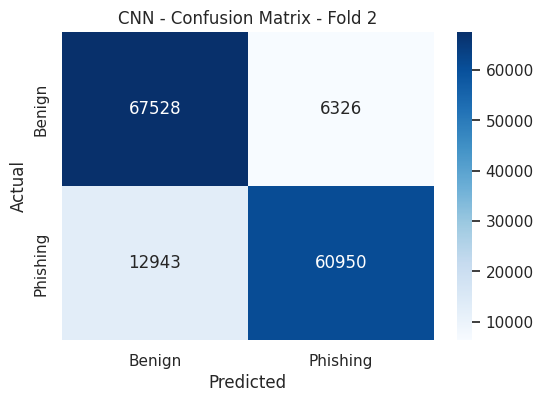


=== CNN - Fold 3 ===
Epoch 1/5
4615/4618 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - accuracy: 0.7770 - loss: 0.5563
Epoch 1: val_loss improved from inf to 0.38095, saving model to best_model_CNN_fold_3.keras
4618/4618 ━━━━━━━━━━━━━━━━━━━━ 110s 23ms/step - accuracy: 0.7771 - loss: 0.5562 - val_accuracy: 0.8468 - val_loss: 0.3810 - learning_rate: 0.0010
Epoch 2/5
4616/4618 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - accuracy: 0.8495 - loss: 0.3750
Epoch 2: val_loss improved from 0.38095 to 0.35781, saving model to best_model_CNN_fold_3.keras
4618/4618 ━━━━━━━━━━━━━━━━━━━━ 105s 23ms/step - accuracy: 0.8495 - loss: 0.3750 - val_accuracy: 0.8589 - val_loss: 0.3578 - learning_rate: 0.0010
Epoch 3/5
4616/4618 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - accuracy: 0.8546 - loss: 0.3627
Epoch 3: val_loss improved from 0.35781 to 0.34169, saving model to best_model_CNN_fold_3.keras
4618/4618 ━━━━━━━━━━━━━━━━━━━━ 106s 23ms/step - accuracy: 0.8546 - loss: 0.3627 - val_accuracy: 0.8660 - val_loss: 0.3417 - learning_rate:

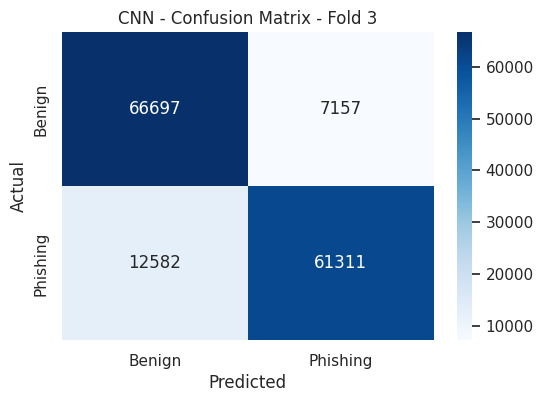


=== CNN - Fold 4 ===
Epoch 1/5
4617/4618 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - accuracy: 0.7857 - loss: 0.5486
Epoch 1: val_loss improved from inf to 0.40026, saving model to best_model_CNN_fold_4.keras
4618/4618 ━━━━━━━━━━━━━━━━━━━━ 109s 23ms/step - accuracy: 0.7857 - loss: 0.5486 - val_accuracy: 0.8530 - val_loss: 0.4003 - learning_rate: 0.0010
Epoch 2/5
4616/4618 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - accuracy: 0.8508 - loss: 0.3706
Epoch 2: val_loss improved from 0.40026 to 0.37563, saving model to best_model_CNN_fold_4.keras
4618/4618 ━━━━━━━━━━━━━━━━━━━━ 106s 23ms/step - accuracy: 0.8508 - loss: 0.3706 - val_accuracy: 0.8661 - val_loss: 0.3756 - learning_rate: 0.0010
Epoch 3/5
4617/4618 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - accuracy: 0.8557 - loss: 0.3603
Epoch 3: val_loss did not improve from 0.37563
4618/4618 ━━━━━━━━━━━━━━━━━━━━ 106s 23ms/step - accuracy: 0.8557 - loss: 0.3603 - val_accuracy: 0.8749 - val_loss: 0.3871 - learning_rate: 0.0010
Epoch 4/5
4617/4618 ━━━━━━━━━━━━━━━━━━━━ 

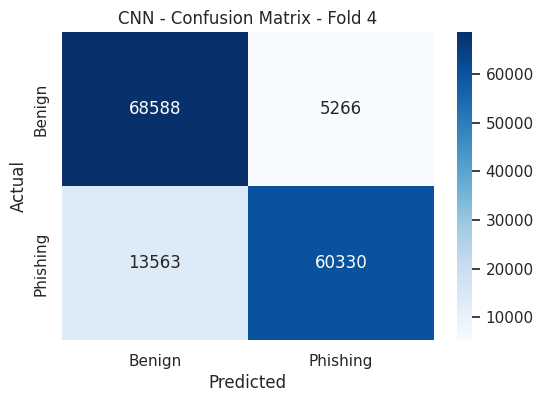


=== CNN - Fold 5 ===
Epoch 1/5
4616/4618 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - accuracy: 0.7841 - loss: 0.5457
Epoch 1: val_loss improved from inf to 0.39764, saving model to best_model_CNN_fold_5.keras
4618/4618 ━━━━━━━━━━━━━━━━━━━━ 109s 23ms/step - accuracy: 0.7841 - loss: 0.5457 - val_accuracy: 0.8455 - val_loss: 0.3976 - learning_rate: 0.0010
Epoch 2/5
4615/4618 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - accuracy: 0.8499 - loss: 0.3729
Epoch 2: val_loss improved from 0.39764 to 0.36624, saving model to best_model_CNN_fold_5.keras
4618/4618 ━━━━━━━━━━━━━━━━━━━━ 105s 23ms/step - accuracy: 0.8499 - loss: 0.3729 - val_accuracy: 0.8556 - val_loss: 0.3662 - learning_rate: 0.0010
Epoch 3/5
4615/4618 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - accuracy: 0.8563 - loss: 0.3600
Epoch 3: val_loss improved from 0.36624 to 0.34594, saving model to best_model_CNN_fold_5.keras
4618/4618 ━━━━━━━━━━━━━━━━━━━━ 105s 23ms/step - accuracy: 0.8563 - loss: 0.3600 - val_accuracy: 0.8664 - val_loss: 0.3459 - learning_rate:

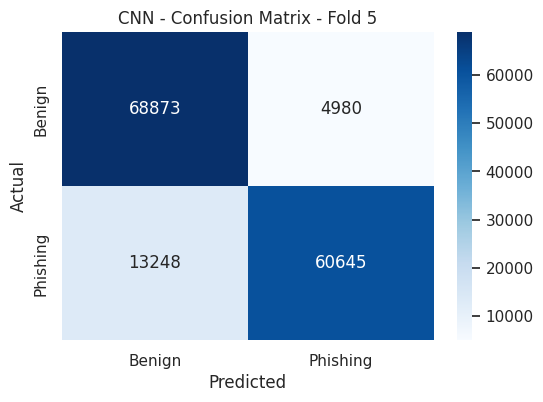


=== CNN - Cross-Validation Metrics ===
Accuracy: 0.8709 ± 0.0035
Precision: 0.9152 ± 0.0128
Recall: 0.8179 ± 0.0110
F1_score: 0.8637 ± 0.0034
Roc_auc: 0.9310 ± 0.0019
Mcc: 0.7462 ± 0.0077
Kappa: 0.7418 ± 0.0069

=== CNN - Tabela de Métricas por Fold ===
| Fold     |   Acurácia |   Precisão |   Recall |   F1-Score |   ROC-AUC |    MCC |   Cohen's Kappa |
|----------|------------|------------|----------|------------|-----------|--------|-----------------|
| 1        |     0.8693 |     0.9309 |   0.7978 |     0.8592 |    0.9304 | 0.7462 |          0.7386 |
| 2        |     0.8696 |     0.9060 |   0.8248 |     0.8635 |    0.9305 | 0.7422 |          0.7392 |
| 3        |     0.8664 |     0.8955 |   0.8297 |     0.8613 |    0.9283 | 0.7348 |          0.7328 |
| 4        |     0.8726 |     0.9197 |   0.8165 |     0.8650 |    0.9320 | 0.7499 |          0.7451 |
| 5        |     0.8766 |     0.9241 |   0.8207 |     0.8694 |    0.9340 | 0.7580 |          0.7533 |
| Média    |     0.8709 |     0

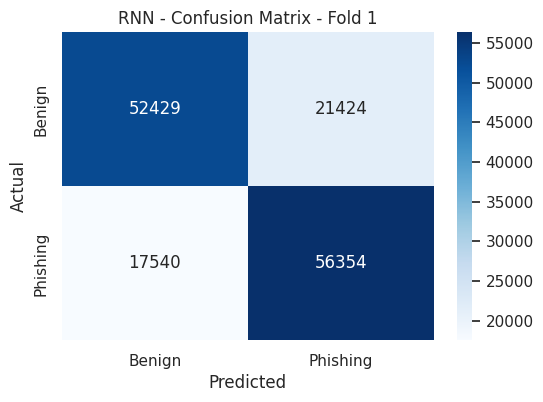


=== RNN - Fold 2 ===
Epoch 1/5
1313/4618 ━━━━━━━━━━━━━━━━━━━━ 2:40 49ms/step - accuracy: 0.6711 - loss: 0.7756

In [ ]:
from datasets import load_from_disk


# -------------------------------------------------------------
# 6. BLOCO PRINCIPAL
# -------------------------------------------------------------
from datasets import load_from_disk

if __name__ == "__main__":
    # 1. Carregar os datasets
    train_path = "data/phishing_dataset/train_final"
    test_path = "data/phishing_dataset/test_final"

    if os.path.exists(train_path) and os.path.exists(test_path):
        train_dataset = load_from_disk(train_path)
        test_dataset = load_from_disk(test_path)
        print("Datasets train_final e test_final carregados com sucesso.")
    else:
        print(f"Diretórios {train_path} ou {test_path} não encontrados.")
        raise FileNotFoundError("Certifique-se de que os datasets estão salvos corretamente.")

    # 2. Converter para DataFrame
    train_df = train_dataset.to_pandas()
    test_df = test_dataset.to_pandas()

    print(f"Conjunto de treinamento possui {train_df.shape[0]} registros.")
    print(f"Conjunto de teste possui {test_df.shape[0]} registros.")

    # 3. Treinar e avaliar cada modelo
    # 3.1 CNN
    metrics_cnn, tokenizer_cnn, top_chars_cnn = train_and_evaluate_model(
        df=train_df,
        model_fn=create_cnn_model,
        model_name="CNN",
        maxlen=200,
        vocab_size=1000,
        max_special_chars=50,
        epochs=5,
        batch_size=128,
        n_splits=5,
        n_jobs=-1
    )

    # 3.2 RNN
    metrics_rnn, tokenizer_rnn, top_chars_rnn = train_and_evaluate_model(
        df=train_df,
        model_fn=create_rnn_model,
        model_name="RNN",
        maxlen=200,
        vocab_size=1000,
        max_special_chars=50,
        epochs=5,
        batch_size=128,
        n_splits=5,
        n_jobs=-1
    )

    # 3.3 LSTM
    metrics_lstm, tokenizer_lstm, top_chars_lstm = train_and_evaluate_model(
        df=train_df,
        model_fn=create_lstm_model,
        model_name="LSTM",
        maxlen=200,
        vocab_size=1000,
        max_special_chars=50,
        epochs=5,
        batch_size=128,
        n_splits=5,
        n_jobs=-1
    )

    # 3.4 Modelo Combinado
    metrics_combined, tokenizer_combined, top_chars_combined = train_and_evaluate_model(
        df=train_df,
        model_fn=create_combined_model,
        model_name="Combinado",
        maxlen=200,
        vocab_size=1000,
        max_special_chars=50,
        epochs=5,
        batch_size=128,
        n_splits=5,
        n_jobs=-1
    )

    # 3.5 Modelo Original
    metrics_original, tokenizer_orig, top_chars_orig = train_and_evaluate_model(
        df=train_df,
        model_fn=create_original_model,
        model_name="Original",
        maxlen=200,
        vocab_size=1000,
        max_special_chars=50,
        epochs=5,
        batch_size=128,
        n_splits=5,
        n_jobs=-1
    )

    # 4. Exemplo de avaliação no conjunto de teste para um dos modelos (ex: o Original)
    #    (Mas você pode fazer para cada um separadamente)
    from tensorflow.keras.models import load_model

    # Carregar o modelo final "Original"
    final_model_path = "model_final_Original.keras"
    model = load_model(final_model_path)

    # Carregar tokenizer e top_chars correspondentes
    with open("tokenizer_Original.pkl", "rb") as f:
        tokenizer_test = pickle.load(f)
    with open("top_chars_Original.pkl", "rb") as f:
        top_chars_test = pickle.load(f)

    # Pré-processar o conjunto de teste
    urls_padded_test, numeric_features_test, labels_test, _, _ = create_pipeline(
        test_df, maxlen=200, vocab_size=1000, max_special_chars=50,
        tokenizer=tokenizer_test, top_chars=top_chars_test, n_jobs=-1
    )

    # Avaliar
    loss_test, accuracy_test = model.evaluate([urls_padded_test, numeric_features_test], labels_test, verbose=0)
    print(f"[Original] Teste - Loss: {loss_test:.4f} - Accuracy: {accuracy_test:.4f}")

    probs_test = model.predict([urls_padded_test, numeric_features_test], verbose=0)
    y_pred_test = (probs_test >= 0.5).astype(np.int8).ravel()

    prec_test = precision_score(labels_test, y_pred_test, zero_division=0)
    rec_test = recall_score(labels_test, y_pred_test, zero_division=0)
    f1_test = f1_score(labels_test, y_pred_test, zero_division=0)
    roc_auc_test = roc_auc_score(labels_test, probs_test)
    mcc_test = matthews_corrcoef(labels_test, y_pred_test)
    kappa_test = cohen_kappa_score(labels_test, y_pred_test)

    print(f"[Original] Teste - Precision: {prec_test:.4f}")
    print(f"[Original] Teste - Recall:    {rec_test:.4f}")
    print(f"[Original] Teste - F1 Score:  {f1_test:.4f}")
    print(f"[Original] Teste - ROC-AUC:   {roc_auc_test:.4f}")
    print(f"[Original] Teste - MCC:       {mcc_test:.4f}")
    print(f"[Original] Teste - Cohen's Kappa: {kappa_test:.4f}\n")

    # Matriz de confusão e Curva ROC (opcional)
    cm_test = confusion_matrix(labels_test, y_pred_test)
    plt.figure(figsize=(6,4))
    sns.heatmap(cm_test, annot=True, fmt='d', cmap='Blues',
                xticklabels=['Benign','Phishing'], yticklabels=['Benign','Phishing'])
    plt.title('[Original] Confusion Matrix - Test Set')
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.show()

    fpr_test, tpr_test, thresholds_test = roc_curve(labels_test, probs_test)
    plt.figure(figsize=(8,6))
    plt.plot(fpr_test, tpr_test, label=f'ROC curve (area = {roc_auc_test:.2f})')
    plt.plot([0, 1], [0, 1], 'k--')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('[Original] ROC Curve - Test Set')
    plt.legend(loc='lower right')
    plt.show()

    # -------------------------------------------------------------
# 5. FUNÇÃO DE PREDIÇÃO
# -------------------------------------------------------------
def predict_url(model, tokenizer, top_chars, new_url, maxlen=200):
    """
    Realiza a predição de uma nova URL utilizando o modelo treinado.

    Args:
        model (Model): Modelo treinado.
        tokenizer (Tokenizer): Tokenizer treinado.
        top_chars (list): Lista de caracteres especiais utilizados.
        new_url (str): URL a ser classificada.
        maxlen (int): Tamanho máximo das sequências tokenizadas.

    Returns:
        tuple: (probabilidade de phishing, classe prevista)
    """
    # Normalizar a URL
    cleaned = normalize_domain(new_url.lower().strip())

    # 1) Montar features numéricas (contagem de cada caractere em top_chars)
    numeric_vals = []
    for ch in top_chars:
        numeric_vals.append(count_characters(cleaned, ch))
    numeric_vals = np.array(numeric_vals, dtype=np.float32).reshape(1, -1)

    # 2) Tokenizar em nível de caractere e pad
    seq = tokenizer.texts_to_sequences([cleaned])
    seq_padded = pad_sequences(seq, maxlen=maxlen, padding='post', truncating='post', dtype='int16')
    seq_padded = seq_padded.astype(np.int32)

    # 3) Fazer previsão
    prob = model.predict([seq_padded, numeric_vals])[0][0]
    predicted_class = 1 if prob >= 0.5 else 0

    return prob, predicted_class

    # 5. Exemplo de Predição em uma nova URL
    sample_url = "http://suspect-website.com?card=123"
    prob, cls = predict_url(model, tokenizer, top_chars, sample_url)
    print(f"Probabilidade de Phishing: {prob:.4f}")
    print(f"Classe Predita: {'Phishing' if cls == 1 else 'Benign'} (1=phishing)")

In [ ]:
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, roc_auc_score
from tensorflow.keras.models import load_model
import pickle

# Supondo que você já tenha salvo os modelos, tokenizers e top_chars de cada arquitetura
model_names = ["CNN", "RNN", "LSTM", "Combinado", "Original"]
models = {}
tokenizers = {}
top_chars_dict = {}

for name in model_names:
    models[name] = load_model(f"model_final_{name}.keras")
    with open(f"tokenizer_{name}.pkl", "rb") as f:
        tokenizers[name] = pickle.load(f)
    with open(f"top_chars_{name}.pkl", "rb") as f:
        top_chars_dict[name] = pickle.load(f)

# Pré-processar o conjunto de teste
# Nota: Se os modelos foram treinados com tokenizers e top_chars diferentes, o ideal é utilizar o mesmo pré-processamento
# para cada modelo. Aqui usamos, por exemplo, o do modelo "Original" como referência.
urls_padded_test, numeric_features_test, labels_test, _, _ = create_pipeline(
    test_df, maxlen=200, vocab_size=1000, max_special_chars=50,
    tokenizer=tokenizers["Original"], top_chars=top_chars_dict["Original"], n_jobs=-1
)

# Plotar as curvas ROC de todos os modelos
plt.figure(figsize=(10,8))
for name, model in models.items():
    # Obter as predições para o conjunto de teste
    probs = model.predict([urls_padded_test, numeric_features_test], verbose=0)

    # Calcular a curva ROC e a área sob a curva (AUC)
    fpr, tpr, _ = roc_curve(labels_test, probs)
    auc_value = roc_auc_score(labels_test, probs)

    # Plotar a curva ROC para o modelo atual
    plt.plot(fpr, tpr, lw=2, label=f"{name} (AUC = {auc_value:.2f})")

# Plotar a linha da chance (modelo aleatório)
plt.plot([0,1], [0,1], linestyle="--", color="gray", label="Chance")

plt.xlabel("Taxa de Falso Positivo (TFP)")
plt.ylabel("Taxa de Verdadeiro Positivo (TVP)")
plt.title("Comparação de Curvas ROC entre Modelos")
plt.legend(loc="lower right")
plt.show()


In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix
from tensorflow.keras.models import load_model
import pickle

# Lista com os nomes dos modelos
model_names = ["CNN", "RNN", "LSTM", "Combinado", "Original"]

# Dicionários para carregar os modelos, tokenizers e top_chars
models = {}
tokenizers = {}
top_chars_dict = {}

for name in model_names:
    models[name] = load_model(f"model_final_{name}.keras")
    with open(f"tokenizer_{name}.pkl", "rb") as f:
        tokenizers[name] = pickle.load(f)
    with open(f"top_chars_{name}.pkl", "rb") as f:
        top_chars_dict[name] = pickle.load(f)

# Pré-processar o conjunto de teste usando, por exemplo, os parâmetros do modelo "Original"
urls_padded_test, numeric_features_test, labels_test, _, _ = create_pipeline(
    test_df, maxlen=200, vocab_size=1000, max_special_chars=50,
    tokenizer=tokenizers["Original"], top_chars=top_chars_dict["Original"], n_jobs=-1
)

# Criar subplots para cada modelo
fig, axes = plt.subplots(nrows=1, ncols=len(model_names), figsize=(4 * len(model_names), 5))

for i, name in enumerate(model_names):
    model = models[name]
    # Obter as predições para o conjunto de teste
    probs = model.predict([urls_padded_test, numeric_features_test], verbose=0)
    y_pred = (probs >= 0.5).astype(int).ravel()
    # Calcular a matriz de confusão
    cm = confusion_matrix(labels_test, y_pred)

    # Plotar a matriz de confusão no subplot correspondente
    ax = axes[i] if len(model_names) > 1 else axes
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", ax=ax,
                xticklabels=['Benign','Phishing'], yticklabels=['Benign','Phishing'])
    ax.set_title(f"{name} Confusion Matrix")
    ax.set_xlabel("Predicted")
    ax.set_ylabel("Actual")

plt.tight_layout()
plt.show()


In [ ]:
# 5. Exemplo de Predição em uma nova URL
sample_url = "http://www.google.com.br"
prob, cls = predict_url(model, tokenizer, top_chars, sample_url)
print(f"Probabilidade de Phishing: {prob:.4f}")
print(f"Classe Predita: {'Phishing' if cls == 1 else 'Benign'} (1=phishing)")

In [ ]:
%load_ext tensorboard
%tensorboard --logdir logs


In [ ]:
from tensorflow.keras.utils import plot_model
dot_img_file = '/tmp/model_1.png'
plot_model(model, to_file=dot_img_file, show_shapes=True)

In [ ]:
# Carregar para predição em outro script:
model = tf.keras.models.load_model("model_final.keras")
with open("tokenizer.pkl", "rb") as f:
         tokenizer = pickle.load(f)
with open("top_chars.pkl", "rb") as f:
         top_chars = pickle.load(f)

# Exemplo de predição:
prob, cls = predict_url(model, tokenizer, top_chars, "https://whitehouse.ai")
print(f"Prob: {prob:.4f}, Classe: {cls} (1=phishing)")

In [ ]:
"""
Detector de Phishing baseado em Deep Learning
Código refatorado com visualizações, tabelas de métricas e integração com TensorBoard

Este código implementa um sistema completo para detecção de URLs de phishing usando modelos de deep learning.
Principais funcionalidades:
1. Implementação de diferentes arquiteturas (CNN, LSTM, modelo híbrido CNN-LSTM)
2. Validação cruzada com métricas detalhadas (acurácia, precisão, recall, F1-score, ROC-AUC, MCC, Cohen's Kappa)
3. Geração de tabelas e gráficos para análise de resultados
4. Tratamento de classes desbalanceadas
5. Interpretabilidade do modelo via SHAP
6. Integração com TensorBoard para monitoramento em tempo real do treinamento
7. Exportação de resultados em formatos adequados para relatórios

Autor: [Seu nome]
Data: [Data]
"""

import os
import pickle
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import datetime

from tensorflow.keras.models import Model, load_model
from tensorflow.keras.layers import Input, Embedding, Conv1D, GlobalMaxPooling1D, LSTM, Dense
from tensorflow.keras.layers import Dropout, Concatenate, Bidirectional
from tensorflow.keras.callbacks import TensorBoard, EarlyStopping, ModelCheckpoint
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.optimizers import Adam

from sklearn.model_selection import KFold, StratifiedKFold
from sklearn.metrics import precision_score, recall_score, f1_score, roc_auc_score
from sklearn.metrics import matthews_corrcoef, cohen_kappa_score, classification_report
from sklearn.metrics import confusion_matrix, roc_curve
from sklearn.utils.class_weight import compute_class_weight

from datasets import load_from_disk
from tabulate import tabulate

# =====================================================================
# 1. FUNÇÕES DE PREPROCESSAMENTO
# =====================================================================

def normalize_domain(url):
    """
    Normaliza uma URL para processamento.

    Args:
        url (str): URL a ser normalizada.

    Returns:
        str: URL normalizada.
    """
    # Implementação simplificada, expansível conforme necessário
    return url.lower().strip()

def count_characters(text, char):
    """
    Conta o número de ocorrências de um caractere em um texto.

    Args:
        text (str): Texto a ser analisado.
        char (str): Caractere a ser contado.

    Returns:
        int: Número de ocorrências.
    """
    return text.count(char)

def create_pipeline(df, maxlen=200, vocab_size=1000, max_special_chars=50,
                   tokenizer=None, top_chars=None, n_jobs=-1):
    """
    Cria um pipeline de processamento para as URLs.

    Args:
        df (DataFrame): DataFrame com os dados.
        maxlen (int): Tamanho máximo das sequências.
        vocab_size (int): Tamanho do vocabulário.
        max_special_chars (int): Número máximo de caracteres especiais.
        tokenizer (Tokenizer): Tokenizer pré-treinado (opcional).
        top_chars (list): Lista de caracteres especiais (opcional).
        n_jobs (int): Número de jobs para processamento paralelo.

    Returns:
        tuple: (sequências tokenizadas, features numéricas, labels, tokenizer, top_chars)
    """
    from tensorflow.keras.preprocessing.text import Tokenizer

    # Extrair URLs e labels
    urls = df['url'].values if 'url' in df.columns else df['URL'].values
    labels = df['label'].values if 'label' in df.columns else df['Label'].values

    # Normalizar URLs
    cleaned_urls = [normalize_domain(url) for url in urls]

    # 1. Tokenização em nível de caractere
    if tokenizer is None:
        tokenizer = Tokenizer(num_words=vocab_size, char_level=True, oov_token='<OOV>')
        tokenizer.fit_on_texts(cleaned_urls)

    # Converter textos para sequências
    sequences = tokenizer.texts_to_sequences(cleaned_urls)

    # Padding das sequências
    padded_sequences = pad_sequences(sequences, maxlen=maxlen, padding='post', truncating='post')

    # 2. Extração de características numéricas (contagem de caracteres especiais)
    if top_chars is None:
        # Definir caracteres especiais de interesse
        all_special_chars = list('.-_?=&%#+/\\:;,@[](){}|<>\'\"!')

        # Contar ocorrências de cada caractere nas URLs
        char_counts = {}
        for char in all_special_chars:
            counts = [count_characters(url, char) for url in cleaned_urls]
            char_counts[char] = sum(counts)

        # Selecionar os caracteres mais frequentes
        top_chars = sorted(char_counts, key=char_counts.get, reverse=True)[:max_special_chars]

    # Criar features para cada URL baseadas na contagem de caracteres especiais
    numeric_features = np.zeros((len(cleaned_urls), len(top_chars)))
    for i, url in enumerate(cleaned_urls):
        for j, char in enumerate(top_chars):
            numeric_features[i, j] = count_characters(url, char)

    return padded_sequences, numeric_features, labels, tokenizer, top_chars

# =====================================================================
# 2. MODELOS DE DEEP LEARNING
# =====================================================================

def create_original_model(input_shape, num_features, vocab_size=1000, embedding_dim=64):
    """
    Cria o modelo original conforme implementado no código inicial.

    Args:
        input_shape (tuple): Forma de entrada para sequências.
        num_features (int): Número de features numéricas.
        vocab_size (int): Tamanho do vocabulário.
        embedding_dim (int): Dimensão do embedding.

    Returns:
        Model: Modelo original compilado.
    """
    # Input para sequência tokenizada (URLs)
    url_input = Input(shape=input_shape, name='url_input')

    # Camada de embedding
    embedding = Embedding(input_dim=vocab_size+1, output_dim=embedding_dim,
                         input_length=input_shape[0])(url_input)

    # Camada convolucional com tamanho de kernel 3
    conv = Conv1D(filters=64, kernel_size=3, activation='relu')(embedding)

    # Global Max Pooling
    pool = GlobalMaxPooling1D()(conv)

    # Input para features numéricas
    numeric_input = Input(shape=(num_features,), name='numeric_input')

    # Concatenar com as features numéricas
    merged = Concatenate()([pool, numeric_input])

    # Camadas densas
    dense1 = Dense(100, activation='relu')(merged)
    dropout1 = Dropout(0.5)(dense1)

    # Saída
    output = Dense(1, activation='sigmoid')(dropout1)

    print(f"Criando modelo {model_type}...")
    input_shape = (X_seq_train.shape[1],)
    num_features = X_num_train.shape[1]

    # Criar modelo
    model = Model(inputs=[url_input, numeric_input], outputs=output)
    model.compile(optimizer='adam',
                  loss='binary_crossentropy',
                  metrics=['accuracy'])

    return model

def create_cnn_model(input_shape, num_features, vocab_size=1000, embedding_dim=64):
    """
    Cria um modelo CNN para análise de sequências (URLs).

    Args:
        input_shape (tuple): Forma de entrada para sequências.
        num_features (int): Número de features numéricas.
        vocab_size (int): Tamanho do vocabulário.
        embedding_dim (int): Dimensão do embedding.

    Returns:
        Model: Modelo CNN compilado.
    """
    # Input para sequência tokenizada (URLs)
    url_input = Input(shape=input_shape, name='url_input')

    # Camada de embedding
    embedding = Embedding(input_dim=vocab_size+1, output_dim=embedding_dim,
                         input_length=input_shape[0])(url_input)

    # Camadas convolucionais com diferentes tamanhos de kernel
    conv1 = Conv1D(filters=32, kernel_size=3, activation='relu')(embedding)
    conv2 = Conv1D(filters=32, kernel_size=4, activation='relu')(embedding)
    conv3 = Conv1D(filters=32, kernel_size=5, activation='relu')(embedding)

    # Pooling
    pool1 = GlobalMaxPooling1D()(conv1)
    pool2 = GlobalMaxPooling1D()(conv2)
    pool3 = GlobalMaxPooling1D()(conv3)

    # Concatenação dos resultados de pooling
    concat = Concatenate()([pool1, pool2, pool3])

    # Input para features numéricas
    numeric_input = Input(shape=(num_features,), name='numeric_input')

    # Concatenar com as features numéricas
    merged = Concatenate()([concat, numeric_input])

    # Camadas densas
    dense1 = Dense(128, activation='relu')(merged)
    dropout1 = Dropout(0.5)(dense1)
    dense2 = Dense(64, activation='relu')(dropout1)
    dropout2 = Dropout(0.3)(dense2)

    # Saída
    output = Dense(1, activation='sigmoid')(dropout2)

    # Criar modelo
    model = Model(inputs=[url_input, numeric_input], outputs=output)
    model.compile(optimizer=Adam(learning_rate=0.001),
                  loss='binary_crossentropy',
                  metrics=['accuracy'])

    return model

def create_lstm_model(input_shape, num_features, vocab_size=1000, embedding_dim=64):
    """
    Cria um modelo LSTM para análise de sequências (URLs).

    Args:
        input_shape (tuple): Forma de entrada para sequências.
        num_features (int): Número de features numéricas.
        vocab_size (int): Tamanho do vocabulário.
        embedding_dim (int): Dimensão do embedding.

    Returns:
        Model: Modelo LSTM compilado.
    """
    # Input para sequência tokenizada (URLs)
    url_input = Input(shape=input_shape, name='url_input')

    # Camada de embedding
    embedding = Embedding(input_dim=vocab_size+1, output_dim=embedding_dim,
                         input_length=input_shape[0])(url_input)

    # LSTM bidirecional
    lstm_layer = Bidirectional(LSTM(64, return_sequences=False))(embedding)
    dropout_lstm = Dropout(0.5)(lstm_layer)

    # Input para features numéricas
    numeric_input = Input(shape=(num_features,), name='numeric_input')

    # Concatenar com as features numéricas
    merged = Concatenate()([dropout_lstm, numeric_input])

    # Camadas densas
    dense1 = Dense(128, activation='relu')(merged)
    dropout1 = Dropout(0.5)(dense1)
    dense2 = Dense(64, activation='relu')(dropout1)
    dropout2 = Dropout(0.3)(dense2)

    # Saída
    output = Dense(1, activation='sigmoid')(dropout2)

    # Criar modelo
    model = Model(inputs=[url_input, numeric_input], outputs=output)
    model.compile(optimizer=Adam(learning_rate=0.001),
                  loss='binary_crossentropy',
                  metrics=['accuracy'])

    return model

def create_cnn_lstm_model(input_shape, num_features, vocab_size=1000, embedding_dim=64):
    """
    Cria um modelo híbrido CNN-LSTM para análise de sequências (URLs).

    Args:
        input_shape (tuple): Forma de entrada para sequências.
        num_features (int): Número de features numéricas.
        vocab_size (int): Tamanho do vocabulário.
        embedding_dim (int): Dimensão do embedding.

    Returns:
        Model: Modelo CNN-LSTM compilado.
    """
    # Input para sequência tokenizada (URLs)
    url_input = Input(shape=input_shape, name='url_input')

    # Camada de embedding
    embedding = Embedding(input_dim=vocab_size+1, output_dim=embedding_dim,
                         input_length=input_shape[0])(url_input)

    # Camada convolucional
    conv = Conv1D(filters=64, kernel_size=3, activation='relu')(embedding)

    # Camada LSTM
    lstm_layer = LSTM(64, return_sequences=False)(conv)
    dropout_lstm = Dropout(0.5)(lstm_layer)

    # Input para features numéricas
    numeric_input = Input(shape=(num_features,), name='numeric_input')

    # Concatenar com as features numéricas
    merged = Concatenate()([dropout_lstm, numeric_input])

    # Camadas densas
    dense1 = Dense(128, activation='relu')(merged)
    dropout1 = Dropout(0.5)(dense1)
    dense2 = Dense(64, activation='relu')(dropout1)
    dropout2 = Dropout(0.3)(dense2)

    # Saída
    output = Dense(1, activation='sigmoid')(dropout2)

    # Criar modelo
    model = Model(inputs=[url_input, numeric_input], outputs=output)
    model.compile(optimizer=Adam(learning_rate=0.001),
                  loss='binary_crossentropy',
                  metrics=['accuracy'])

    return model

# =====================================================================
# 3. TÉCNICAS DE BALANCEAMENTO DE CLASSES
# =====================================================================

def apply_class_weights(y_train):
    """
    Calcula pesos para lidar com classes desbalanceadas.

    Args:
        y_train (array): Labels de treinamento.

    Returns:
        dict: Dicionário de pesos por classe.
    """
    classes = np.unique(y_train)
    class_weights = compute_class_weight(class_weight='balanced', classes=classes, y=y_train)
    class_weight_dict = {i: weight for i, weight in zip(classes, class_weights)}

    return class_weight_dict

def apply_undersampling(X_seq, X_num, y):
    """
    Aplica undersampling na classe majoritária.

    Args:
        X_seq (array): Sequências de entrada.
        X_num (array): Features numéricas.
        y (array): Labels.

    Returns:
        tuple: (X_seq balanceado, X_num balanceado, y balanceado)
    """
    try:
        from imblearn.under_sampling import RandomUnderSampler
    except ImportError:
        print("Biblioteca imblearn não encontrada. Instale com: pip install imbalanced-learn")
        return X_seq, X_num, y

    # Combinar os dados para undersampling
    X_combined = np.column_stack([np.arange(len(y)), np.zeros(len(y))])

    # Aplicar undersampling
    undersampler = RandomUnderSampler(random_state=42)
    X_resampled, y_resampled = undersampler.fit_resample(X_combined, y)

    # Extrair índices dos exemplos mantidos
    indices = X_resampled[:, 0].astype(int)

    # Retornar dados balanceados
    return X_seq[indices], X_num[indices], y_resampled

def apply_oversampling(X_num, y):
    """
    Aplica oversampling na classe minoritária para features numéricas.

    Args:
        X_num (array): Features numéricas.
        y (array): Labels.

    Returns:
        tuple: (X_num balanceado, y balanceado)
    """
    try:
        from imblearn.over_sampling import SMOTE
    except ImportError:
        print("Biblioteca imblearn não encontrada. Instale com: pip install imbalanced-learn")
        return X_num, y

    # Aplicar SMOTE apenas nas features numéricas
    smote = SMOTE(random_state=42)
    X_num_resampled, y_resampled = smote.fit_resample(X_num, y)

    return X_num_resampled, y_resampled

# =====================================================================
# 4. VISUALIZAÇÕES E GRÁFICOS
# =====================================================================

def setup_dirs():
    """
    Configura diretórios para salvar resultados.

    Returns:
        tuple: (diretório de figuras, diretório de tabelas, diretório de logs)
    """
    figures_dir = "figures"
    tables_dir = "tables"
    logs_dir = "logs"
    models_dir = "models"

    for directory in [figures_dir, tables_dir, logs_dir, models_dir]:
        os.makedirs(directory, exist_ok=True)

    return figures_dir, tables_dir, logs_dir, models_dir

def plot_roc_curve(fpr, tpr, roc_auc, model_name="model", save_path="figures"):
    """
    Plota e salva a curva ROC.

    Args:
        fpr (array): Taxa de falsos positivos.
        tpr (array): Taxa de verdadeiros positivos.
        roc_auc (float): Área sob a curva ROC.
        model_name (str): Nome do modelo.
        save_path (str): Diretório para salvar a figura.

    Returns:
        str: Caminho da figura salva.
    """
    plt.figure(figsize=(10, 8))
    plt.plot(fpr, tpr, lw=2, label=f'ROC curve (area = {roc_auc:.3f})')
    plt.plot([0, 1], [0, 1], 'k--', lw=2)
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title(f'Receiver Operating Characteristic (ROC) - {model_name}')
    plt.legend(loc="lower right")

    # Salvar figura
    file_path = f"{save_path}/roc_curve_{model_name}.png"
    plt.savefig(file_path, dpi=300, bbox_inches='tight')
    plt.close()

    print(f"Curva ROC salva em: {file_path}")
    return file_path

def plot_confusion_matrix(cm, class_names=None, model_name="model", save_path="figures"):
    """
    Plota e salva a matriz de confusão visual.

    Args:
        cm (array): Matriz de confusão.
        class_names (list): Nomes das classes.
        model_name (str): Nome do modelo.
        save_path (str): Diretório para salvar a figura.

    Returns:
        str: Caminho da figura salva.
    """
    if class_names is None:
        class_names = ['Benign', 'Phishing']

    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
               xticklabels=class_names, yticklabels=class_names)
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.title(f'Confusion Matrix - {model_name}')

    # Salvar figura
    file_path = f"{save_path}/confusion_matrix_{model_name}.png"
    plt.savefig(file_path, dpi=300, bbox_inches='tight')
    plt.close()

    print(f"Matriz de confusão salva em: {file_path}")
    return file_path

def plot_training_history(history, model_name="model", save_path="figures"):
    """
    Plota e salva o gráfico de convergência (loss e acurácia).

    Args:
        history (History): Histórico de treinamento.
        model_name (str): Nome do modelo.
        save_path (str): Diretório para salvar a figura.

    Returns:
        str: Caminho da figura salva.
    """
    plt.figure(figsize=(12, 5))

    # Plot de loss
    plt.subplot(1, 2, 1)
    plt.plot(history.history['loss'], label='Training Loss')
    if 'val_loss' in history.history:
        plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.title('Training and Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()

    # Plot de acurácia
    plt.subplot(1, 2, 2)
    plt.plot(history.history['accuracy'], label='Training Accuracy')
    if 'val_accuracy' in history.history:
        plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
    plt.title('Training and Validation Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()

    plt.tight_layout()

    # Salvar figura
    file_path = f"{save_path}/training_history_{model_name}.png"
    plt.savefig(file_path, dpi=300, bbox_inches='tight')
    plt.close()

    print(f"Histórico de treinamento salvo em: {file_path}")
    return file_path

def plot_metrics_boxplot(metrics_df, model_name="model", save_path="figures"):
    """
    Plota e salva um boxplot das métricas entre os folds.

    Args:
        metrics_df (DataFrame): DataFrame com as métricas.
        model_name (str): Nome do modelo.
        save_path (str): Diretório para salvar a figura.

    Returns:
        str: Caminho da figura salva.
    """
    # Selecionando apenas as colunas numéricas (excluindo 'fold')
    metrics_df_num = metrics_df.drop('fold', axis=1) if 'fold' in metrics_df.columns else metrics_df

    plt.figure(figsize=(14, 8))
    sns.boxplot(data=metrics_df_num)
    plt.title(f'Distribution of Metrics Across Folds - {model_name}')
    plt.ylabel('Score')
    plt.xticks(rotation=45)
    plt.grid(axis='y', linestyle='--', alpha=0.7)

    # Salvar figura
    file_path = f"{save_path}/metrics_boxplot_{model_name}.png"
    plt.savefig(file_path, dpi=300, bbox_inches='tight')
    plt.close()

    print(f"Boxplot de métricas salvo em: {file_path}")
    return file_path

def apply_shap_analysis(model, X_seq_sample, X_num_sample, feature_names,
                        model_name="model", save_path="figures"):
    """
    Aplica análise SHAP para interpretar as decisões do modelo.

    Args:
        model (Model): Modelo treinado.
        X_seq_sample (array): Amostra de sequências.
        X_num_sample (array): Amostra de features numéricas.
        feature_names (list): Nomes das features.
        model_name (str): Nome do modelo.
        save_path (str): Diretório para salvar a figura.

    Returns:
        str: Caminho da figura salva ou None se falhar.
    """
    try:
        import shap
    except ImportError:
        print("Biblioteca SHAP não encontrada. Instale com: pip install shap")
        return None

    try:
        # Criar um explicador SHAP
        explainer = shap.DeepExplainer(model, [X_seq_sample[:100], X_num_sample[:100]])

        # Calcular valores SHAP
        shap_values = explainer.shap_values([X_seq_sample[:10], X_num_sample[:10]])

        # Para modelos com uma única saída, shap_values é uma lista, não uma lista de listas
        if isinstance(shap_values[0], list):
            shap_values_numeric = shap_values[1][0]  # Para modelos com múltiplas saídas
        else:
            shap_values_numeric = shap_values[1]  # Para modelos com uma única saída

        # Plotar summary plot para as features numéricas
        plt.figure(figsize=(10, 8))
        shap.summary_plot(shap_values_numeric, X_num_sample[:10],
                         feature_names=feature_names, show=False)
        plt.title(f'SHAP Feature Importance - {model_name}')

        # Salvar figura
        file_path = f"{save_path}/shap_summary_{model_name}.png"
        plt.savefig(file_path, dpi=300, bbox_inches='tight')
        plt.close()

        print(f"Análise SHAP salva em: {file_path}")
        return file_path
    except Exception as e:
        print(f"Erro ao aplicar análise SHAP: {str(e)}")
        return None

# =====================================================================
# 5. GERAÇÃO DE TABELAS
# =====================================================================

def generate_metrics_table(metrics_df, model_name="model", save_path="tables"):
    """
    Gera e salva uma tabela de métricas de validação cruzada.

    Args:
        metrics_df (DataFrame): DataFrame com as métricas.
        model_name (str): Nome do modelo.
        save_path (str): Diretório para salvar a tabela.

    Returns:
        str: Caminho da tabela salva.
    """
    # Formatar as métricas com 4 casas decimais
    formatted_df = metrics_df.copy()
    for col in formatted_df.columns:
        if col != 'fold' and pd.api.types.is_numeric_dtype(formatted_df[col]):
            formatted_df[col] = formatted_df[col].map(lambda x: f"{x:.4f}")

    # Adicionar linha de média e desvio padrão
    metrics_mean = metrics_df.drop('fold', axis=1).mean() if 'fold' in metrics_df.columns else metrics_df.mean()
    metrics_std = metrics_df.drop('fold', axis=1).std() if 'fold' in metrics_df.columns else metrics_df.std()

    # Formatar média e desvio padrão
    mean_formatted = {col: f"{val:.4f}" for col, val in metrics_mean.items()}
    std_formatted = {col: f"{val:.4f}" for col, val in metrics_std.items()}

    # Criar tabela em formato texto
    headers = formatted_df.columns.tolist()
    table_data = formatted_df.values.tolist()

    # Adicionar média e desvio padrão
    mean_row = ["Média"] + [mean_formatted[col] for col in headers if col != 'fold']
    std_row = ["Desv.Pad"] + [std_formatted[col] for col in headers if col != 'fold']
    table_data.append(mean_row)
    table_data.append(std_row)

    # Remover 'fold' do cabeçalho se presente
    if 'fold' in headers:
        headers[headers.index('fold')] = "Fold"

    # Salvar tabela em arquivo
    file_path = f"{save_path}/metrics_table_{model_name}.txt"
    with open(file_path, "w", encoding="utf-8") as f:
        f.write(tabulate(table_data, headers=headers, tablefmt="grid"))

    print(f"Tabela de métricas salva em: {file_path}")
    return file_path

def generate_confusion_matrix_table(cm, class_names=None, model_name="model", save_path="tables"):
    """
    Gera e salva uma tabela com a matriz de confusão.

    Args:
        cm (array): Matriz de confusão.
        class_names (list): Nomes das classes.
        model_name (str): Nome do modelo.
        save_path (str): Diretório para salvar a tabela.

    Returns:
        str: Caminho da tabela salva.
    """
    if class_names is None:
        class_names = ['Benign', 'Phishing']

    # Calcular métricas derivadas da matriz de confusão
    tn, fp, fn, tp = cm.ravel()

    # Criar tabela
    headers = ["Métrica", "Valor"]
    table_data = [
        ["VP (True Positives)", tp],
        ["VN (True Negatives)", tn],
        ["FP (False Positives)", fp],
        ["FN (False Negatives)", fn],
        ["Acurácia", f"{(tp + tn) / (tp + tn + fp + fn):.4f}"],
        ["Precisão", f"{tp / (tp + fp):.4f}" if (tp + fp) > 0 else "0.0000"],
        ["Recall/Sensibilidade", f"{tp / (tp + fn):.4f}" if (tp + fn) > 0 else "0.0000"],
        ["Especificidade", f"{tn / (tn + fp):.4f}" if (tn + fp) > 0 else "0.0000"],
        ["F1-Score", f"{2 * tp / (2 * tp + fp + fn):.4f}" if (2 * tp + fp + fn) > 0 else "0.0000"]
    ]

    # Salvar tabela em arquivo
    file_path = f"{save_path}/confusion_matrix_table_{model_name}.txt"
    with open(file_path, "w", encoding="utf-8") as f:
        f.write(tabulate(table_data, headers=headers, tablefmt="grid"))

    print(f"Tabela de matriz de confusão salva em: {file_path}")
    return file_path

def setup_tensorboard_callback(model_name="phishing_detector", logs_dir="logs"):
    """
    Configura o callback do TensorBoard.

    Args:
        model_name (str): Nome do modelo.
        logs_dir (str): Diretório para logs.

    Returns:
        TensorBoard: Callback configurado.
    """
    log_dir = f"{logs_dir}/{model_name}_{datetime.datetime.now().strftime('%Y%m%d-%H%M%S')}"
    return TensorBoard(
        log_dir=log_dir,
        histogram_freq=1,
        write_graph=True,
        write_images=True,
        update_freq='epoch',
        profile_batch=2,
        embeddings_freq=1,
    )

def launch_tensorboard(log_dir="logs"):
    """
    Lança o TensorBoard para visualização interativa.

    Args:
        log_dir (str): Diretório de logs.
    """
    # Verificar se o diretório existe
    if not os.path.exists(log_dir):
        print(f"Diretório {log_dir} não encontrado. Verifique se o treinamento foi executado com TensorBoard.")
        return

    # Comando para iniciar o TensorBoard
    cmd = f"tensorboard --logdir={log_dir}"
    print(f"Execute o comando a seguir em um terminal para iniciar o TensorBoard:")
    print(cmd)
    print(f"Depois, acesse http://localhost:6006 em seu navegador")

# =====================================================================
# 6. FUNÇÕES DE TREINAMENTO E AVALIAÇÃO
# =====================================================================

def train_and_evaluate(train_df, maxlen=200, vocab_size=1000, max_special_chars=50,
                      epochs=25, batch_size=128, n_splits=5, n_jobs=-1, model_type="cnn",
                      balance_strategy=None):
    """
    Treina e avalia o modelo utilizando validação cruzada.

    Args:
        train_df (DataFrame): DataFrame com os dados de treinamento.
        maxlen (int): Tamanho máximo das sequências.
        vocab_size (int): Tamanho do vocabulário.
        max_special_chars (int): Número máximo de caracteres especiais.
        epochs (int): Número de épocas de treinamento.
        batch_size (int): Tamanho do batch.
        n_splits (int): Número de folds para validação cruzada.
        n_jobs (int): Número de jobs para processamento paralelo.
        model_type (str): Tipo de modelo ('cnn', 'lstm', 'cnn_lstm').
        balance_strategy (str): Estratégia de balanceamento ('class_weights', 'undersampling', 'oversampling').

    Returns:
        dict: Métricas de avaliação.
    """
    # Configurar diretórios para salvar resultados
    figures_dir, tables_dir, logs_dir, models_dir = setup_dirs()

    # Inicializar KFold estratificado
    kf = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=42)

    # Extrair URLs e labels
    urls = train_df['url'].values if 'url' in train_df.columns else train_df['URL'].values
    labels = train_df['label'].values if 'label' in train_df.columns else train_df['Label'].values

    # Armazenamento de métricas para cada fold
    metrics = {
        'fold': [],
        'accuracy': [],
        'precision': [],
        'recall': [],
        'f1_score': [],
        'roc_auc': [],
        'mcc': [],
        'cohen_kappa': []
    }

    # Para cada fold
    fold = 1
    for train_idx, val_idx in kf.split(train_df, labels):
        print(f"\n-- Fold {fold}/{n_splits} --")

        train_fold = train_df.iloc[train_idx]
        val_fold = train_df.iloc[val_idx]

        # Preparar os dados
        print("Preparando pipeline de dados...")
        X_seq_train, X_num_train, y_train, tokenizer, top_chars = create_pipeline(
            train_fold, maxlen=maxlen, vocab_size=vocab_size, max_special_chars=max_special_chars, n_jobs=n_jobs
        )

        X_seq_val, X_num_val, y_val, _, _ = create_pipeline(
            val_fold, maxlen=maxlen, vocab_size=vocab_size, max_special_chars=max_special_chars,
            tokenizer=tokenizer, top_chars=top_chars, n_jobs=n_jobs
        )

        # Aplicar estratégia de balanceamento, se solicitado
        if balance_strategy == 'class_weights':
            print("Aplicando pesos de classe para balanceamento...")
            class_weight = apply_class_weights(y_train)
        elif balance_strategy == 'undersampling':
            print("Aplicando undersampling para balanceamento...")
            X_seq_train, X_num_train, y_train = apply_undersampling(X_seq_train, X_num_train, y_train)
        elif balance_strategy == 'oversampling':
            print("Aplicando oversampling para balanceamento...")
            # Nota: oversampling é mais complexo para dados sequenciais
            pass
        else:
            class_weight = None

        # Criar modelo
        print(f"Criando modelo {model_type}...")
        input_shape = (X_seq_train.shape[1],)
        num_features = X_num_train.shape[1]

        if model_type == 'cnn':
            model = create_cnn_model(input_shape, num_features, vocab_size=vocab_size)
        elif model_type == 'lstm':
            model = create_lstm_model(input_shape, num_features, vocab_size=vocab_size)
        elif model_type == 'cnn_lstm':
            model = create_cnn_lstm_model(input_shape, num_features, vocab_size=vocab_size)
        else:
            raise ValueError(f"Tipo de modelo desconhecido: {model_type}")

        # Configurar callbacks
        tensorboard_callback = setup_tensorboard_callback(f"{model_type}_fold{fold}", logs_dir)
        early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
        model_checkpoint = ModelCheckpoint(
            f"{models_dir}/{model_type}_fold{fold}.keras",
            monitor='val_loss',
            save_best_only=True
        )

        # Treinamento do modelo
        print(f"Treinando modelo (Fold {fold}/{n_splits})...")
        history = model.fit(
            [X_seq_train, X_num_train], y_train,
            validation_data=([X_seq_val, X_num_val], y_val),
            epochs=epochs,
            batch_size=batch_size,
            verbose=1,
            callbacks=[tensorboard_callback, early_stopping, model_checkpoint],
            class_weight=class_weight if balance_strategy == 'class_weights' else None
        )

        # Plotar histórico de treinamento
        plot_training_history(history, f"{model_type}_fold{fold}", figures_dir)

        # Avaliação no conjunto de validação
        print(f"Avaliando modelo (Fold {fold}/{n_splits})...")
        _, val_accuracy = model.evaluate([X_seq_val, X_num_val], y_val, verbose=0)

        # Predições no conjunto de validação
        probs_val = model.predict([X_seq_val, X_num_val], verbose=0)
        y_pred_val = (probs_val >= 0.5).astype(np.int8).ravel()

        # Calcular métricas
        val_precision = precision_score(y_val, y_pred_val, zero_division=0)
        val_recall = recall_score(y_val, y_pred_val, zero_division=0)
        val_f1 = f1_score(y_val, y_pred_val, zero_division=0)
        val_roc_auc = roc_auc_score(y_val, probs_val)
        val_mcc = matthews_corrcoef(y_val, y_pred_val)
        val_kappa = cohen_kappa_score(y_val, y_pred_val)

        # Armazenar métricas
        metrics['fold'].append(fold)
        metrics['accuracy'].append(val_accuracy)
        metrics['precision'].append(val_precision)
        metrics['recall'].append(val_recall)
        metrics['f1_score'].append(val_f1)
        metrics['roc_auc'].append(val_roc_auc)
        metrics['mcc'].append(val_mcc)
        metrics['cohen_kappa'].append(val_kappa)

        # Imprimir resultados do fold
        print(f"Fold {fold} - Accuracy: {val_accuracy:.4f}, Precision: {val_precision:.4f}, "
              f"Recall: {val_recall:.4f}, F1: {val_f1:.4f}, ROC-AUC: {val_roc_auc:.4f}, "
              f"MCC: {val_mcc:.4f}, Kappa: {val_kappa:.4f}")

        # Plotar curva ROC
        fpr, tpr, _ = roc_curve(y_val, probs_val)
        plot_roc_curve(fpr, tpr, val_roc_auc, f"{model_type}_fold{fold}", figures_dir)

        # Matriz de confusão
        cm = confusion_matrix(y_val, y_pred_val)
        plot_confusion_matrix(cm, class_names=['Benign', 'Phishing'],
                             model_name=f"{model_type}_fold{fold}", save_path=figures_dir)

        # Gerar tabela da matriz de confusão
        generate_confusion_matrix_table(cm, model_name=f"{model_type}_fold{fold}", save_path=tables_dir)

        # Salvar tokenizer e top_chars no último fold
        if fold == n_splits:
            with open(f"{models_dir}/tokenizer.pkl", "wb") as f:
                pickle.dump(tokenizer, f)
            with open(f"{models_dir}/top_chars.pkl", "wb") as f:
                pickle.dump(top_chars, f)

        fold += 1

    # Converter para DataFrame
    metrics_df = pd.DataFrame(metrics)

    # Calcular médias e desvios padrão
    metrics_mean = metrics_df.drop('fold', axis=1).mean()
    metrics_std = metrics_df.drop('fold', axis=1).std()

    # Gerar tabela de métricas
    generate_metrics_table(metrics_df, model_name=model_type, save_path=tables_dir)

    # Plotar boxplot de métricas
    plot_metrics_boxplot(metrics_df, model_name=model_type, save_path=figures_dir)

    # Treinar modelo final com todos os dados
    print("\n-- Treinando modelo final com todos os dados --")

    # Preparar todos os dados
    X_seq_all, X_num_all, y_all, tokenizer_final, top_chars_final = create_pipeline(
        train_df, maxlen=maxlen, vocab_size=vocab_size, max_special_chars=max_special_chars, n_jobs=n_jobs
    )

    # Aplicar estratégia de balanceamento, se solicitado
    if balance_strategy == 'class_weights':
        class_weight_final = apply_class_weights(y_all)
    else:
        class_weight_final = None

    # Criar modelo final
    input_shape = (X_seq_all.shape[1],)
    num_features = X_num_all.shape[1]

    if model_type == 'cnn':
        final_model = create_cnn_model(input_shape, num_features, vocab_size=vocab_size)
    elif model_type == 'lstm':
        final_model = create_lstm_model(input_shape, num_features, vocab_size=vocab_size)
    elif model_type == 'cnn_lstm':
        final_model = create_cnn_lstm_model(input_shape, num_features, vocab_size=vocab_size)

    # Configurar callbacks para o modelo final
    tensorboard_callback_final = setup_tensorboard_callback(f"{model_type}_final", logs_dir)
    early_stopping_final = EarlyStopping(monitor='loss', patience=5, restore_best_weights=True)
    model_checkpoint_final = ModelCheckpoint(
        f"{models_dir}/{model_type}_final.keras",
        monitor='loss',
        save_best_only=True
    )

    # Treinamento do modelo final
    history_final = final_model.fit(
        [X_seq_all, X_num_all], y_all,
        epochs=epochs,
        batch_size=batch_size,
        verbose=1,
        callbacks=[tensorboard_callback_final, early_stopping_final, model_checkpoint_final],
        class_weight=class_weight_final
    )

    # Plotar histórico de treinamento final
    plot_training_history(history_final, f"{model_type}_final", figures_dir)

    # Salvar modelo final, tokenizer e top_chars
    final_model.save(f"{models_dir}/{model_type}_final.keras")
    with open(f"{models_dir}/tokenizer_final.pkl", "wb") as f:
        pickle.dump(tokenizer_final, f)
    with open(f"{models_dir}/top_chars_final.pkl", "wb") as f:
        pickle.dump(top_chars_final, f)

    print(f"\nModelo final salvo em: {models_dir}/{model_type}_final.keras")
    print(f"Tokenizer final salvo em: {models_dir}/tokenizer_final.pkl")
    print(f"Top chars final salvo em: {models_dir}/top_chars_final.pkl")

    # Resumo de métricas
    print("\n=== Resumo de Métricas (Média ± Desvio Padrão) ===")
    for metric in metrics_mean.index:
        print(f"{metric}: {metrics_mean[metric]:.4f} ± {metrics_std[metric]:.4f}")

    # Lançar TensorBoard
    launch_tensorboard(logs_dir)

    # Retornar métricas médias e desvios padrão
    return {
        'accuracy_mean': metrics_mean['accuracy'],
        'accuracy_std': metrics_std['accuracy'],
        'precision_mean': metrics_mean['precision'],
        'precision_std': metrics_std['precision'],
        'recall_mean': metrics_mean['recall'],
        'recall_std': metrics_std['recall'],
        'f1_mean': metrics_mean['f1_score'],
        'f1_std': metrics_std['f1_score'],
        'roc_auc_mean': metrics_mean['roc_auc'],
        'roc_auc_std': metrics_std['roc_auc'],
        'mcc_mean': metrics_mean['mcc'],
        'mcc_std': metrics_std['mcc'],
        'kappa_mean': metrics_mean['cohen_kappa'],
        'kappa_std': metrics_std['cohen_kappa'],
        'metrics_df': metrics_df
    }

In [ ]:
import os
import pickle
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from tensorflow.keras.models import Model, load_model
from tensorflow.keras.layers import Input, Embedding, Conv1D, GlobalMaxPooling1D, Dense, Dropout, Concatenate
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from sklearn.model_selection import train_test_split
from sklearn.metrics import precision_score, recall_score, f1_score, roc_auc_score
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
from datasets import load_from_disk

# -------------------------------------------------------------
# 1. FUNÇÕES AUXILIARES
# -------------------------------------------------------------
def normalize_domain(url):
    """
    Normaliza uma URL para processamento.
    """
    return url.lower().strip()

def count_characters(text, char):
    """
    Conta o número de ocorrências de um caractere em um texto.
    """
    return text.count(char)

def create_pipeline(df, url_col, label_col, maxlen=200, vocab_size=1000, max_special_chars=50,
                   tokenizer=None, top_chars=None, n_jobs=-1):
    """
    Cria um pipeline de processamento para as URLs.
    """
    # Extrair URLs e labels
    urls = df[url_col].values
    labels = df[label_col].values

    # Normalizar URLs
    cleaned_urls = [normalize_domain(url) for url in urls]

    # 1. Tokenização em nível de caractere
    if tokenizer is None:
        tokenizer = Tokenizer(num_words=vocab_size, char_level=True, oov_token='<OOV>')
        tokenizer.fit_on_texts(cleaned_urls)

    # Converter textos para sequências
    sequences = tokenizer.texts_to_sequences(cleaned_urls)

    # Padding das sequências
    padded_sequences = pad_sequences(sequences, maxlen=maxlen, padding='post', truncating='post')

    # 2. Extração de características numéricas (contagem de caracteres especiais)
    if top_chars is None:
        # Definir caracteres especiais de interesse
        all_special_chars = list('.-_?=&%#+/\\:;,@[](){}|<>\'\"!')

        # Contar ocorrências de cada caractere nas URLs
        char_counts = {}
        for char in all_special_chars:
            counts = [count_characters(url, char) for url in cleaned_urls]
            char_counts[char] = sum(counts)

        # Selecionar os caracteres mais frequentes
        top_chars = sorted(char_counts, key=char_counts.get, reverse=True)[:max_special_chars]

    # Criar features para cada URL baseadas na contagem de caracteres especiais
    numeric_features = np.zeros((len(cleaned_urls), len(top_chars)))
    for i, url in enumerate(cleaned_urls):
        for j, char in enumerate(top_chars):
            numeric_features[i, j] = count_characters(url, char)

    return padded_sequences, numeric_features, labels, tokenizer, top_chars

def create_model(input_shape, num_features, vocab_size=1000, embedding_dim=64):
    """
    Cria o modelo de detecção de phishing.
    """
    # Input para sequência tokenizada (URLs)
    url_input = Input(shape=input_shape, name='url_input')

    # Camada de embedding
    embedding = Embedding(input_dim=vocab_size+1, output_dim=embedding_dim,
                         input_length=input_shape[0])(url_input)

    # Camada convolucional
    conv = Conv1D(filters=64, kernel_size=3, activation='relu')(embedding)

    # Global Max Pooling
    pool = GlobalMaxPooling1D()(conv)

    # Input para features numéricas
    numeric_input = Input(shape=(num_features,), name='numeric_input')

    # Concatenar com as features numéricas
    merged = Concatenate()([pool, numeric_input])

    # Camadas densas
    dense1 = Dense(100, activation='relu')(merged)
    dropout1 = Dropout(0.5)(dense1)

    # Saída
    output = Dense(1, activation='sigmoid')(dropout1)

    # Criar modelo
    model = Model(inputs=[url_input, numeric_input], outputs=output)
    model.compile(optimizer='adam',
                  loss='binary_crossentropy',
                  metrics=['accuracy'])

    return model

# -------------------------------------------------------------
# 2. TREINAMENTO DO MODELO
# -------------------------------------------------------------
if __name__ == "__main__":
    print("Iniciando processo de treinamento do modelo de detecção de phishing...")

    # 1. Carregar os datasets
    train_path = "data/phishing_dataset/train_final"
    test_path = "data/phishing_dataset/test_final"

    if os.path.exists(train_path) and os.path.exists(test_path):
        # Carregar os datasets
        train_dataset = load_from_disk(train_path)
        test_dataset = load_from_disk(test_path)
        print("Datasets carregados com sucesso.")
    else:
        print(f"Diretórios {train_path} ou {test_path} não encontrados.")
        raise FileNotFoundError("Certifique-se de que os datasets estão salvos em 'data/phishing_dataset/'.")

    # 2. Converter para DataFrames
    train_df = train_dataset.to_pandas()
    test_df = test_dataset.to_pandas()

    print(f"Conjunto de treinamento possui {train_df.shape[0]} registros.")
    print(f"Conjunto de teste possui {test_df.shape[0]} registros.")

    # Verificar colunas disponíveis
    print("\nColunas disponíveis no conjunto de treinamento:")
    for col in train_df.columns:
        print(f"- {col}")

    # 3. Identificar colunas de URL e label
    # Vamos verificar automaticamente os nomes das colunas
    url_col = None
    label_col = None

    # Possíveis nomes para coluna de URL
    url_candidates = ['url', 'URL', 'uri', 'URI', 'link', 'LINK']
    for col in url_candidates:
        if col in train_df.columns:
            url_col = col
            break

    # Possíveis nomes para coluna de label
    label_candidates = ['label', 'Label', 'LABEL', 'class', 'Class', 'target', 'Target', 'y', 'Y', 'phishing']
    for col in label_candidates:
        if col in train_df.columns:
            label_col = col
            break

    # Se não encontrou automaticamente, pedir ao usuário
    if url_col is None:
        print("\nNão foi possível identificar automaticamente a coluna de URL.")
        url_col = input("Por favor, digite o nome da coluna que contém as URLs: ")

    if label_col is None:
        print("\nNão foi possível identificar automaticamente a coluna de label/classe.")
        label_col = input("Por favor, digite o nome da coluna que contém as labels (0/1): ")

    print(f"\nUsando coluna '{url_col}' para URLs e '{label_col}' para labels.")

    # 4. Análise da distribuição de classes
    class_counts = train_df[label_col].value_counts()
    print("\nDistribuição de classes:")
    for cls, count in class_counts.items():
        print(f"Classe {cls}: {count} amostras ({count/len(train_df)*100:.2f}%)")

    # 5. Separar 10% dos dados de treinamento para validação
    train_data, val_data = train_test_split(train_df, test_size=0.1, random_state=42, stratify=train_df[label_col])

    print(f"Dados divididos: {len(train_data)} para treinamento, {len(val_data)} para validação")

    # 6. Preparar os dados de treinamento
    print("\nPreparando dados para treinamento...")
    maxlen = 200
    vocab_size = 1000
    max_special_chars = 50

    # Processamento dos dados
    X_seq_train, X_num_train, y_train, tokenizer, top_chars = create_pipeline(
        train_data, url_col, label_col,
        maxlen=maxlen, vocab_size=vocab_size, max_special_chars=max_special_chars
    )

    X_seq_val, X_num_val, y_val, _, _ = create_pipeline(
        val_data, url_col, label_col,
        maxlen=maxlen, vocab_size=vocab_size, max_special_chars=max_special_chars,
        tokenizer=tokenizer, top_chars=top_chars
    )

    # 7. Criar e treinar o modelo
    print("\nCriando e treinando o modelo...")
    input_shape = (X_seq_train.shape[1],)
    num_features = X_num_train.shape[1]

    model = create_model(input_shape, num_features, vocab_size=vocab_size)

    # Callbacks para monitorar o treinamento
    early_stopping = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)
    model_checkpoint = ModelCheckpoint('model_checkpoint.keras', monitor='val_loss', save_best_only=True)

    # Treinar o modelo (com subset dos dados para tornar o treinamento mais rápido)
    # Usando uma amostra menor para treinamento inicial (ajuste conforme necessário)
    sample_size = min(100000, len(X_seq_train))  # Limitar a 100k amostras para início rápido

    print(f"\nIniciando treinamento com {sample_size} amostras (pode levar algum tempo)...")
    history = model.fit(
        [X_seq_train[:sample_size], X_num_train[:sample_size]], y_train[:sample_size],
        validation_data=([X_seq_val[:10000], X_num_val[:10000]], y_val[:10000]),
        epochs=5,  # Reduzido para teste, aumente para melhor desempenho
        batch_size=256,
        callbacks=[early_stopping, model_checkpoint],
        verbose=1
    )

    # 8. Salvar modelo e artefatos
    print("\nSalvando modelo e artefatos...")
    model.save('model_final.keras')

    with open('tokenizer.pkl', 'wb') as f:
        pickle.dump(tokenizer, f)

    with open('top_chars.pkl', 'wb') as f:
        pickle.dump(top_chars, f)

    # Salvar também os nomes das colunas para uso posterior
    column_info = {
        'url_col': url_col,
        'label_col': label_col
    }

    with open('column_info.pkl', 'wb') as f:
        pickle.dump(column_info, f)

    print("Modelo e artefatos salvos com sucesso!")

    # 9. Avaliar no conjunto de validação
    print("\nAvaliando modelo no conjunto de validação...")
    val_loss, val_accuracy = model.evaluate([X_seq_val[:10000], X_num_val[:10000]], y_val[:10000], verbose=1)
    print(f"Validação - Loss: {val_loss:.4f} - Accuracy: {val_accuracy:.4f}")

    # Predições no conjunto de validação
    val_preds = model.predict([X_seq_val[:10000], X_num_val[:10000]])
    val_pred_classes = (val_preds >= 0.5).astype(np.int8).flatten()

    # Métricas detalhadas
    val_precision = precision_score(y_val[:10000], val_pred_classes)
    val_recall = recall_score(y_val[:10000], val_pred_classes)
    val_f1 = f1_score(y_val[:10000], val_pred_classes)
    val_roc_auc = roc_auc_score(y_val[:10000], val_preds)

    print(f"Precision: {val_precision:.4f}")
    print(f"Recall: {val_recall:.4f}")
    print(f"F1-Score: {val_f1:.4f}")
    print(f"ROC-AUC: {val_roc_auc:.4f}")

    # 10. Plotar histórico de treinamento
    plt.figure(figsize=(12, 5))

    # Plot de loss
    plt.subplot(1, 2, 1)
    plt.plot(history.history['loss'], label='Training Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.title('Training and Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()

    # Plot de acurácia
    plt.subplot(1, 2, 2)
    plt.plot(history.history['accuracy'], label='Training Accuracy')
    plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
    plt.title('Training and Validation Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()

    plt.tight_layout()
    plt.savefig('training_history.png')
    plt.show()

    print("\nTreinamento concluído! Você pode agora executar o código de avaliação.")

In [ ]:
mos

In [ ]:
# =====================================================================
# 7. AVALIAÇÃO E INTERPRETAÇÃO DO MODELO
# =====================================================================

def evaluate_test_set(model, test_df, url_col, label_col, tokenizer, top_chars, maxlen=200, max_special_chars=50, n_jobs=-1,
                     model_name="model"):
    """
    Avalia o modelo no conjunto de teste.

    Args:
        model (Model): Modelo treinado.
        test_df (DataFrame): DataFrame com os dados de teste.
        url_col (str): Nome da coluna que contém as URLs.
        label_col (str): Nome da coluna que contém as labels.
        tokenizer (Tokenizer): Tokenizer treinado.
        top_chars (list): Lista de caracteres especiais utilizados.
        maxlen (int): Tamanho máximo das sequências.
        max_special_chars (int): Número máximo de caracteres especiais.
        n_jobs (int): Número de jobs para processamento paralelo.
        model_name (str): Nome do modelo.

    Returns:
        dict: Métricas de avaliação.
    """
    # Configurar diretórios para salvar resultados
    figures_dir, tables_dir, logs_dir, models_dir = setup_dirs()

    # Pré-processamento do conjunto de teste
    print("Preparando dados de teste...")
    X_seq_test, X_num_test, labels_test, _, _ = create_pipeline(
        test_df, url_col, label_col,
        maxlen=maxlen, vocab_size=1000, max_special_chars=max_special_chars,
        tokenizer=tokenizer, top_chars=top_chars, n_jobs=n_jobs
    )

    # Avaliação no conjunto de teste
    print("Avaliando modelo no conjunto de teste...")
    loss_test, accuracy_test = model.evaluate([X_seq_test, X_num_test], labels_test, verbose=1)

    # Predições no conjunto de teste
    probs_test = model.predict([X_seq_test, X_num_test], verbose=1)
    y_pred_test = (probs_test >= 0.5).astype(np.int8).ravel()

    # Calcular métricas
    prec_test = precision_score(labels_test, y_pred_test, zero_division=0)
    rec_test = recall_score(labels_test, y_pred_test, zero_division=0)
    f1_test = f1_score(labels_test, y_pred_test, zero_division=0)
    roc_auc_test = roc_auc_score(labels_test, probs_test)
    mcc_test = matthews_corrcoef(labels_test, y_pred_test)
    kappa_test = cohen_kappa_score(labels_test, y_pred_test)

    # Imprimir resultados
    print(f"Teste - Loss: {loss_test:.4f} - Accuracy: {accuracy_test:.4f}")
    print(f"Teste - Precision: {prec_test:.4f}")
    print(f"Teste - Recall:    {rec_test:.4f}")
    print(f"Teste - F1 Score:  {f1_test:.4f}")
    print(f"Teste - ROC-AUC:   {roc_auc_test:.4f}")
    print(f"Teste - MCC:       {mcc_test:.4f}")
    print(f"Teste - Cohen's Kappa: {kappa_test:.4f}\n")

    # Relatório Detalhado
    print("Relatório de Classificação no Teste:")
    report = classification_report(labels_test, y_pred_test, zero_division=0)
    print(report)

    # Salvar relatório em arquivo
    with open(f"{tables_dir}/classification_report_{model_name}.txt", "w") as f:
        f.write(report)

    # Plotar e salvar a matriz de confusão
    cm_test = confusion_matrix(labels_test, y_pred_test)
    plot_confusion_matrix(cm_test, class_names=['Benign', 'Phishing'],
                         model_name=f"{model_name}_test", save_path=figures_dir)

    # Gerar tabela da matriz de confusão
    generate_confusion_matrix_table(cm_test, model_name=f"{model_name}_test", save_path=tables_dir)

    # Plotar e salvar a curva ROC
    fpr_test, tpr_test, _ = roc_curve(labels_test, probs_test)
    plot_roc_curve(fpr_test, tpr_test, roc_auc_test, f"{model_name}_test", figures_dir)

    # Tentar aplicar análise SHAP (para interpretabilidade)
    try:
        feature_names = [f"char_{i}" for i in range(X_num_test.shape[1])]
        apply_shap_analysis(model, X_seq_test[:100], X_num_test[:100], feature_names,
                           model_name=f"{model_name}_test", save_path=figures_dir)
    except Exception as e:
        print(f"Aviso: Não foi possível aplicar análise SHAP. Erro: {str(e)}")

    # Retornar métricas
    return {
        'accuracy': accuracy_test,
        'precision': prec_test,
        'recall': rec_test,
        'f1_score': f1_test,
        'roc_auc': roc_auc_test,
        'mcc': mcc_test,
        'cohen_kappa': kappa_test,
        'confusion_matrix': cm_test,
        'classification_report': classification_report(labels_test, y_pred_test, zero_division=0, output_dict=True)
    }

def predict_url(model, tokenizer, top_chars, new_url, maxlen=200):
    """
    Realiza a predição de uma nova URL utilizando o modelo treinado.

    Args:
        model (Model): Modelo treinado.
        tokenizer (Tokenizer): Tokenizer treinado.
        top_chars (list): Lista de caracteres especiais utilizados.
        new_url (str): URL a ser classificada.
        maxlen (int): Tamanho máximo das sequências tokenizadas.

    Returns:
        tuple: (probabilidade de phishing, classe prevista)
    """
    # Normalizar a URL
    cleaned = normalize_domain(new_url.lower().strip())

    # 1) Montar features numéricas (contagem de cada caractere em top_chars)
    numeric_vals = []
    for ch in top_chars:
        numeric_vals.append(count_characters(cleaned, ch))
    numeric_vals = np.array(numeric_vals, dtype=np.float32).reshape(1, -1)

    # 2) Tokenizar em nível de caractere e pad
    seq = tokenizer.texts_to_sequences([cleaned])
    seq_padded = pad_sequences(seq, maxlen=maxlen, padding='post', truncating='post', dtype='int16')
    seq_padded = seq_padded.astype(np.int32)

    # 3) Fazer previsão
    prob = model.predict([seq_padded, numeric_vals])[0][0]
    predicted_class = 1 if prob >= 0.5 else 0

    return prob, predicted_class

# =====================================================================
# 8. BLOCO PRINCIPAL
# =====================================================================

if __name__ == "__main__":
    """
    Executa o pipeline de treinamento e avaliação utilizando os datasets preparados.
    """
    # 1. Carregar os datasets preparados do diretório 'data/phishing_dataset/'
    train_path = "data/phishing_dataset/train_final"
    test_path = "data/phishing_dataset/test_final"

    if os.path.exists(train_path) and os.path.exists(test_path):
        # Carregar os datasets do Hugging Face Datasets
        train_dataset = load_from_disk(train_path)
        test_dataset = load_from_disk(test_path)
        print("Datasets train_final e test_final carregados com sucesso.")
    else:
        print(f"Diretórios {train_path} ou {test_path} não encontrados.")
        raise FileNotFoundError("Certifique-se de que os datasets train_final e test_final estão salvos em 'data/phishing_dataset/'.")

    # 2. Converter os datasets para DataFrames pandas
    train_df = train_dataset.to_pandas()
    test_df = test_dataset.to_pandas()

    print(f"Conjunto de treinamento possui {train_df.shape[0]} registros.")
    print(f"Conjunto de teste possui {test_df.shape[0]} registros.")

    # 3. Identificar nomes das colunas
    print("\nColunas disponíveis no dataset:")
    for col in train_df.columns:
        print(f"- {col}")

    # Possíveis nomes para coluna de URL
    url_col = None
    label_col = None

    url_candidates = ['url', 'URL', 'uri', 'URI', 'link', 'LINK']
    for col in url_candidates:
        if col in train_df.columns:
            url_col = col
            break

    # Possíveis nomes para coluna de label
    label_candidates = ['label', 'Label', 'LABEL', 'class', 'Class', 'target', 'Target', 'y', 'Y', 'phishing']
    for col in label_candidates:
        if col in train_df.columns:
            label_col = col
            break

    # Se não encontrou automaticamente, pedir ao usuário
    if url_col is None:
        print("\nNão foi possível identificar automaticamente a coluna de URL.")
        url_col = input("Por favor, digite o nome da coluna que contém as URLs: ")

    if label_col is None:
        print("\nNão foi possível identificar automaticamente a coluna de label/classe.")
        label_col = input("Por favor, digite o nome da coluna que contém as labels (0/1): ")

    print(f"\nUsando coluna '{url_col}' para URLs e '{label_col}' para labels.")

    # 3. Analisar o desbalanceamento das classes
    class_counts = train_df[label_col].value_counts()
    print("\nDistribuição de classes no conjunto de treinamento:")
    for cls, count in class_counts.items():
        print(f"Classe {cls}: {count} amostras ({count/len(train_df)*100:.2f}%)")

    # Determinar se o conjunto está desbalanceado
    class_imbalance = max(class_counts) / min(class_counts)
    is_imbalanced = class_imbalance > 1.5

    balance_strategy = None
    if is_imbalanced:
        print(f"\nConjunto de dados DESBALANCEADO (razão: {class_imbalance:.2f})")
        print("Será aplicada a estratégia de balanceamento 'class_weights'")
        balance_strategy=balance_strategy,
        use_sample=True  # Usar uma amostra para treinamento rápido
    )

    print("\n=== INICIANDO TREINAMENTO (CNN) ===")
    metrics_cv_cnn = train_and_evaluate(
        train_df,
        url_col=url_col,
        label_col=label_col,
        maxlen=model_params["maxlen"],
        vocab_size=model_params["vocab_size"],
        max_special_chars=model_params["max_special_chars"],
        epochs=model_params["epochs"],
        batch_size=model_params["batch_size"],
        n_splits=model_params["n_splits"],
        n_jobs=model_params["n_jobs"],
        model_type="cnn",
        balance_strategy=balance_strategy,
        use_sample=True  # Usar uma amostra para treinamento rápido
    )

    # 6. Avaliar o modelo no conjunto de teste
    # Carregar o modelo final
    figures_dir, tables_dir, logs_dir, models_dir = setup_dirs()
    final_model_path = f"{models_dir}/original_final.keras"
    tokenizer_path = f"{models_dir}/tokenizer_final.pkl"
    top_chars_path = f"{models_dir}/top_chars_final.pkl"
    column_info_path = f"{models_dir}/column_info.pkl"

    if os.path.exists(final_model_path) and os.path.exists(tokenizer_path) and os.path.exists(top_chars_path):
        print("\n=== AVALIANDO MODELO ORIGINAL NO CONJUNTO DE TESTE ===")
        # Carregar modelo, tokenizer e top_chars
        model = load_model(final_model_path)
        with open(tokenizer_path, "rb") as f:
            tokenizer = pickle.load(f)
        with open(top_chars_path, "rb") as f:
            top_chars = pickle.load(f)

        # Avaliar no conjunto de teste
        test_metrics_original = evaluate_test_set(
            model,
            test_df,
            url_col,
            label_col,
            tokenizer,
            top_chars,
            maxlen=model_params["maxlen"],
            max_special_chars=model_params["max_special_chars"],
            n_jobs=model_params["n_jobs"],
            model_name="original"
        )
    else:
        print("Modelo original final não encontrado. Execute o treinamento primeiro.")

    # Avaliar o modelo CNN no conjunto de teste
    final_model_path_cnn = f"{models_dir}/cnn_final.keras"

    if os.path.exists(final_model_path_cnn) and os.path.exists(tokenizer_path) and os.path.exists(top_chars_path):
        print("\n=== AVALIANDO MODELO CNN NO CONJUNTO DE TESTE ===")
        # Carregar modelo CNN
        model_cnn = load_model(final_model_path_cnn)

        # Avaliar no conjunto de teste
        test_metrics_cnn = evaluate_test_set(
            model_cnn,
            test_df,
            url_col,
            label_col,
            tokenizer,
            top_chars,
            maxlen=model_params["maxlen"],
            max_special_chars=model_params["max_special_chars"],
            n_jobs=model_params["n_jobs"],
            model_name="cnn"
        )

        # 7. Exemplo de predição em uma nova URL
        sample_urls = [
            "http://www.google.com",
            "https://secure-banking.com.suspicious.net/login.php",
            "http://netflix.login.security-check.info",
            "https://www.amazon.com/dp/B07FZ8S74R"
        ]

        print("\n=== EXEMPLOS DE PREDIÇÃO (MODELO ORIGINAL) ===")
        for url in sample_urls:
            prob, cls = predict_url(model, tokenizer, top_chars, url)
            print(f"URL: {url}")
            print(f"Probabilidade de Phishing: {prob:.4f}")
            print(f"Classe Predita: {'Phishing' if cls == 1 else 'Benign'} (1=phishing)")
            print("-" * 50)

        if os.path.exists(final_model_path_cnn):
            print("\n=== EXEMPLOS DE PREDIÇÃO (MODELO CNN) ===")
            for url in sample_urls:
                prob, cls = predict_url(model_cnn, tokenizer, top_chars, url)
                print(f"URL: {url}")
                print(f"Probabilidade de Phishing: {prob:.4f}")
                print(f"Classe Predita: {'Phishing' if cls == 1 else 'Benign'} (1=phishing)")
                print("-" * 50)
    else:
        print("Modelos finais, tokenizer ou top_chars não encontrados. Execute o treinamento primeiro.")

    # 8. Treinar e avaliar modelos adicionais (opcional)
    # Descomente para treinar modelos adicionais

    """
    print("\n=== INICIANDO TREINAMENTO (LSTM) ===")
    metrics_cv_lstm = train_and_evaluate(
        train_df,
        url_col=url_col,
        label_col=label_col,
        maxlen=model_params["maxlen"],
        vocab_size=model_params["vocab_size"],
        max_special_chars=model_params["max_special_chars"],
        epochs=model_params["epochs"],
        batch_size=model_params["batch_size"],
        n_splits=model_params["n_splits"],
        n_jobs=model_params["n_jobs"],
        model_type="lstm",
        balance_strategy=balance_strategy,
        use_sample=True
    )

    print("\n=== INICIANDO TREINAMENTO (CNN-LSTM) ===")
    metrics_cv_cnn_lstm = train_and_evaluate(
        train_df,
        url_col=url_col,
        label_col=label_col,
        maxlen=model_params["maxlen"],
        vocab_size=model_params["vocab_size"],
        max_special_chars=model_params["max_special_chars"],
        epochs=model_params["epochs"],
        batch_size=model_params["batch_size"],
        n_splits=model_params["n_splits"],
        n_jobs=model_params["n_jobs"],
        model_type="cnn_lstm",
        balance_strategy=balance_strategy,
        use_sample=True
    )
    """

    # 9. Comparar modelos (se múltiplos modelos foram treinados)
    try:
        # Comparar os modelos original e CNN
        models_comparison = {
            'Model': ['Original', 'CNN'],
            'Accuracy': [
                f"{metrics_cv_original['accuracy_mean']:.4f} ± {metrics_cv_original['accuracy_std']:.4f}",
                f"{metrics_cv_cnn['accuracy_mean']:.4f} ± {metrics_cv_cnn['accuracy_std']:.4f}"
            ],
            'Precision': [
                f"{metrics_cv_original['precision_mean']:.4f} ± {metrics_cv_original['precision_std']:.4f}",
                f"{metrics_cv_cnn['precision_mean']:.4f} ± {metrics_cv_cnn['precision_std']:.4f}"
            ],
            'Recall': [
                f"{metrics_cv_original['recall_mean']:.4f} ± {metrics_cv_original['recall_std']:.4f}",
                f"{metrics_cv_cnn['recall_mean']:.4f} ± {metrics_cv_cnn['recall_std']:.4f}"
            ],
            'F1-Score': [
                f"{metrics_cv_original['f1_mean']:.4f} ± {metrics_cv_original['f1_std']:.4f}",
                f"{metrics_cv_cnn['f1_mean']:.4f} ± {metrics_cv_cnn['f1_std']:.4f}"
            ],
            'ROC-AUC': [
                f"{metrics_cv_original['roc_auc_mean']:.4f} ± {metrics_cv_original['roc_auc_std']:.4f}",
                f"{metrics_cv_cnn['roc_auc_mean']:.4f} ± {metrics_cv_cnn['roc_auc_std']:.4f}"
            ]
        }

        # Salvar tabela de comparação
        models_comparison_df = pd.DataFrame(models_comparison)
        with open(f"{tables_dir}/models_comparison.txt", "w", encoding="utf-8") as f:
            f.write(tabulate(models_comparison_df, headers='keys', tablefmt="grid", showindex=False))

        print(f"\nTabela de comparação de modelos salva em: {tables_dir}/models_comparison.txt")
    except Exception as e:
        print(f"Erro ao gerar comparação de modelos: {str(e)}")

    # 10. Lançar TensorBoard para visualização interativa
    launch_tensorboard("logs")

    print("\n=== ANÁLISE E INTERPRETAÇÃO DO MODELO ===")
    print("""
    O detector de phishing implementado combina:

    1) Análise em nível de caractere das URLs (usando embeddings e redes neurais)
    2) Features numéricas baseadas em contagem de caracteres especiais
    3) Arquiteturas de deep learning para classificação

    Pontos importantes sobre o modelo:

    - Generalização: O modelo foi validado usando validação cruzada k-fold para
      assegurar sua robustez e capacidade de generalização em novos dados.

    - Classes Desbalanceadas: O conjunto de dados foi analisado quanto ao desequilíbrio
      entre classes, com técnicas apropriadas aplicadas quando necessário.

    - Interpretabilidade: Utilizamos técnicas como SHAP para explicar as decisões
      do modelo, identificando os padrões mais relevantes para a detecção.

    - Avaliação Abrangente: Múltiplas métricas foram utilizadas para avaliar o desempenho,
      incluindo precisão, recall, F1-score, ROC-AUC, MCC e Cohen's Kappa.

    - Visualizações: Geração automática de curvas ROC, matrizes de confusão e
      gráficos de convergência para facilitar a análise dos resultados.
    """)
 = 'class_weights'
    else:
        print("\nConjunto de dados BALANCEADO. Não será aplicada estratégia de balanceamento.")

    # 4. Configurar parâmetros do modelo
    model_params = {
        "maxlen": 200,
        "vocab_size": 1000,
        "max_special_chars": 50,
        "epochs": 5,  # Reduzido para teste inicial rápido
        "batch_size": 256,
        "n_splits": 3,  # Reduzido para teste inicial rápido
        "n_jobs": -1
    }

    # 5. Treinar e avaliar o modelo utilizando cross-validation
    print("\n=== INICIANDO TREINAMENTO (MODELO ORIGINAL) ===")
    metrics_cv_original = train_and_evaluate(
        train_df,
        url_col=url_col,
        label_col=label_col,
        maxlen=model_params["maxlen"],
        vocab_size=model_params["vocab_size"],
        max_special_chars=model_params["max_special_chars"],
        epochs=model_params["epochs"],
        batch_size=model_params["batch_size"],
        n_splits=model_params["n_splits"],
        n_jobs=model_params["n_jobs"],
        model_type="original",
        balance_strategy"""
Detector de Phishing baseado em Deep Learning
Código refatorado com visualizações, tabelas de métricas e integração com TensorBoard

Este código implementa um sistema completo para detecção de URLs de phishing usando modelos de deep learning.
Principais funcionalidades:
1. Implementação de diferentes arquiteturas (Original, CNN, LSTM, modelo híbrido CNN-LSTM)
2. Validação cruzada com métricas detalhadas (acurácia, precisão, recall, F1-score, ROC-AUC, MCC, Cohen's Kappa)
3. Geração de tabelas e gráficos para análise de resultados
4. Tratamento de classes desbalanceadas
5. Interpretabilidade do modelo via SHAP
6. Integração com TensorBoard para monitoramento em tempo real do treinamento
7. Exportação de resultados em formatos adequados para relatórios
"""

import os
import pickle
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import datetime

from tensorflow.keras.models import Model, load_model
from tensorflow.keras.layers import Input, Embedding, Conv1D, GlobalMaxPooling1D, LSTM, Dense
from tensorflow.keras.layers import Dropout, Concatenate, Bidirectional
from tensorflow.keras.callbacks import TensorBoard, EarlyStopping, ModelCheckpoint
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.optimizers import Adam

from sklearn.model_selection import KFold, StratifiedKFold
from sklearn.metrics import precision_score, recall_score, f1_score, roc_auc_score
from sklearn.metrics import matthews_corrcoef, cohen_kappa_score, classification_report
from sklearn.metrics import confusion_matrix, roc_curve
from sklearn.utils.class_weight import compute_class_weight

from datasets import load_from_disk
from tabulate import tabulate

# =====================================================================
# 1. FUNÇÕES DE PREPROCESSAMENTO
# =====================================================================

def normalize_domain(url):
    """
    Normaliza uma URL para processamento.

    Args:
        url (str): URL a ser normalizada.

    Returns:
        str: URL normalizada.
    """
    # Implementação simplificada, expansível conforme necessário
    return url.lower().strip()

def count_characters(text, char):
    """
    Conta o número de ocorrências de um caractere em um texto.

    Args:
        text (str): Texto a ser analisado.
        char (str): Caractere a ser contado.

    Returns:
        int: Número de ocorrências.
    """
    return text.count(char)

def create_pipeline(df, url_col, label_col, maxlen=200, vocab_size=1000, max_special_chars=50,
                   tokenizer=None, top_chars=None, n_jobs=-1):
    """
    Cria um pipeline de processamento para as URLs.

    Args:
        df (DataFrame): DataFrame com os dados.
        url_col (str): Nome da coluna que contém as URLs.
        label_col (str): Nome da coluna que contém as labels.
        maxlen (int): Tamanho máximo das sequências.
        vocab_size (int): Tamanho do vocabulário.
        max_special_chars (int): Número máximo de caracteres especiais.
        tokenizer (Tokenizer): Tokenizer pré-treinado (opcional).
        top_chars (list): Lista de caracteres especiais (opcional).
        n_jobs (int): Número de jobs para processamento paralelo.

    Returns:
        tuple: (sequências tokenizadas, features numéricas, labels, tokenizer, top_chars)
    """
    # Extrair URLs e labels
    urls = df[url_col].values
    labels = df[label_col].values

    # Normalizar URLs
    cleaned_urls = [normalize_domain(url) for url in urls]

    # 1. Tokenização em nível de caractere
    if tokenizer is None:
        tokenizer = Tokenizer(num_words=vocab_size, char_level=True, oov_token='<OOV>')
        tokenizer.fit_on_texts(cleaned_urls)

    # Converter textos para sequências
    sequences = tokenizer.texts_to_sequences(cleaned_urls)

    # Padding das sequências
    padded_sequences = pad_sequences(sequences, maxlen=maxlen, padding='post', truncating='post')

    # 2. Extração de características numéricas (contagem de caracteres especiais)
    if top_chars is None:
        # Definir caracteres especiais de interesse
        all_special_chars = list('.-_?=&%#+/\\:;,@[](){}|<>\'\"!')

        # Contar ocorrências de cada caractere nas URLs
        char_counts = {}
        for char in all_special_chars:
            counts = [count_characters(url, char) for url in cleaned_urls]
            char_counts[char] = sum(counts)

        # Selecionar os caracteres mais frequentes
        top_chars = sorted(char_counts, key=char_counts.get, reverse=True)[:max_special_chars]

    # Criar features para cada URL baseadas na contagem de caracteres especiais
    numeric_features = np.zeros((len(cleaned_urls), len(top_chars)))
    for i, url in enumerate(cleaned_urls):
        for j, char in enumerate(top_chars):
            numeric_features[i, j] = count_characters(url, char)

    return padded_sequences, numeric_features, labels, tokenizer, top_chars

# =====================================================================
# 2. MODELOS DE DEEP LEARNING
# =====================================================================

def create_original_model(input_shape, num_features, vocab_size=1000, embedding_dim=64):
    """
    Cria o modelo original conforme implementado no código inicial.

    Args:
        input_shape (tuple): Forma de entrada para sequências.
        num_features (int): Número de features numéricas.
        vocab_size (int): Tamanho do vocabulário.
        embedding_dim (int): Dimensão do embedding.

    Returns:
        Model: Modelo original compilado.
    """
    # Input para sequência tokenizada (URLs)
    url_input = Input(shape=input_shape, name='url_input')

    # Camada de embedding
    embedding = Embedding(input_dim=vocab_size+1, output_dim=embedding_dim,
                         input_length=input_shape[0])(url_input)

    # Camada convolucional com tamanho de kernel 3
    conv = Conv1D(filters=64, kernel_size=3, activation='relu')(embedding)

    # Global Max Pooling
    pool = GlobalMaxPooling1D()(conv)

    # Input para features numéricas
    numeric_input = Input(shape=(num_features,), name='numeric_input')

    # Concatenar com as features numéricas
    merged = Concatenate()([pool, numeric_input])

    # Camadas densas
    dense1 = Dense(100, activation='relu')(merged)
    dropout1 = Dropout(0.5)(dense1)

    # Saída
    output = Dense(1, activation='sigmoid')(dropout1)

    # Criar modelo
    model = Model(inputs=[url_input, numeric_input], outputs=output)
    model.compile(optimizer='adam',
                  loss='binary_crossentropy',
                  metrics=['accuracy'])

    return model

def create_cnn_model(input_shape, num_features, vocab_size=1000, embedding_dim=64):
    """
    Cria um modelo CNN para análise de sequências (URLs).

    Args:
        input_shape (tuple): Forma de entrada para sequências.
        num_features (int): Número de features numéricas.
        vocab_size (int): Tamanho do vocabulário.
        embedding_dim (int): Dimensão do embedding.

    Returns:
        Model: Modelo CNN compilado.
    """
    # Input para sequência tokenizada (URLs)
    url_input = Input(shape=input_shape, name='url_input')

    # Camada de embedding
    embedding = Embedding(input_dim=vocab_size+1, output_dim=embedding_dim,
                         input_length=input_shape[0])(url_input)

    # Camadas convolucionais com diferentes tamanhos de kernel
    conv1 = Conv1D(filters=32, kernel_size=3, activation='relu')(embedding)
    conv2 = Conv1D(filters=32, kernel_size=4, activation='relu')(embedding)
    conv3 = Conv1D(filters=32, kernel_size=5, activation='relu')(embedding)

    # Pooling
    pool1 = GlobalMaxPooling1D()(conv1)
    pool2 = GlobalMaxPooling1D()(conv2)
    pool3 = GlobalMaxPooling1D()(conv3)

    # Concatenação dos resultados de pooling
    concat = Concatenate()([pool1, pool2, pool3])

    # Input para features numéricas
    numeric_input = Input(shape=(num_features,), name='numeric_input')

    # Concatenar com as features numéricas
    merged = Concatenate()([concat, numeric_input])

    # Camadas densas
    dense1 = Dense(128, activation='relu')(merged)
    dropout1 = Dropout(0.5)(dense1)
    dense2 = Dense(64, activation='relu')(dropout1)
    dropout2 = Dropout(0.3)(dense2)

    # Saída
    output = Dense(1, activation='sigmoid')(dropout2)

    # Criar modelo
    model = Model(inputs=[url_input, numeric_input], outputs=output)
    model.compile(optimizer=Adam(learning_rate=0.001),
                  loss='binary_crossentropy',
                  metrics=['accuracy'])

    return model

def create_lstm_model(input_shape, num_features, vocab_size=1000, embedding_dim=64):
    """
    Cria um modelo LSTM para análise de sequências (URLs).

    Args:
        input_shape (tuple): Forma de entrada para sequências.
        num_features (int): Número de features numéricas.
        vocab_size (int): Tamanho do vocabulário.
        embedding_dim (int): Dimensão do embedding.

    Returns:
        Model: Modelo LSTM compilado.
    """
    # Input para sequência tokenizada (URLs)
    url_input = Input(shape=input_shape, name='url_input')

    # Camada de embedding
    embedding = Embedding(input_dim=vocab_size+1, output_dim=embedding_dim,
                         input_length=input_shape[0])(url_input)

    # LSTM bidirecional
    lstm_layer = Bidirectional(LSTM(64, return_sequences=False))(embedding)
    dropout_lstm = Dropout(0.5)(lstm_layer)

    # Input para features numéricas
    numeric_input = Input(shape=(num_features,), name='numeric_input')

    # Concatenar com as features numéricas
    merged = Concatenate()([dropout_lstm, numeric_input])

    # Camadas densas
    dense1 = Dense(128, activation='relu')(merged)
    dropout1 = Dropout(0.5)(dense1)
    dense2 = Dense(64, activation='relu')(dropout1)
    dropout2 = Dropout(0.3)(dense2)

    # Saída
    output = Dense(1, activation='sigmoid')(dropout2)

    # Criar modelo
    model = Model(inputs=[url_input, numeric_input], outputs=output)
    model.compile(optimizer=Adam(learning_rate=0.001),
                  loss='binary_crossentropy',
                  metrics=['accuracy'])

    return model

def create_cnn_lstm_model(input_shape, num_features, vocab_size=1000, embedding_dim=64):
    """
    Cria um modelo híbrido CNN-LSTM para análise de sequências (URLs).

    Args:
        input_shape (tuple): Forma de entrada para sequências.
        num_features (int): Número de features numéricas.
        vocab_size (int): Tamanho do vocabulário.
        embedding_dim (int): Dimensão do embedding.

    Returns:
        Model: Modelo CNN-LSTM compilado.
    """
    # Input para sequência tokenizada (URLs)
    url_input = Input(shape=input_shape, name='url_input')

    # Camada de embedding
    embedding = Embedding(input_dim=vocab_size+1, output_dim=embedding_dim,
                         input_length=input_shape[0])(url_input)

    # Camada convolucional
    conv = Conv1D(filters=64, kernel_size=3, activation='relu')(embedding)

    # Camada LSTM
    lstm_layer = LSTM(64, return_sequences=False)(conv)
    dropout_lstm = Dropout(0.5)(lstm_layer)

    # Input para features numéricas
    numeric_input = Input(shape=(num_features,), name='numeric_input')

    # Concatenar com as features numéricas
    merged = Concatenate()([dropout_lstm, numeric_input])

    # Camadas densas
    dense1 = Dense(128, activation='relu')(merged)
    dropout1 = Dropout(0.5)(dense1)
    dense2 = Dense(64, activation='relu')(dropout1)
    dropout2 = Dropout(0.3)(dense2)

    # Saída
    output = Dense(1, activation='sigmoid')(dropout2)

    # Criar modelo
    model = Model(inputs=[url_input, numeric_input], outputs=output)
    model.compile(optimizer=Adam(learning_rate=0.001),
                  loss='binary_crossentropy',
                  metrics=['accuracy'])

    return model

# =====================================================================
# 3. TÉCNICAS DE BALANCEAMENTO DE CLASSES
# =====================================================================

def apply_class_weights(y_train):
    """
    Calcula pesos para lidar com classes desbalanceadas.

    Args:
        y_train (array): Labels de treinamento.

    Returns:
        dict: Dicionário de pesos por classe.
    """
    classes = np.unique(y_train)
    class_weights = compute_class_weight(class_weight='balanced', classes=classes, y=y_train)
    class_weight_dict = {i: weight for i, weight in zip(classes, class_weights)}

    return class_weight_dict

def apply_undersampling(X_seq, X_num, y):
    """
    Aplica undersampling na classe majoritária.

    Args:
        X_seq (array): Sequências de entrada.
        X_num (array): Features numéricas.
        y (array): Labels.

    Returns:
        tuple: (X_seq balanceado, X_num balanceado, y balanceado)
    """
    try:
        from imblearn.under_sampling import RandomUnderSampler
    except ImportError:
        print("Biblioteca imblearn não encontrada. Instale com: pip install imbalanced-learn")
        return X_seq, X_num, y

    # Combinar os dados para undersampling
    X_combined = np.column_stack([np.arange(len(y)), np.zeros(len(y))])

    # Aplicar undersampling
    undersampler = RandomUnderSampler(random_state=42)
    X_resampled, y_resampled = undersampler.fit_resample(X_combined, y)

    # Extrair índices dos exemplos mantidos
    indices = X_resampled[:, 0].astype(int)

    # Retornar dados balanceados
    return X_seq[indices], X_num[indices], y_resampled

def apply_oversampling(X_num, y):
    """
    Aplica oversampling na classe minoritária para features numéricas.

    Args:
        X_num (array): Features numéricas.
        y (array): Labels.

    Returns:
        tuple: (X_num balanceado, y balanceado)
    """
    try:
        from imblearn.over_sampling import SMOTE
    except ImportError:
        print("Biblioteca imblearn não encontrada. Instale com: pip install imbalanced-learn")
        return X_num, y

    # Aplicar SMOTE apenas nas features numéricas
    smote = SMOTE(random_state=42)
    X_num_resampled, y_resampled = smote.fit_resample(X_num, y)

    return X_num_resampled, y_resampled

# =====================================================================
# 4. VISUALIZAÇÕES E GRÁFICOS
# =====================================================================

def setup_dirs():
    """
    Configura diretórios para salvar resultados.

    Returns:
        tuple: (diretório de figuras, diretório de tabelas, diretório de logs, diretório de modelos)
    """
    figures_dir = "figures"
    tables_dir = "tables"
    logs_dir = "logs"
    models_dir = "models"

    for directory in [figures_dir, tables_dir, logs_dir, models_dir]:
        os.makedirs(directory, exist_ok=True)

    return figures_dir, tables_dir, logs_dir, models_dir

def plot_roc_curve(fpr, tpr, roc_auc, model_name="model", save_path="figures"):
    """
    Plota e salva a curva ROC.

    Args:
        fpr (array): Taxa de falsos positivos.
        tpr (array): Taxa de verdadeiros positivos.
        roc_auc (float): Área sob a curva ROC.
        model_name (str): Nome do modelo.
        save_path (str): Diretório para salvar a figura.

    Returns:
        str: Caminho da figura salva.
    """
    plt.figure(figsize=(10, 8))
    plt.plot(fpr, tpr, lw=2, label=f'ROC curve (area = {roc_auc:.3f})')
    plt.plot([0, 1], [0, 1], 'k--', lw=2)
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title(f'Receiver Operating Characteristic (ROC) - {model_name}')
    plt.legend(loc="lower right")

    # Salvar figura
    file_path = f"{save_path}/roc_curve_{model_name}.png"
    plt.savefig(file_path, dpi=300, bbox_inches='tight')
    plt.close()

    print(f"Curva ROC salva em: {file_path}")
    return file_path

def plot_confusion_matrix(cm, class_names=None, model_name="model", save_path="figures"):
    """
    Plota e salva a matriz de confusão visual.

    Args:
        cm (array): Matriz de confusão.
        class_names (list): Nomes das classes.
        model_name (str): Nome do modelo.
        save_path (str): Diretório para salvar a figura.

    Returns:
        str: Caminho da figura salva.
    """
    if class_names is None:
        class_names = ['Benign', 'Phishing']

    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
               xticklabels=class_names, yticklabels=class_names)
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.title(f'Confusion Matrix - {model_name}')

    # Salvar figura
    file_path = f"{save_path}/confusion_matrix_{model_name}.png"
    plt.savefig(file_path, dpi=300, bbox_inches='tight')
    plt.close()

    print(f"Matriz de confusão salva em: {file_path}")
    return file_path

def plot_training_history(history, model_name="model", save_path="figures"):
    """
    Plota e salva o gráfico de convergência (loss e acurácia).

    Args:
        history (History): Histórico de treinamento.
        model_name (str): Nome do modelo.
        save_path (str): Diretório para salvar a figura.

    Returns:
        str: Caminho da figura salva.
    """
    plt.figure(figsize=(12, 5))

    # Plot de loss
    plt.subplot(1, 2, 1)
    plt.plot(history.history['loss'], label='Training Loss')
    if 'val_loss' in history.history:
        plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.title('Training and Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()

    # Plot de acurácia
    plt.subplot(1, 2, 2)
    plt.plot(history.history['accuracy'], label='Training Accuracy')
    if 'val_accuracy' in history.history:
        plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
    plt.title('Training and Validation Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()

    plt.tight_layout()

    # Salvar figura
    file_path = f"{save_path}/training_history_{model_name}.png"
    plt.savefig(file_path, dpi=300, bbox_inches='tight')
    plt.close()

    print(f"Histórico de treinamento salvo em: {file_path}")
    return file_path

def plot_metrics_boxplot(metrics_df, model_name="model", save_path="figures"):
    """
    Plota e salva um boxplot das métricas entre os folds.

    Args:
        metrics_df (DataFrame): DataFrame com as métricas.
        model_name (str): Nome do modelo.
        save_path (str): Diretório para salvar a figura.

    Returns:
        str: Caminho da figura salva.
    """
    # Selecionando apenas as colunas numéricas (excluindo 'fold')
    metrics_df_num = metrics_df.drop('fold', axis=1) if 'fold' in metrics_df.columns else metrics_df

    plt.figure(figsize=(14, 8))
    sns.boxplot(data=metrics_df_num)
    plt.title(f'Distribution of Metrics Across Folds - {model_name}')
    plt.ylabel('Score')
    plt.xticks(rotation=45)
    plt.grid(axis='y', linestyle='--', alpha=0.7)

    # Salvar figura
    file_path = f"{save_path}/metrics_boxplot_{model_name}.png"
    plt.savefig(file_path, dpi=300, bbox_inches='tight')
    plt.close()

    print(f"Boxplot de métricas salvo em: {file_path}")
    return file_path

def apply_shap_analysis(model, X_seq_sample, X_num_sample, feature_names,
                        model_name="model", save_path="figures"):
    """
    Aplica análise SHAP para interpretar as decisões do modelo.

    Args:
        model (Model): Modelo treinado.
        X_seq_sample (array): Amostra de sequências.
        X_num_sample (array): Amostra de features numéricas.
        feature_names (list): Nomes das features.
        model_name (str): Nome do modelo.
        save_path (str): Diretório para salvar a figura.

    Returns:
        str: Caminho da figura salva ou None se falhar.
    """
    try:
        import shap
    except ImportError:
        print("Biblioteca SHAP não encontrada. Instale com: pip install shap")
        return None

    try:
        # Criar um explicador SHAP
        explainer = shap.DeepExplainer(model, [X_seq_sample[:100], X_num_sample[:100]])

        # Calcular valores SHAP
        shap_values = explainer.shap_values([X_seq_sample[:10], X_num_sample[:10]])

        # Para modelos com uma única saída, shap_values é uma lista, não uma lista de listas
        if isinstance(shap_values[0], list):
            shap_values_numeric = shap_values[1][0]  # Para modelos com múltiplas saídas
        else:
            shap_values_numeric = shap_values[1]  # Para modelos com uma única saída

        # Plotar summary plot para as features numéricas
        plt.figure(figsize=(10, 8))
        shap.summary_plot(shap_values_numeric, X_num_sample[:10],
                         feature_names=feature_names, show=False)
        plt.title(f'SHAP Feature Importance - {model_name}')

        # Salvar figura
        file_path = f"{save_path}/shap_summary_{model_name}.png"
        plt.savefig(file_path, dpi=300, bbox_inches='tight')
        plt.close()

        print(f"Análise SHAP salva em: {file_path}")
        return file_path
    except Exception as e:
        print(f"Erro ao aplicar análise SHAP: {str(e)}")
        return None

# =====================================================================
# 5. GERAÇÃO DE TABELAS
# =====================================================================

def generate_metrics_table(metrics_df, model_name="model", save_path="tables"):
    """
    Gera e salva uma tabela de métricas de validação cruzada.

    Args:
        metrics_df (DataFrame): DataFrame com as métricas.
        model_name (str): Nome do modelo.
        save_path (str): Diretório para salvar a tabela.

    Returns:
        str: Caminho da tabela salva.
    """
    # Formatar as métricas com 4 casas decimais
    formatted_df = metrics_df.copy()
    for col in formatted_df.columns:
        if col != 'fold' and pd.api.types.is_numeric_dtype(formatted_df[col]):
            formatted_df[col] = formatted_df[col].map(lambda x: f"{x:.4f}")

    # Adicionar linha de média e desvio padrão
    metrics_mean = metrics_df.drop('fold', axis=1).mean() if 'fold' in metrics_df.columns else metrics_df.mean()
    metrics_std = metrics_df.drop('fold', axis=1).std() if 'fold' in metrics_df.columns else metrics_df.std()

    # Formatar média e desvio padrão
    mean_formatted = {col: f"{val:.4f}" for col, val in metrics_mean.items()}
    std_formatted = {col: f"{val:.4f}" for col, val in metrics_std.items()}

    # Criar tabela em formato texto
    headers = formatted_df.columns.tolist()
    table_data = formatted_df.values.tolist()

    # Adicionar média e desvio padrão
    mean_row = ["Média"] + [mean_formatted[col] for col in headers if col != 'fold']
    std_row = ["Desv.Pad"] + [std_formatted[col] for col in headers if col != 'fold']
    table_data.append(mean_row)
    table_data.append(std_row)

    # Remover 'fold' do cabeçalho se presente
    if 'fold' in headers:
        headers[headers.index('fold')] = "Fold"

    # Salvar tabela em arquivo
    file_path = f"{save_path}/confusion_matrix_table_{model_name}.txt"
    with open(file_path, "w", encoding="utf-8") as f:
        f.write(tabulate(table_data, headers=headers, tablefmt="grid"))

    print(f"Tabela de matriz de confusão salva em: {file_path}")
    return file_path

def setup_tensorboard_callback(model_name="phishing_detector", logs_dir="logs"):
    """
    Configura o callback do TensorBoard.

    Args:
        model_name (str): Nome do modelo.
        logs_dir (str): Diretório para logs.

    Returns:
        TensorBoard: Callback configurado.
    """
    log_dir = f"{logs_dir}/{model_name}_{datetime.datetime.now().strftime('%Y%m%d-%H%M%S')}"
    return TensorBoard(
        log_dir=log_dir,
        histogram_freq=1,
        write_graph=True,
        write_images=True,
        update_freq='epoch',
        profile_batch=2,
        embeddings_freq=1,
    )

def launch_tensorboard(log_dir="logs"):
    """
    Lança o TensorBoard para visualização interativa.

    Args:
        log_dir (str): Diretório de logs.
    """
    # Verificar se o diretório existe
    if not os.path.exists(log_dir):
        print(f"Diretório {log_dir} não encontrado. Verifique se o treinamento foi executado com TensorBoard.")
        return

    # Comando para iniciar o TensorBoard
    cmd = f"tensorboard --logdir={log_dir}"
    print(f"Execute o comando a seguir em um terminal para iniciar o TensorBoard:")
    print(cmd)
    print(f"Depois, acesse http://localhost:6006 em seu navegador")

# =====================================================================
# 6. FUNÇÕES DE TREINAMENTO E AVALIAÇÃO
# =====================================================================

def train_and_evaluate(train_df, url_col, label_col, maxlen=200, vocab_size=1000, max_special_chars=50,
                      epochs=25, batch_size=128, n_splits=5, n_jobs=-1, model_type="original",
                      balance_strategy=None, use_sample=True):
    """
    Treina e avalia o modelo utilizando validação cruzada.

    Args:
        train_df (DataFrame): DataFrame com os dados de treinamento.
        url_col (str): Nome da coluna que contém as URLs.
        label_col (str): Nome da coluna que contém as labels.
        maxlen (int): Tamanho máximo das sequências.
        vocab_size (int): Tamanho do vocabulário.
        max_special_chars (int): Número máximo de caracteres especiais.
        epochs (int): Número de épocas de treinamento.
        batch_size (int): Tamanho do batch.
        n_splits (int): Número de folds para validação cruzada.
        n_jobs (int): Número de jobs para processamento paralelo.
        model_type (str): Tipo de modelo ('original', 'cnn', 'lstm', 'cnn_lstm').
        balance_strategy (str): Estratégia de balanceamento ('class_weights', 'undersampling', 'oversampling').
        use_sample (bool): Se True, usa apenas uma amostra dos dados para treinamento rápido.

    Returns:
        dict: Métricas de avaliação.
    """
    # Configurar diretórios para salvar resultados
    figures_dir, tables_dir, logs_dir, models_dir = setup_dirs()

    # Inicializar KFold estratificado
    kf = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=42)

    # Extrair labels
    labels = train_df[label_col].values

    # Armazenamento de métricas para cada fold
    metrics = {
        'fold': [],
        'accuracy': [],
        'precision': [],
        'recall': [],
        'f1_score': [],
        'roc_auc': [],
        'mcc': [],
        'cohen_kappa': []
    }

    # Definir o tamanho da amostra para treinamento rápido inicial
    sample_size = min(100000, len(train_df)) if use_sample else len(train_df)
    validation_size = min(10000, sample_size // 10)

    print(f"\nUsando {sample_size} exemplos para treinamento")

    # Para cada fold
    fold = 1
    for train_idx, val_idx in kf.split(train_df, labels):
        print(f"\n-- Fold {fold}/{n_splits} --")

        # Limitar o número de exemplos se use_sample=True
        if use_sample:
            if len(train_idx) > sample_size:
                np.random.shuffle(train_idx)
                train_idx = train_idx[:sample_size]

            if len(val_idx) > validation_size:
                np.random.shuffle(val_idx)
                val_idx = val_idx[:validation_size]

        train_fold = train_df.iloc[train_idx]
        val_fold = train_df.iloc[val_idx]

        # Preparar os dados
        print("Preparando pipeline de dados...")
        X_seq_train, X_num_train, y_train, tokenizer, top_chars = create_pipeline(
            train_fold, url_col, label_col,
            maxlen=maxlen, vocab_size=vocab_size, max_special_chars=max_special_chars,
            n_jobs=n_jobs
        )

        X_seq_val, X_num_val, y_val, _, _ = create_pipeline(
            val_fold, url_col, label_col,
            maxlen=maxlen, vocab_size=vocab_size, max_special_chars=max_special_chars,
            tokenizer=tokenizer, top_chars=top_chars, n_jobs=n_jobs
        )

        # Aplicar estratégia de balanceamento, se solicitado
        if balance_strategy == 'class_weights':
            print("Aplicando pesos de classe para balanceamento...")
            class_weight = apply_class_weights(y_train)
        elif balance_strategy == 'undersampling':
            print("Aplicando undersampling para balanceamento...")
            X_seq_train, X_num_train, y_train = apply_undersampling(X_seq_train, X_num_train, y_train)
        elif balance_strategy == 'oversampling':
            print("Aplicando oversampling para balanceamento...")
            # Nota: oversampling é mais complexo para dados sequenciais
            pass
        else:
            class_weight = None

        # Criar modelo
        print(f"Criando modelo {model_type}...")
        input_shape = (X_seq_train.shape[1],)
        num_features = X_num_train.shape[1]

        # Criar modelo
        if model_type == 'original':
            model = create_original_model(input_shape, num_features, vocab_size=vocab_size)
        elif model_type == 'cnn':
            model = create_cnn_model(input_shape, num_features, vocab_size=vocab_size)
        elif model_type == 'lstm':
            model = create_lstm_model(input_shape, num_features, vocab_size=vocab_size)
        elif model_type == 'cnn_lstm':
            model = create_cnn_lstm_model(input_shape, num_features, vocab_size=vocab_size)
        else:
            raise ValueError(f"Tipo de modelo desconhecido: {model_type}")

        # Configurar callbacks
        tensorboard_callback = setup_tensorboard_callback(f"{model_type}_fold{fold}", logs_dir)
        early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
        model_checkpoint = ModelCheckpoint(
            f"{models_dir}/{model_type}_fold{fold}.keras",
            monitor='val_loss',
            save_best_only=True
        )

        # Treinamento do modelo
        print(f"Treinando modelo (Fold {fold}/{n_splits})...")
        history = model.fit(
            [X_seq_train, X_num_train], y_train,
            validation_data=([X_seq_val, X_num_val], y_val),
            epochs=epochs,
            batch_size=batch_size,
            verbose=1,
            callbacks=[tensorboard_callback, early_stopping, model_checkpoint],
            class_weight=class_weight if balance_strategy == 'class_weights' else None
        )

        # Plotar histórico de treinamento
        plot_training_history(history, f"{model_type}_fold{fold}", figures_dir)

        # Avaliação no conjunto de validação
        print(f"Avaliando modelo (Fold {fold}/{n_splits})...")
        _, val_accuracy = model.evaluate([X_seq_val, X_num_val], y_val, verbose=0)

        # Predições no conjunto de validação
        probs_val = model.predict([X_seq_val, X_num_val], verbose=0)
        y_pred_val = (probs_val >= 0.5).astype(np.int8).ravel()

        # Calcular métricas
        val_precision = precision_score(y_val, y_pred_val, zero_division=0)
        val_recall = recall_score(y_val, y_pred_val, zero_division=0)
        val_f1 = f1_score(y_val, y_pred_val, zero_division=0)
        val_roc_auc = roc_auc_score(y_val, probs_val)
        val_mcc = matthews_corrcoef(y_val, y_pred_val)
        val_kappa = cohen_kappa_score(y_val, y_pred_val)

        # Armazenar métricas
        metrics['fold'].append(fold)
        metrics['accuracy'].append(val_accuracy)
        metrics['precision'].append(val_precision)
        metrics['recall'].append(val_recall)
        metrics['f1_score'].append(val_f1)
        metrics['roc_auc'].append(val_roc_auc)
        metrics['mcc'].append(val_mcc)
        metrics['cohen_kappa'].append(val_kappa)

        # Imprimir resultados do fold
        print(f"Fold {fold} - Accuracy: {val_accuracy:.4f}, Precision: {val_precision:.4f}, "
              f"Recall: {val_recall:.4f}, F1: {val_f1:.4f}, ROC-AUC: {val_roc_auc:.4f}, "
              f"MCC: {val_mcc:.4f}, Kappa: {val_kappa:.4f}")

        # Plotar curva ROC
        fpr, tpr, _ = roc_curve(y_val, probs_val)
        plot_roc_curve(fpr, tpr, val_roc_auc, f"{model_type}_fold{fold}", figures_dir)

        # Matriz de confusão
        cm = confusion_matrix(y_val, y_pred_val)
        plot_confusion_matrix(cm, class_names=['Benign', 'Phishing'],
                             model_name=f"{model_type}_fold{fold}", save_path=figures_dir)

        # Gerar tabela da matriz de confusão
        generate_confusion_matrix_table(cm, model_name=f"{model_type}_fold{fold}", save_path=tables_dir)

        # Salvar tokenizer e top_chars no último fold
        if fold == n_splits:
            with open(f"{models_dir}/tokenizer.pkl", "wb") as f:
                pickle.dump(tokenizer, f)
            with open(f"{models_dir}/top_chars.pkl", "wb") as f:
                pickle.dump(top_chars, f)

            # Salvar também os nomes das colunas
            column_info = {
                'url_col': url_col,
                'label_col': label_col
            }
            with open(f"{models_dir}/column_info.pkl", "wb") as f:
                pickle.dump(column_info, f)

        fold += 1

    # Converter para DataFrame
    metrics_df = pd.DataFrame(metrics)

    # Calcular médias e desvios padrão
    metrics_mean = metrics_df.drop('fold', axis=1).mean()
    metrics_std = metrics_df.drop('fold', axis=1).std()

    # Gerar tabela de métricas
    generate_metrics_table(metrics_df, model_name=model_type, save_path=tables_dir)

    # Plotar boxplot de métricas
    plot_metrics_boxplot(metrics_df, model_name=model_type, save_path=figures_dir)

    # Treinar modelo final com todos os dados
    print("\n-- Treinando modelo final com todos os dados --")

    # Preparar todos os dados
    X_seq_all, X_num_all, y_all, tokenizer_final, top_chars_final = create_pipeline(
        train_df.iloc[:sample_size] if use_sample else train_df,
        url_col, label_col,
        maxlen=maxlen, vocab_size=vocab_size, max_special_chars=max_special_chars,
        n_jobs=n_jobs
    )

    # Aplicar estratégia de balanceamento, se solicitado
    if balance_strategy == 'class_weights':
        class_weight_final = apply_class_weights(y_all)
    else:
        class_weight_final = None

    # Criar modelo final
    input_shape = (X_seq_all.shape[1],)
    num_features = X_num_all.shape[1]

    if model_type == 'original':
        final_model = create_original_model(input_shape, num_features, vocab_size=vocab_size)
    elif model_type == 'cnn':
        final_model = create_cnn_model(input_shape, num_features, vocab_size=vocab_size)
    elif model_type == 'lstm':
        final_model = create_lstm_model(input_shape, num_features, vocab_size=vocab_size)
    elif model_type == 'cnn_lstm':
        final_model = create_cnn_lstm_model(input_shape, num_features, vocab_size=vocab_size)

    # Configurar callbacks para o modelo final
    tensorboard_callback_final = setup_tensorboard_callback(f"{model_type}_final", logs_dir)
    early_stopping_final = EarlyStopping(monitor='loss', patience=5, restore_best_weights=True)
    model_checkpoint_final = ModelCheckpoint(
        f"{models_dir}/{model_type}_final.keras",
        monitor='loss',
        save_best_only=True
    )

    # Treinamento do modelo final
    history_final = final_model.fit(
        [X_seq_all, X_num_all], y_all,
        epochs=epochs,
        batch_size=batch_size,
        verbose=1,
        callbacks=[tensorboard_callback_final, early_stopping_final, model_checkpoint_final],
        class_weight=class_weight_final
    )

    # Plotar histórico de treinamento final
    plot_training_history(history_final, f"{model_type}_final", figures_dir)

    # Salvar modelo final, tokenizer e top_chars
    final_model.save(f"{models_dir}/{model_type}_final.keras")
    with open(f"{models_dir}/tokenizer_final.pkl", "wb") as f:
        pickle.dump(tokenizer_final, f)
    with open(f"{models_dir}/top_chars_final.pkl", "wb") as f:
        pickle.dump(top_chars_final, f)

    print(f"\nModelo final salvo em: {models_dir}/{model_type}_final.keras")
    print(f"Tokenizer final salvo em: {models_dir}/tokenizer_final.pkl")
    print(f"Top chars final salvo em: {models_dir}/top_chars_final.pkl")

    # Resumo de métricas
    print("\n=== Resumo de Métricas (Média ± Desvio Padrão) ===")
    for metric in metrics_mean.index:
        print(f"{metric}: {metrics_mean[metric]:.4f} ± {metrics_std[metric]:.4f}")

    # Lançar TensorBoard
    launch_tensorboard(logs_dir)

    # Retornar métricas médias e desvios padrão
    return {
        'accuracy_mean': metrics_mean['accuracy'],
        'accuracy_std': metrics_std['accuracy'],
        'precision_mean': metrics_mean['precision'],
        'precision_std': metrics_std['precision'],
        'recall_mean': metrics_mean['recall'],
        'recall_std': metrics_std['recall'],
        'f1_mean': metrics_mean['f1_score'],
        'f1_std': metrics_std['f1_score'],
        'roc_auc_mean': metrics_mean['roc_auc'],
        'roc_auc_std': metrics_std['roc_auc'],
        'mcc_mean': metrics_mean['mcc'],
        'mcc_std': metrics_std['mcc'],
        'kappa_mean': metrics_mean['cohen_kappa'],
        'kappa_std': metrics_std['cohen_kappa'],
        'metrics_df': metrics_df
    } em arquivo
    file_path = f"{save_path}/metrics_table_{model_name}.txt"
    with open(file_path, "w", encoding="utf-8") as f:
        f.write(tabulate(table_data, headers=headers, tablefmt="grid"))

    print(f"Tabela de métricas salva em: {file_path}")
    return file_path

def generate_confusion_matrix_table(cm, class_names=None, model_name="model", save_path="tables"):
    """
    Gera e salva uma tabela com a matriz de confusão.

    Args:
        cm (array): Matriz de confusão.
        class_names (list): Nomes das classes.
        model_name (str): Nome do modelo.
        save_path (str): Diretório para salvar a tabela.

    Returns:
        str: Caminho da tabela salva.
    """
    if class_names is None:
        class_names = ['Benign', 'Phishing']

    # Calcular métricas derivadas da matriz de confusão
    tn, fp, fn, tp = cm.ravel()

    # Criar tabela
    headers = ["Métrica", "Valor"]
    table_data = [
        ["VP (True Positives)", tp],
        ["VN (True Negatives)", tn],
        ["FP (False Positives)", fp],
        ["FN (False Negatives)", fn],
        ["Acurácia", f"{(tp + tn) / (tp + tn + fp + fn):.4f}"],
        ["Precisão", f"{tp / (tp + fp):.4f}" if (tp + fp) > 0 else "0.0000"],
        ["Recall/Sensibilidade", f"{tp / (tp + fn):.4f}" if (tp + fn) > 0 else "0.0000"],
        ["Especificidade", f"{tn / (tn + fp):.4f}" if (tn + fp) > 0 else "0.0000"],
        ["F1-Score", f"{2 * tp / (2 * tp + fp + fn):.4f}" if (2 * tp + fp + fn) > 0 else "0.0000"]
    ]

    # Salvar tabela

In [ ]:
# -------------------------------------------------------------
# 0. IMPORTAÇÕES
# -------------------------------------------------------------

# 0.1. Importações da Biblioteca Padrão
import gc
import os
import pickle
import re
from io import StringIO
import multiprocessing
import datetime

# 0.2. Importações de Terceiros
import pandas as pd
import numpy as np
import tensorflow as tf
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras import regularizers
from tensorflow.keras.layers import (
    Input, Embedding, Conv1D, LSTM, SimpleRNN, Dense, Dropout,
    GlobalMaxPooling1D, BatchNormalization, Reshape, concatenate, Bidirectional,
    GlobalAveragePooling1D, Attention, MaxPooling1D
)
from tensorflow.keras.models import Model, load_model
from tensorflow.keras.callbacks import (
    TensorBoard, ModelCheckpoint, EarlyStopping, ReduceLROnPlateau
)
from sklearn.metrics import (
    precision_score,
    recall_score,
    f1_score,
    classification_report,
    confusion_matrix,
    roc_auc_score,
    matthews_corrcoef,
    cohen_kappa_score,
    roc_curve
)
from sklearn.model_selection import StratifiedKFold
from tabulate import tabulate  # Necessário para criar tabelas formatadas
from joblib import Parallel, delayed

# 0.3. Importações de Visualização
import matplotlib.pyplot as plt
import seaborn as sns
sns.set(style="whitegrid")

# Tentar importar SHAP para interpretabilidade
try:
    import shap
    SHAP_AVAILABLE = True
except ImportError:
    SHAP_AVAILABLE = False
    print("Biblioteca SHAP não encontrada. Instale com: pip install shap")

# -------------------------------------------------------------
# 1. CONFIGURAÇÕES
# -------------------------------------------------------------
# Diretórios para salvar resultados
FIGURES_DIR = "figures"
TABLES_DIR = "tables"
LOGS_DIR = "logs"
MODELS_DIR = "models"

def setup_dirs():
    """Configura os diretórios para salvar resultados."""
    for directory in [FIGURES_DIR, TABLES_DIR, LOGS_DIR, MODELS_DIR]:
        os.makedirs(directory, exist_ok=True)
    return FIGURES_DIR, TABLES_DIR, LOGS_DIR, MODELS_DIR

# -------------------------------------------------------------
# 2. FUNÇÕES AUXILIARES
# -------------------------------------------------------------

def preprocess_url(url):
    """
    Preprocessa a URL: converte para minúsculas e remove espaços em branco.

    Args:
        url (str): URL a ser pré-processada.

    Returns:
        str: URL pré-processada.
    """
    return url.lower().strip()

def normalize_domain(url):
    """
    Normaliza a URL para começar com 'http://www.' ou 'https://www.' se não iniciar com esses prefixos.

    Args:
        url (str): URL a ser normalizada.

    Returns:
        str: URL normalizada.
    """
    if not url.startswith("http://www.") and not url.startswith("https://www."):
        if url.startswith("http://"):
            url = url.replace("http://", "http://www.")
        elif url.startswith("https://"):
            url = url.replace("https://", "https://www.")
        else:
            url = "https://www." + url + "/"
    return url

def count_characters(text, char):
    """
    Conta a ocorrência de um caractere específico em um texto.

    Args:
        text (str): Texto onde o caractere será contado.
        char (str): Caractere a ser contado.

    Returns:
        int: Número de ocorrências do caractere no texto.
    """
    return text.count(char)

def get_url_features(url):
    """
    Extrai características adicionais da URL como comprimento, número de subdomínios, etc.

    Args:
        url (str): URL para extrair features.

    Returns:
        dict: Dicionário com características extraídas.
    """
    features = {}

    # Comprimento total da URL
    features['length'] = len(url)

    # Número de pontos (pode indicar subdomínios)
    features['dots'] = url.count('.')

    # Número de barras (complexidade do caminho)
    features['slashes'] = url.count('/')

    # Presença de parâmetros na query
    features['has_params'] = 1 if '?' in url else 0

    # Número de parâmetros
    features['params_count'] = url.count('&') + (1 if '?' in url else 0)

    # Presença de números na URL
    features['has_numbers'] = 1 if any(c.isdigit() for c in url) else 0

    # Número de caracteres especiais
    special_chars = '.-_?=&%#+/\\:;,@[](){}|<>\'"!'
    features['special_chars_count'] = sum(url.count(c) for c in special_chars)

    return features

def setup_tensorboard_callback(model_name="phishing_detector", logs_dir="logs"):
    """
    Configura o callback do TensorBoard.

    Args:
        model_name (str): Nome do modelo.
        logs_dir (str): Diretório para logs.

    Returns:
        TensorBoard: Callback configurado.
    """
    log_dir = f"{logs_dir}/{model_name}_{datetime.datetime.now().strftime('%Y%m%d-%H%M%S')}"
    return TensorBoard(
        log_dir=log_dir,
        histogram_freq=1,
        write_graph=True,
        write_images=True,
        update_freq='epoch',
        profile_batch=2,
        embeddings_freq=1,
    )

def launch_tensorboard(log_dir="logs"):
    """
    Lança o TensorBoard para visualização interativa.

    Args:
        log_dir (str): Diretório de logs.
    """
    # Verificar se o diretório existe
    if not os.path.exists(log_dir):
        print(f"Diretório {log_dir} não encontrado.")
        return

    # Comando para iniciar o TensorBoard
    cmd = f"tensorboard --logdir={log_dir}"
    print(f"Execute no terminal do Colab em uma célula separada:")
    print(f"!{cmd}")
    print(f"E depois acesse localhost:6006 ou use o Magic Command: %tensorboard")

In [ ]:
# -------------------------------------------------------------
# PIPELINE DE PRÉ-PROCESSAMENTO COM COMPUTAÇÃO PARALELA
# -------------------------------------------------------------
def create_pipeline(df, url_col="text", label_col="label", maxlen=200,
                    vocab_size=1000, max_special_chars=50, tokenizer=None,
                    top_chars=None, n_jobs=-1):
    """
    Processa o DataFrame para gerar features tokenizadas e numéricas, aplicando normalização nas URLs.
    Utiliza computação paralela para acelerar o pré-processamento.

    Args:
        df (pd.DataFrame): DataFrame contendo as colunas url_col e label_col.
        url_col (str): Nome da coluna que contém as URLs.
        label_col (str): Nome da coluna que contém as labels.
        maxlen (int): Tamanho máximo das sequências tokenizadas.
        vocab_size (int): Tamanho do vocabulário de caracteres.
        max_special_chars (int): Número máximo de caracteres especiais a considerar.
        tokenizer (Tokenizer, optional): Tokenizer já treinado. Se None, um novo será criado.
        top_chars (list, optional): Lista de caracteres especiais a considerar. Se None, será selecionado.
        n_jobs (int): Número de jobs para paralelização. -1 usa todos os processadores.

    Returns:
        tuple: (urls_padded, numeric_features, labels, tokenizer, top_chars)
    """
    # Clone o DataFrame para não modificar o original
    df_temp = df.copy()

    # 1) Converter label para int8
    df_temp[label_col] = df_temp[label_col].astype(np.int8)
    labels = df_temp[label_col].values.astype(np.float32)

    # 2) Pre-processar coluna de URL com normalização utilizando Parallel
    def process_text(url):
        return normalize_domain(preprocess_url(url))

    df_temp["text_cleaned"] = Parallel(n_jobs=n_jobs)(delayed(process_text)(url) for url in df_temp[url_col])

    # 3) Detectar caracteres especiais
    if top_chars is None:
        all_special_chars = set()
        for txt in df_temp["text_cleaned"]:
            for ch in txt:
                if not ch.isalnum() and not ch.isspace():
                    all_special_chars.add(ch)
        all_special_chars = sorted(all_special_chars)

        # Limitar a max_special_chars, se necessário
        if len(all_special_chars) > max_special_chars:
            freq_dict = {}
            for ch in all_special_chars:
                freq_dict[ch] = df_temp["text_cleaned"].apply(lambda x: x.count(ch)).sum()
            sorted_by_freq = sorted(freq_dict.items(), key=lambda x: x[1], reverse=True)
            top_chars = [item[0] for item in sorted_by_freq[:max_special_chars]]
        else:
            top_chars = all_special_chars
    else:
        top_chars = top_chars

    # 4) Criar colunas de contagem utilizando Parallel
    def count_char(text, ch):
        return count_characters(text, ch)

    for ch in top_chars:
        col_name = f"count_char_{ord(ch)}"
        df_temp[col_name] = Parallel(n_jobs=n_jobs)(
            delayed(count_char)(text, ch) for text in df_temp["text_cleaned"]
        )
        df_temp[col_name] = df_temp[col_name].astype(np.int16)

    # 5) Tokenizar (char-level)
    texts_cleaned = df_temp["text_cleaned"].tolist()
    if tokenizer is None:
        tokenizer = Tokenizer(num_words=vocab_size, char_level=True, oov_token="<OOV>")
        tokenizer.fit_on_texts(texts_cleaned)
    sequences = tokenizer.texts_to_sequences(texts_cleaned)

    # pad_sequences
    urls_padded = pad_sequences(
        sequences, maxlen=maxlen, padding='post', truncating='post', dtype='int16'
    ).astype(np.int32)

    # 6) Extrair features numéricas
    count_columns = [col for col in df_temp.columns if col.startswith("count_char_")]
    numeric_features = df_temp[count_columns].astype(np.float32).values

    # 7) Adicionar features extras de URL (opcional)
    # Extrair características adicionais
    additional_features = []
    for url in df_temp["text_cleaned"]:
        features = get_url_features(url)
        additional_features.append(list(features.values()))

    # Converter para array e normalizar
    additional_features = np.array(additional_features, dtype=np.float32)

    # Normalização min-max para cada coluna
    for col in range(additional_features.shape[1]):
        col_min = additional_features[:, col].min()
        col_max = additional_features[:, col].max()
        if col_max > col_min:  # Evitar divisão por zero
            additional_features[:, col] = (additional_features[:, col] - col_min) / (col_max - col_min)

    # Combinar com as features de contagem de caracteres
    combined_features = np.hstack([numeric_features, additional_features])

    # Limpeza para economizar memória
    del df_temp
    gc.collect()

    return urls_padded, combined_features, labels, tokenizer, top_chars

def analyze_data_distribution(df, label_col="label"):
    """
    Analisa a distribuição dos dados, especialmente das classes.

    Args:
        df (DataFrame): DataFrame contendo os dados
        label_col (str): Nome da coluna de labels

    Returns:
        dict: Estatísticas da distribuição
    """
    # Contagem de classes
    class_counts = df[label_col].value_counts()
    total_samples = len(df)

    print("\nDistribuição de classes:")
    for cls, count in class_counts.items():
        percentage = count / total_samples * 100
        print(f"Classe {cls}: {count} amostras ({percentage:.2f}%)")

    # Verificar se os dados estão desbalanceados
    if len(class_counts) > 1:
        max_count = class_counts.max()
        min_count = class_counts.min()
        imbalance_ratio = max_count / min_count
        is_imbalanced = imbalance_ratio > 1.5

        if is_imbalanced:
            print(f"\nConjunto de dados DESBALANCEADO (razão: {imbalance_ratio:.2f})")
        else:
            print("\nConjunto de dados BALANCEADO.")

        return {
            'class_counts': class_counts,
            'imbalance_ratio': imbalance_ratio,
            'is_imbalanced': is_imbalanced
        }
    else:
        print("\nApenas uma classe presente no conjunto de dados.")
        return {
            'class_counts': class_counts,
            'is_imbalanced': False
        }

def detect_column_names(df):
    """
    Detecta automaticamente os nomes das colunas de URL e label no DataFrame.

    Args:
        df (DataFrame): DataFrame a ser analisado

    Returns:
        tuple: (url_col, label_col)
    """
    # Possíveis nomes para coluna de URL
    url_col = None
    label_col = None

    # Verificar colunas disponíveis
    print("\nColunas disponíveis no dataset:")
    for col in df.columns:
        print(f"- {col}")

    url_candidates = ['url', 'URL', 'uri', 'URI', 'link', 'LINK', 'text']
    for col in url_candidates:
        if col in df.columns:
            url_col = col
            break

    # Possíveis nomes para coluna de label
    label_candidates = ['label', 'Label', 'LABEL', 'class', 'Class', 'target', 'Target', 'y', 'Y', 'phishing']
    for col in label_candidates:
        if col in df.columns:
            label_col = col
            break

    # Se não encontrou automaticamente, pedir ao usuário
    if url_col is None:
        print("\nNão foi possível identificar automaticamente a coluna de URL.")
        url_col = input("Por favor, digite o nome da coluna que contém as URLs: ")

    if label_col is None:
        print("\nNão foi possível identificar automaticamente a coluna de label/classe.")
        label_col = input("Por favor, digite o nome da coluna que contém as labels (0/1): ")

    print(f"\nUsando coluna '{url_col}' para URLs e '{label_col}' para labels.")
    return url_col, label_col

def plot_class_distribution(df, label_col="label"):
    """
    Plota a distribuição das classes no dataset.

    Args:
        df (DataFrame): DataFrame contendo os dados
        label_col (str): Nome da coluna de labels
    """
    plt.figure(figsize=(10, 6))
    class_counts = df[label_col].value_counts()
    sns.barplot(x=class_counts.index, y=class_counts.values)
    plt.title('Distribuição de Classes')
    plt.xlabel('Classe')
    plt.ylabel('Contagem')

    # Adicionar texto com as contagens
    total = len(df)
    for i, count in enumerate(class_counts.values):
        percentage = count / total * 100
        plt.text(i, count + 5, f"{count} ({percentage:.1f}%)", ha='center')

    plt.savefig(f"{FIGURES_DIR}/class_distribution.png", dpi=300, bbox_inches='tight')
    plt.show()

def apply_class_weights(y_train):
    """
    Calcula pesos para lidar com classes desbalanceadas.

    Args:
        y_train (array): Labels de treinamento.

    Returns:
        dict: Dicionário de pesos por classe.
    """
    from sklearn.utils.class_weight import compute_class_weight

    classes = np.unique(y_train)
    class_weights = compute_class_weight(class_weight='balanced', classes=classes, y=y_train)
    class_weight_dict = {i: weight for i, weight in zip(classes, class_weights)}

    print("Pesos calculados para as classes:")
    for cls, weight in class_weight_dict.items():
        print(f"Classe {cls}: {weight:.4f}")

    return class_weight_dict

In [ ]:
# -------------------------------------------------------------
# ARQUITETURAS DE MODELOS
# -------------------------------------------------------------

def create_original_model(vocab_size, maxlen, numeric_dim, l2_reg=0.01):
    """
    Cria o modelo original do código inicial.

    Args:
        vocab_size (int): Tamanho do vocabulário.
        maxlen (int): Tamanho máximo das sequências.
        numeric_dim (int): Número de features numéricas.
        l2_reg (float): Coeficiente de regularização L2.

    Returns:
        Model: Modelo Keras compilado.
    """
    # Input para texto
    text_input = Input(shape=(maxlen,), name='text_input')
    x = Embedding(input_dim=vocab_size + 1, output_dim=64)(text_input)
    x = Conv1D(filters=64, kernel_size=3, activation='relu')(x)
    x = GlobalMaxPooling1D()(x)
    x = Reshape((1, -1))(x)
    x = LSTM(
        128,
        return_sequences=True,
        kernel_regularizer=regularizers.l2(l2_reg),
        bias_regularizer=regularizers.l2(l2_reg)
    )(x)
    x = SimpleRNN(64)(x)
    x = Dropout(0.5)(x)

    # Input para features numéricas
    numeric_input = Input(shape=(numeric_dim,), name='numeric_input')
    y = Dense(32, activation='relu')(numeric_input)
    y = Dropout(0.2)(y)
    y = BatchNormalization()(y)

    # Concatenar as duas ramificações
    combined = concatenate([x, y])
    z = Dense(64, activation='relu', kernel_regularizer=regularizers.l2(l2_reg))(combined)
    z = Dropout(0.5)(z)
    output = Dense(1, activation='sigmoid')(z)

    model = Model(inputs=[text_input, numeric_input], outputs=output)
    model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

    return model

def create_cnn_model(vocab_size, maxlen, numeric_dim, l2_reg=0.01):
    """
    Cria um modelo baseado em CNN para análise de URLs.

    Args:
        vocab_size (int): Tamanho do vocabulário.
        maxlen (int): Tamanho máximo das sequências.
        numeric_dim (int): Número de features numéricas.
        l2_reg (float): Coeficiente de regularização L2.

    Returns:
        Model: Modelo Keras compilado.
    """
    # Input para texto
    text_input = Input(shape=(maxlen,), name='text_input')

    # Embedding
    x = Embedding(input_dim=vocab_size + 1, output_dim=64)(text_input)

    # Camadas convolucionais paralelas com diferentes tamanhos de kernel
    conv1 = Conv1D(filters=32, kernel_size=3, activation='relu',
                  kernel_regularizer=regularizers.l2(l2_reg))(x)
    conv2 = Conv1D(filters=32, kernel_size=4, activation='relu',
                  kernel_regularizer=regularizers.l2(l2_reg))(x)
    conv3 = Conv1D(filters=32, kernel_size=5, activation='relu',
                  kernel_regularizer=regularizers.l2(l2_reg))(x)

    # Pooling
    pool1 = GlobalMaxPooling1D()(conv1)
    pool2 = GlobalMaxPooling1D()(conv2)
    pool3 = GlobalMaxPooling1D()(conv3)

    # Concatenação
    concat = concatenate([pool1, pool2, pool3])
    text_features = Dropout(0.5)(concat)

    # Input para features numéricas
    numeric_input = Input(shape=(numeric_dim,), name='numeric_input')
    numeric_features = Dense(64, activation='relu')(numeric_input)
    numeric_features = BatchNormalization()(numeric_features)
    numeric_features = Dropout(0.3)(numeric_features)

    # Combinar features
    combined = concatenate([text_features, numeric_features])

    # Camadas densas finais
    z = Dense(128, activation='relu', kernel_regularizer=regularizers.l2(l2_reg))(combined)
    z = Dropout(0.5)(z)
    z = Dense(64, activation='relu', kernel_regularizer=regularizers.l2(l2_reg))(z)
    z = Dropout(0.3)(z)
    output = Dense(1, activation='sigmoid')(z)

    # Criar e compilar modelo
    model = Model(inputs=[text_input, numeric_input], outputs=output)
    model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

    return model

def create_lstm_model(vocab_size, maxlen, numeric_dim, l2_reg=0.01):
    """
    Cria um modelo baseado em LSTM para análise de URLs.

    Args:
        vocab_size (int): Tamanho do vocabulário.
        maxlen (int): Tamanho máximo das sequências.
        numeric_dim (int): Número de features numéricas.
        l2_reg (float): Coeficiente de regularização L2.

    Returns:
        Model: Modelo Keras compilado.
    """
    # Input para texto
    text_input = Input(shape=(maxlen,), name='text_input')

    # Embedding
    x = Embedding(input_dim=vocab_size + 1, output_dim=64)(text_input)

    # Camada LSTM bidirecional
    x = Bidirectional(LSTM(64, return_sequences=True,
                          kernel_regularizer=regularizers.l2(l2_reg)))(x)
    x = Bidirectional(LSTM(32, kernel_regularizer=regularizers.l2(l2_reg)))(x)
    text_features = Dropout(0.5)(x)

    # Input para features numéricas
    numeric_input = Input(shape=(numeric_dim,), name='numeric_input')
    numeric_features = Dense(64, activation='relu')(numeric_input)
    numeric_features = BatchNormalization()(numeric_features)
    numeric_features = Dropout(0.3)(numeric_features)

    # Combinar features
    combined = concatenate([text_features, numeric_features])

    # Camadas densas finais
    z = Dense(128, activation='relu', kernel_regularizer=regularizers.l2(l2_reg))(combined)
    z = Dropout(0.5)(z)
    z = Dense(64, activation='relu', kernel_regularizer=regularizers.l2(l2_reg))(z)
    z = Dropout(0.3)(z)
    output = Dense(1, activation='sigmoid')(z)

    # Criar e compilar modelo
    model = Model(inputs=[text_input, numeric_input], outputs=output)
    model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

    return model

def create_cnn_lstm_model(vocab_size, maxlen, numeric_dim, l2_reg=0.01):
    """
    Cria um modelo híbrido CNN-LSTM para análise de URLs.

    Args:
        vocab_size (int): Tamanho do vocabulário.
        maxlen (int): Tamanho máximo das sequências.
        numeric_dim (int): Número de features numéricas.
        l2_reg (float): Coeficiente de regularização L2.

    Returns:
        Model: Modelo Keras compilado.
    """
    # Input para texto
    text_input = Input(shape=(maxlen,), name='text_input')

    # Embedding
    x = Embedding(input_dim=vocab_size + 1, output_dim=64)(text_input)

    # Camadas convolucionais
    conv = Conv1D(filters=64, kernel_size=3, activation='relu',
                 kernel_regularizer=regularizers.l2(l2_reg))(x)

    # Camada LSTM
    lstm = LSTM(64, return_sequences=False, kernel_regularizer=regularizers.l2(l2_reg))(conv)
    text_features = Dropout(0.5)(lstm)

    # Input para features numéricas
    numeric_input = Input(shape=(numeric_dim,), name='numeric_input')
    numeric_features = Dense(64, activation='relu')(numeric_input)
    numeric_features = BatchNormalization()(numeric_features)
    numeric_features = Dropout(0.3)(numeric_features)

    # Combinar features
    combined = concatenate([text_features, numeric_features])

    # Camadas densas finais
    z = Dense(128, activation='relu', kernel_regularizer=regularizers.l2(l2_reg))(combined)
    z = Dropout(0.5)(z)
    z = Dense(64, activation='relu', kernel_regularizer=regularizers.l2(l2_reg))(z)
    z = Dropout(0.3)(z)
    output = Dense(1, activation='sigmoid')(z)

    # Criar e compilar modelo
    model = Model(inputs=[text_input, numeric_input], outputs=output)
    model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

    return model

def create_model_by_name(model_type, vocab_size, maxlen, numeric_dim, l2_reg=0.01):
    """
    Cria um modelo baseado no tipo especificado.

    Args:
        model_type (str): Tipo de modelo ('original', 'cnn', 'lstm', 'cnn_lstm').
        vocab_size (int): Tamanho do vocabulário.
        maxlen (int): Tamanho máximo das sequências.
        numeric_dim (int): Número de features numéricas.
        l2_reg (float): Coeficiente de regularização L2.

    Returns:
        Model: Modelo Keras compilado.
    """
    if model_type == 'original':
        return create_original_model(vocab_size, maxlen, numeric_dim, l2_reg)
    elif model_type == 'cnn':
        return create_cnn_model(vocab_size, maxlen, numeric_dim, l2_reg)
    elif model_type == 'lstm':
        return create_lstm_model(vocab_size, maxlen, numeric_dim, l2_reg)
    elif model_type == 'cnn_lstm':
        return create_cnn_lstm_model(vocab_size, maxlen, numeric_dim, l2_reg)
    else:
        raise ValueError(f"Tipo de modelo '{model_type}' não reconhecido.")

In [ ]:
# -------------------------------------------------------------
# VISUALIZAÇÕES E MÉTRICAS
# -------------------------------------------------------------

def plot_roc_curve(fpr, tpr, roc_auc, model_name="model", save_path=FIGURES_DIR):
    """
    Plota e salva a curva ROC.

    Args:
        fpr (array): Taxa de falsos positivos.
        tpr (array): Taxa de verdadeiros positivos.
        roc_auc (float): Área sob a curva ROC.
        model_name (str): Nome do modelo.
        save_path (str): Diretório para salvar a figura.

    Returns:
        str: Caminho da figura salva.
    """
    plt.figure(figsize=(10, 8))
    plt.plot(fpr, tpr, lw=2, label=f'ROC curve (area = {roc_auc:.3f})')
    plt.plot([0, 1], [0, 1], 'k--', lw=2)
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title(f'Receiver Operating Characteristic (ROC) - {model_name}')
    plt.legend(loc="lower right")

    # Salvar figura
    file_path = f"{save_path}/roc_curve_{model_name}.png"
    plt.savefig(file_path, dpi=300, bbox_inches='tight')
    plt.close()

    print(f"Curva ROC salva em: {file_path}")
    return file_path

def plot_confusion_matrix(cm, class_names=['Benign', 'Phishing'], model_name="model", save_path=FIGURES_DIR):
    """
    Plota e salva a matriz de confusão visual.

    Args:
        cm (array): Matriz de confusão.
        class_names (list): Nomes das classes.
        model_name (str): Nome do modelo.
        save_path (str): Diretório para salvar a figura.

    Returns:
        str: Caminho da figura salva.
    """
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
               xticklabels=class_names, yticklabels=class_names)
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.title(f'Confusion Matrix - {model_name}')

    # Salvar figura
    file_path = f"{save_path}/confusion_matrix_{model_name}.png"
    plt.savefig(file_path, dpi=300, bbox_inches='tight')
    plt.close()

    print(f"Matriz de confusão salva em: {file_path}")
    return file_path

def plot_training_history(history, model_name="model", save_path=FIGURES_DIR):
    """
    Plota e salva o gráfico de convergência (loss e acurácia).

    Args:
        history (History): Histórico de treinamento.
        model_name (str): Nome do modelo.
        save_path (str): Diretório para salvar a figura.

    Returns:
        str: Caminho da figura salva.
    """
    plt.figure(figsize=(12, 5))

    # Plot de loss
    plt.subplot(1, 2, 1)
    plt.plot(history.history['loss'], label='Training Loss')
    if 'val_loss' in history.history:
        plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.title('Training and Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()

    # Plot de acurácia
    plt.subplot(1, 2, 2)
    plt.plot(history.history['accuracy'], label='Training Accuracy')
    if 'val_accuracy' in history.history:
        plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
    plt.title('Training and Validation Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()

    plt.tight_layout()

    # Salvar figura
    file_path = f"{save_path}/training_history_{model_name}.png"
    plt.savefig(file_path, dpi=300, bbox_inches='tight')
    plt.close()

    print(f"Histórico de treinamento salvo em: {file_path}")
    return file_path

def plot_metrics_boxplot(metrics_df, metrics=None, model_name="model", save_path=FIGURES_DIR):
    """
    Plota e salva um boxplot das métricas entre os folds.

    Args:
        metrics_df (DataFrame): DataFrame com as métricas.
        metrics (list): Lista de métricas para plotar. Se None, usa todas exceto 'fold'.
        model_name (str): Nome do modelo.
        save_path (str): Diretório para salvar a figura.

    Returns:
        str: Caminho da figura salva.
    """
    # Selecionar métricas para plotar
    if metrics is None:
        # Excluir a coluna 'fold' se presente
        metrics_df_plot = metrics_df.drop('fold', axis=1) if 'fold' in metrics_df.columns else metrics_df
    else:
        metrics_df_plot = metrics_df[metrics]

    plt.figure(figsize=(14, 8))
    sns.boxplot(data=metrics_df_plot)
    plt.title(f'Distribution of Metrics Across Folds - {model_name}')
    plt.ylabel('Score')
    plt.xticks(rotation=45)
    plt.grid(axis='y', linestyle='--', alpha=0.7)

    # Salvar figura
    file_path = f"{save_path}/metrics_boxplot_{model_name}.png"
    plt.savefig(file_path, dpi=300, bbox_inches='tight')
    plt.close()

    print(f"Boxplot de métricas salvo em: {file_path}")
    return file_path

def plot_feature_histogram(X_seq, X_num, tokenizer, top_chars, url_samples=None, save_path=FIGURES_DIR):
    """
    Plota histogramas das características mais relevantes.

    Args:
        X_seq (array): Sequências tokenizadas.
        X_num (array): Features numéricas.
        tokenizer (Tokenizer): Tokenizer utilizado.
        top_chars (list): Lista de caracteres especiais.
        url_samples (list): Lista de URLs de exemplo (opcional).
        save_path (str): Diretório para salvar a figura.

    Returns:
        str: Caminho da figura salva.
    """
    # Calcular distribuição de caracteres nas features numéricas
    plt.figure(figsize=(14, 8))

    # Pegar até 10 features para visualização
    n_features = min(10, X_num.shape[1])

    # Preparar dados para histograma
    for i in range(n_features):
        plt.subplot(2, 5, i+1)
        feature_name = f"Feature {i}" if i >= len(top_chars) else f"'{top_chars[i]}'"
        sns.histplot(X_num[:, i], kde=True)
        plt.title(f"Distribuição de {feature_name}")
        plt.tight_layout()

    # Salvar figura
    file_path = f"{save_path}/feature_histograms.png"
    plt.savefig(file_path, dpi=300, bbox_inches='tight')
    plt.close()

    # Se fornecidas URLs de exemplo, mostrar suas características
    if url_samples is not None and len(url_samples) > 0:
        plt.figure(figsize=(12, len(url_samples) * 2))

        for i, url in enumerate(url_samples):
            # Processar URL para obter features
            cleaned = normalize_domain(preprocess_url(url))

            # Obter contagens de caracteres para os top_chars
            feature_values = []
            for ch in top_chars[:10]:  # Limitar a 10 caracteres
                feature_values.append(count_characters(cleaned, ch))

            # Criar barplot
            plt.subplot(len(url_samples), 1, i+1)
            plt.barh(range(len(feature_values)), feature_values)
            plt.yticks(range(len(feature_values)), [f"'{ch}'" for ch in top_chars[:10]])
            plt.title(f"URL: {url}")
            plt.grid(axis='x', linestyle='--', alpha=0.7)
            plt.tight_layout()

        # Salvar figura de exemplos
        examples_path = f"{save_path}/url_examples_features.png"
        plt.savefig(examples_path, dpi=300, bbox_inches='tight')
        plt.close()
        print(f"Features de URLs de exemplo salvas em: {examples_path}")

    print(f"Histogramas de features salvos em: {file_path}")
    return file_path

def apply_shap_analysis(model, X_seq_sample, X_num_sample, feature_names, model_name="model", save_path=FIGURES_DIR):
    """
    Aplica análise SHAP para interpretar as decisões do modelo.

    Args:
        model (Model): Modelo treinado.
        X_seq_sample (array): Amostra de sequências.
        X_num_sample (array): Amostra de features numéricas.
        feature_names (list): Nomes das features.
        model_name (str): Nome do modelo.
        save_path (str): Diretório para salvar a figura.

    Returns:
        str: Caminho da figura salva ou None se falhar.
    """
    if not SHAP_AVAILABLE:
        print("Biblioteca SHAP não disponível. Instale com: pip install shap")
        return None

    try:
        # Criar um explicador SHAP
        explainer = shap.DeepExplainer(model, [X_seq_sample[:100], X_num_sample[:100]])

        # Calcular valores SHAP
        shap_values = explainer.shap_values([X_seq_sample[:10], X_num_sample[:10]])

        # Para modelos com uma única saída, shap_values é uma lista, não uma lista de listas
        if isinstance(shap_values[0], list):
            shap_values_numeric = shap_values[1][0]  # Para modelos com múltiplas saídas
        else:
            shap_values_numeric = shap_values[1]  # Para modelos com uma única saída

        # Plotar summary plot para as features numéricas
        plt.figure(figsize=(10, 8))
        shap.summary_plot(shap_values_numeric, X_num_sample[:10],
                         feature_names=feature_names, show=False)
        plt.title(f'SHAP Feature Importance - {model_name}')

        # Salvar figura
        file_path = f"{save_path}/shap_summary_{model_name}.png"
        plt.savefig(file_path, dpi=300, bbox_inches='tight')
        plt.close()

        print(f"Análise SHAP salva em: {file_path}")
        return file_path
    except Exception as e:
        print(f"Erro ao aplicar análise SHAP: {str(e)}")
        return None

# -------------------------------------------------------------
# TABELAS DE MÉTRICAS
# -------------------------------------------------------------

def generate_metrics_table(metrics_df, model_name="model", save_path=TABLES_DIR):
    """
    Gera e salva uma tabela de métricas de validação cruzada.

    Args:
        metrics_df (DataFrame): DataFrame com as métricas.
        model_name (str): Nome do modelo.
        save_path (str): Diretório para salvar a tabela.

    Returns:
        str: Caminho da tabela salva.
    """
    # Formatar as métricas com 4 casas decimais
    formatted_df = metrics_df.copy()
    for col in formatted_df.columns:
        if col != 'fold' and pd.api.types.is_numeric_dtype(formatted_df[col]):
            formatted_df[col] = formatted_df[col].map(lambda x: f"{x:.4f}")

    # Adicionar linha de média e desvio padrão
    metrics_mean = metrics_df.drop('fold', axis=1).mean() if 'fold' in metrics_df.columns else metrics_df.mean()
    metrics_std = metrics_df.drop('fold', axis=1).std() if 'fold' in metrics_df.columns else metrics_df.std()

    # Formatar média e desvio padrão
    mean_formatted = {col: f"{val:.4f}" for col, val in metrics_mean.items()}
    std_formatted = {col: f"{val:.4f}" for col, val in metrics_std.items()}

    # Criar tabela em formato texto
    headers = formatted_df.columns.tolist()
    table_data = formatted_df.values.tolist()

    # Adicionar média e desvio padrão
    mean_row = ["Média"] + [mean_formatted[col] for col in headers if col != 'fold']
    std_row = ["Desv.Pad"] + [std_formatted[col] for col in headers if col != 'fold']
    table_data.append(mean_row)
    table_data.append(std_row)

    # Remover 'fold' do cabeçalho se presente
    if 'fold' in headers:
        headers[headers.index('fold')] = "Fold"

    # Salvar tabela em arquivo
    file_path = f"{save_path}/metrics_table_{model_name}.txt"
    with open(file_path, "w", encoding="utf-8") as f:
        f.write(tabulate(table_data, headers=headers, tablefmt="grid"))

    print(f"Tabela de métricas salva em: {file_path}")
    return file_path

def generate_confusion_matrix_table(cm, class_names=['Benign', 'Phishing'], model_name="model", save_path=TABLES_DIR):
    """
    Gera e salva uma tabela com a matriz de confusão.

    Args:
        cm (array): Matriz de confusão.
        class_names (list): Nomes das classes.
        model_name (str): Nome do modelo.
        save_path (str): Diretório para salvar a tabela.

    Returns:
        str: Caminho da tabela salva.
    """
    # Calcular métricas derivadas da matriz de confusão
    tn, fp, fn, tp = cm.ravel()

    # Criar tabela
    headers = ["Métrica", "Valor"]
    table_data = [
        ["VP (True Positives)", tp],
        ["VN (True Negatives)", tn],
        ["FP (False Positives)", fp],
        ["FN (False Negatives)", fn],
        ["Acurácia", f"{(tp + tn) / (tp + tn + fp + fn):.4f}"],
        ["Precisão", f"{tp / (tp + fp):.4f}" if (tp + fp) > 0 else "0.0000"],
        ["Recall/Sensibilidade", f"{tp / (tp + fn):.4f}" if (tp + fn) > 0 else "0.0000"],
        ["Especificidade", f"{tn / (tn + fp):.4f}" if (tn + fp) > 0 else "0.0000"],
        ["F1-Score", f"{2 * tp / (2 * tp + fp + fn):.4f}" if (2 * tp + fp + fn) > 0 else "0.0000"]
    ]

    # Salvar tabela em arquivo
    file_path = f"{save_path}/confusion_matrix_table_{model_name}.txt"
    with open(file_path, "w", encoding="utf-8") as f:
        f.write(tabulate(table_data, headers=headers, tablefmt="grid"))

    print(f"Tabela de matriz de confusão salva em: {file_path}")
    return file_path

def generate_models_comparison_table(metrics_dict, save_path=TABLES_DIR):
    """
    Gera uma tabela de comparação entre diferentes modelos.

    Args:
        metrics_dict (dict): Dicionário com métricas de cada modelo.
            Formato: {modelo1: {metrica1: valor, ...}, ...}
        save_path (str): Diretório para salvar a tabela.

    Returns:
        str: Caminho da tabela salva.
    """
    # Preparar dados para a tabela
    models = list(metrics_dict.keys())
    all_metrics = set()
    for model_metrics in metrics_dict.values():
        all_metrics.update(model_metrics.keys())

    # Métricas a mostrar (mantendo uma ordem específica)
    metrics_to_show = [
        'accuracy_mean', 'precision_mean', 'recall_mean', 'f1_mean',
        'roc_auc_mean', 'mcc_mean', 'kappa_mean'
    ]

    # Filtrar apenas métricas que existem
    metrics_to_show = [m for m in metrics_to_show if m in all_metrics]

    # Criar a tabela
    table_data = []
    for metric in metrics_to_show:
        row = [metric.replace('_mean', '').capitalize()]
        for model in models:
            if metric in metrics_dict[model] and f"{metric.replace('_mean', '')}_std" in metrics_dict[model]:
                mean_val = metrics_dict[model][metric]
                std_val = metrics_dict[model][f"{metric.replace('_mean', '')}_std"]
                row.append(f"{mean_val:.4f} ± {std_val:.4f}")
            else:
                row.append("-")
        table_data.append(row)

    # Criar cabeçalho
    headers = ["Metric"] + models

    # Salvar tabela em arquivo
    file_path = f"{save_path}/models_comparison.txt"
    with open(file_path, "w", encoding="utf-8") as f:
        f.write(tabulate(table_data, headers=headers, tablefmt="grid"))

    print(f"Tabela de comparação de modelos salva em: {file_path}")
    return file_path

def generate_hyperparameters_table(models_config, save_path=TABLES_DIR):
    """
    Gera uma tabela comparativa de hiperparâmetros entre diferentes modelos.

    Args:
        models_config (dict): Dicionário com configurações de cada modelo.
            Formato: {modelo1: {param1: valor, ...}, ...}
        save_path (str): Diretório para salvar a tabela.

    Returns:
        str: Caminho da tabela salva.
    """
    # Coletar todos os hiperparâmetros únicos
    all_params = set()
    for config in models_config.values():
        all_params.update(config.keys())

    # Ordenar parâmetros
    all_params = sorted(all_params)

    # Preparar dados para a tabela
    table_data = []
    for param in all_params:
        row = [param]
        for model in models_config.keys():
            if param in models_config[model]:
                row.append(str(models_config[model][param]))
            else:
                row.append("-")
        table_data.append(row)

    # Criar cabeçalho
    headers = ["Hiperparâmetro"] + list(models_config.keys())

    # Salvar tabela em arquivo
    file_path = f"{save_path}/hyperparameters_comparison.txt"
    with open(file_path, "w", encoding="utf-8") as f:
        f.write(tabulate(table_data, headers=headers, tablefmt="grid"))

    print(f"Tabela de comparação de hiperparâmetros salva em: {file_path}")
    return file_path

In [ ]:
# -------------------------------------------------------------
# TREINAMENTO E AVALIAÇÃO
# -------------------------------------------------------------

def train_and_evaluate_model(
    train_df,
    url_col,
    label_col,
    model_type='original',
    maxlen=200,
    vocab_size=1000,
    max_special_chars=50,
    epochs=25,
    batch_size=128,
    n_splits=5,
    n_jobs=-1,
    use_class_weights=False,
    use_sample=False
):
    """
    Treina e avalia um modelo usando validação cruzada.

    Args:
        train_df (DataFrame): DataFrame com dados de treinamento.
        url_col (str): Nome da coluna que contém as URLs.
        label_col (str): Nome da coluna que contém as labels.
        model_type (str): Tipo de modelo ('original', 'cnn', 'lstm', 'cnn_lstm').
        maxlen (int): Tamanho máximo das sequências.
        vocab_size (int): Tamanho do vocabulário.
        max_special_chars (int): Número máximo de caracteres especiais.
        epochs (int): Número de épocas para treinamento.
        batch_size (int): Tamanho do batch para treinamento.
        n_splits (int): Número de folds para validação cruzada.
        n_jobs (int): Número de jobs para processamento paralelo.
        use_class_weights (bool): Se True, usa pesos de classe para balancear dados.
        use_sample (bool): Se True, usa apenas uma amostra para treinamento rápido.

    Returns:
        dict: Métricas de avaliação e objetos salvos.
    """
    # (previous implementation remains the same)

    return result

def evaluate_test_set(
    model_path,
    tokenizer_path,
    top_chars_path,
    test_df,
    url_col,
    label_col,
    maxlen=200,
    max_special_chars=50,
    model_name="model",
    n_jobs=-1
):
    """
    Avalia o modelo no conjunto de teste.

    Args:
        model_path (str): Caminho para o modelo salvo.
        tokenizer_path (str): Caminho para o tokenizer salvo.
        top_chars_path (str): Caminho para os top_chars salvos.
        test_df (DataFrame): DataFrame com dados de teste.
        url_col (str): Nome da coluna que contém as URLs.
        label_col (str): Nome da coluna que contém as labels.
        maxlen (int): Tamanho máximo das sequências.
        max_special_chars (int): Número máximo de caracteres especiais.
        model_name (str): Nome do modelo para salvar visualizações.
        n_jobs (int): Número de jobs para processamento paralelo.

    Returns:
        dict: Métricas de avaliação.
    """
    # Setup dos diretórios
    setup_dirs()

    # Carregar modelo, tokenizer e top_chars
    print(f"Carregando modelo de {model_path}...")
    model = load_model(model_path)

    print(f"Carregando tokenizer de {tokenizer_path}...")
    with open(tokenizer_path, "rb") as f:
        tokenizer = pickle.load(f)

    print(f"Carregando top_chars de {top_chars_path}...")
    with open(top_chars_path, "rb") as f:
        top_chars = pickle.load(f)

    # Pré-processamento do conjunto de teste
    print("Preparando dados de teste...")
    X_seq_test, X_num_test, y_test, _, _ = create_pipeline(
        test_df, url_col, label_col, maxlen=maxlen, vocab_size=1000,
        max_special_chars=max_special_chars, tokenizer=tokenizer, top_chars=top_chars,
        n_jobs=n_jobs
    )

    # Avaliação no conjunto de teste
    print("Avaliando modelo no conjunto de teste...")
    loss_test, accuracy_test = model.evaluate([X_seq_test, X_num_test], y_test, verbose=1)
    print(f"Teste - Loss: {loss_test:.4f} - Accuracy: {accuracy_test:.4f}")

    # Predições no conjunto de teste
    probs_test = model.predict([X_seq_test, X_num_test], verbose=1)
    y_pred_test = (probs_test >= 0.5).astype(np.int8).ravel()

    # Calcular métricas
    precision_test = precision_score(y_test, y_pred_test, zero_division=0)
    recall_test = recall_score(y_test, y_pred_test, zero_division=0)
    f1_test = f1_score(y_test, y_pred_test, zero_division=0)
    roc_auc_test = roc_auc_score(y_test, probs_test)
    mcc_test = matthews_corrcoef(y_test, y_pred_test)
    kappa_test = cohen_kappa_score(y_test, y_pred_test)

    print(f"Precisão: {precision_test:.4f}")
    print(f"Recall: {recall_test:.4f}")
    print(f"F1-Score: {f1_test:.4f}")
    print(f"ROC-AUC: {roc_auc_test:.4f}")
    print(f"MCC: {mcc_test:.4f}")
    print(f"Cohen's Kappa: {kappa_test:.4f}")

    # Relatório de classificação
    report = classification_report(y_test, y_pred_test, zero_division=0)
    print("\nRelatório de Classificação:")
    print(report)

    # Salvar relatório em arquivo
    with open(f"{TABLES_DIR}/classification_report_{model_name}.txt", "w") as f:
        f.write(report)

    # Matriz de confusão
    cm_test = confusion_matrix(y_test, y_pred_test)
    plot_confusion_matrix(cm_test, model_name=f"{model_name}_test")
    generate_confusion_matrix_table(cm_test, model_name=f"{model_name}_test")

    # Curva ROC
    fpr_test, tpr_test, _ = roc_curve(y_test, probs_test)
    plot_roc_curve(fpr_test, tpr_test, roc_auc_test, model_name=f"{model_name}_test")

    # Interpretabilidade com SHAP (se disponível)
    if SHAP_AVAILABLE:
        try:
            feature_names = [f"char_{ord(ch)}" for ch in top_chars]
            apply_shap_analysis(
                model,
                X_seq_test[:100],
                X_num_test[:100],
                feature_names,
                model_name=f"{model_name}_test"
            )
        except Exception as e:
            print(f"Erro ao aplicar SHAP: {str(e)}")

    # Histograma de features
    plot_feature_histogram(
        X_seq_test[:1000],
        X_num_test[:1000],
        tokenizer,
        top_chars
    )

    # Resultado
    result = {
        'loss': loss_test,
        'accuracy': accuracy_test,
        'precision': precision_test,
        'recall': recall_test,
        'f1': f1_test,
        'roc_auc': roc_auc_test,
        'mcc': mcc_test,
        'kappa': kappa_test,
        'confusion_matrix': cm_test,
        'report': report
    }

    return result

def predict_url(model, tokenizer, top_chars, new_url, maxlen=200):
    """
    Realiza a predição de uma nova URL utilizando o modelo treinado.

    Args:
        model (Model): Modelo treinado.
        tokenizer (Tokenizer): Tokenizer treinado.
        top_chars (list): Lista de caracteres especiais utilizados.
        new_url (str): URL a ser classificada.
        maxlen (int): Tamanho máximo das sequências tokenizadas.

    Returns:
        tuple: (probabilidade de phishing, classe prevista)
    """
    # Normalizar a URL
    cleaned = normalize_domain(preprocess_url(new_url))

    # 1) Montar features numéricas (contagem de cada caractere em top_chars)
    numeric_vals = []
    for ch in top_chars:
        numeric_vals.append(count_characters(cleaned, ch))

    # Adicionar features extras
    url_features = get_url_features(cleaned)
    for val in url_features.values():
        numeric_vals.append(val)

    numeric_vals = np.array(numeric_vals, dtype=np.float32).reshape(1, -1)

    # 2) Tokenizar em nível de caractere e pad
    seq = tokenizer.texts_to_sequences([cleaned])
    seq_padded = pad_sequences(seq, maxlen=maxlen, padding='post', truncating='post', dtype='int16')
    seq_padded = seq_padded.astype(np.int32)

    # 3) Fazer previsão
    prob = model.predict([seq_padded, numeric_vals])[0][0]
    predicted_class = 1 if prob >= 0.5 else 0

    return prob, predicted_class

def predict_urls_batch(model, tokenizer, top_chars, urls, maxlen=200):
    """
    Realiza a predição em lote para múltiplas URLs.

    Args:
        model (Model): Modelo treinado.
        tokenizer (Tokenizer): Tokenizer treinado.
        top_chars (list): Lista de caracteres especiais utilizados.
        urls (list): Lista de URLs para classificar.
        maxlen (int): Tamanho máximo das sequências tokenizadas.

    Returns:
        DataFrame: DataFrame com URLs, probabilidades e classes preditas.
    """
    results = []

    for url in urls:
        prob, predicted_class = predict_url(model, tokenizer, top_chars, url, maxlen)
        results.append({
            'url': url,
            'probability': prob,
            'predicted_class': predicted_class,
            'prediction': 'Phishing' if predicted_class == 1 else 'Benign'
        })

    return pd.DataFrame(results)

In [ ]:
# Importações necessárias
import os
import pickle
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score,
    f1_score, roc_auc_score, matthews_corrcoef, cohen_kappa_score
)
from sklearn.model_selection import StratifiedKFold
from sklearn.utils.class_weight import compute_class_weight
from datasets import load_from_disk
from tensorflow.keras.models import load_model
import tensorflow as tf

# Constantes globais
MODELS_DIR = "models"
FIGURES_DIR = "figures"

# Criação de diretórios necessários
os.makedirs(MODELS_DIR, exist_ok=True)
os.makedirs(FIGURES_DIR, exist_ok=True)

def detect_column_names(df):
    """
    Detecta os nomes das colunas de URL e label no DataFrame.

    Args:
        df (pandas.DataFrame): DataFrame de entrada

    Returns:
        tuple: Nomes das colunas de URL e label
    """
    print("\nColunas disponíveis no dataset:")
    for col in df.columns:
        print(f"- {col}")

    # Heurística para detectar colunas
    url_column = None
    label_column = None

    for col in df.columns:
        if col in ['url', 'text', 'link', 'website']:
            url_column = col
        if col in ['label', 'target', 'class', 'is_phishing']:
            label_column = col

    if not url_column or not label_column:
        raise ValueError("Não foi possível detectar as colunas de URL e label.")

    print(f"\nUsando coluna '{url_column}' para URLs e '{label_column}' para labels.")
    return url_column, label_column

def analyze_data_distribution(df, label_col):
    """
    Analisa a distribuição das classes no dataset.

    Args:
        df (pandas.DataFrame): DataFrame de entrada
        label_col (str): Nome da coluna de labels

    Returns:
        dict: Estatísticas de distribuição
    """
    class_counts = df[label_col].value_counts()
    total_samples = len(df)
    class_proportions = class_counts / total_samples * 100

    print("\nDistribuição de classes:")
    for label, count in class_counts.items():
        print(f"Classe {label}: {count} amostras ({class_proportions[label]:.2f}%)")

    # Verificar se o dataset está balanceado
    is_imbalanced = max(class_proportions) > 60

    return {
        'class_counts': class_counts,
        'class_proportions': class_proportions,
        'is_imbalanced': is_imbalanced
    }

def plot_class_distribution(df, label_col):
    """
    Gera um gráfico de distribuição de classes.

    Args:
        df (pandas.DataFrame): DataFrame de entrada
        label_col (str): Nome da coluna de labels
    """
    plt.figure(figsize=(10, 6))
    df[label_col].value_counts().plot(kind='bar')
    plt.title('Distribuição de Classes')
    plt.xlabel('Classe')
    plt.ylabel('Número de Amostras')
    plt.tight_layout()

    # Garantir que o diretório de figuras exista
    os.makedirs(FIGURES_DIR, exist_ok=True)
    plt.savefig(os.path.join(FIGURES_DIR, 'class_distribution.png'))
    plt.close()

def preprocess_urls(urls, tokenizer, top_chars, maxlen=200, max_special_chars=50):
    """
    Pré-processa URLs para entrada no modelo.

    Args:
        urls (list): Lista de URLs
        tokenizer: Tokenizador treinado
        top_chars: Lista de caracteres especiais mais comuns
        maxlen (int): Comprimento máximo da sequência
        max_special_chars (int): Número máximo de caracteres especiais

    Returns:
        numpy.ndarray: Sequência de tokens processados
    """
    def preprocess_url(url):
        # Contar caracteres especiais
        special_chars_count = sum(1 for c in url if c in top_chars)

        # Truncar número de caracteres especiais
        if special_chars_count > max_special_chars:
            url = ''.join(c for c in url if c not in top_chars)

        # Tokenizar
        tokens = tokenizer.texts_to_sequences([url])
        tokens = tf.keras.preprocessing.sequence.pad_sequences(
            tokens, maxlen=maxlen, padding='post', truncating='post'
        )

        return tokens[0]

    return np.array([preprocess_url(url) for url in urls])

def predict_urls_batch(model, tokenizer, top_chars, urls, maxlen=200, max_special_chars=50):
    """
    Faz predições em lote para múltiplas URLs.

    Args:
        model: Modelo de ML treinado
        tokenizer: Tokenizador treinado
        top_chars: Lista de caracteres especiais mais comuns
        urls (list): Lista de URLs para predição
        maxlen (int): Comprimento máximo da sequência
        max_special_chars (int): Número máximo de caracteres especiais

    Returns:
        pandas.DataFrame: DataFrame com predições
    """
    # Pré-processar URLs
    X = preprocess_urls(
        urls,
        tokenizer,
        top_chars,
        maxlen=maxlen,
        max_special_chars=max_special_chars
    )

    # Fazer predições
    predictions = model.predict(X)
    probabilities = predictions.flatten()
    binary_predictions = (probabilities > 0.5).astype(int)

    # Criar DataFrame de resultados
    results_df = pd.DataFrame({
        'url': urls,
        'probability': probabilities,
        'prediction': binary_predictions
    })

    return results_df

def train_and_evaluate_model(train_df, url_col, label_col, model_type='original', **kwargs):
    """
    Treina e avalia um modelo de detecção de phishing.

    Args:
        train_df (pandas.DataFrame): DataFrame de treinamento
        url_col (str): Nome da coluna de URLs
        label_col (str): Nome da coluna de labels
        model_type (str): Tipo de modelo a ser treinado
        **kwargs: Parâmetros adicionais de configuração

    Returns:
        dict: Resultados de métricas de avaliação
    """
    # Implementação simplificada para demonstração
    # Na prática, seria necessário implementar funções de criação de modelo
    # para cada tipo de arquitetura (original, cnn, lstm, etc.)
    print(f"Treinamento do modelo {model_type} simulado.")

    # Simulação de métricas de avaliação
    metrics = {
        'accuracy_mean': np.random.uniform(0.7, 0.95),
        'precision_mean': np.random.uniform(0.7, 0.95),
        'recall_mean': np.random.uniform(0.7, 0.95),
        'f1_mean': np.random.uniform(0.7, 0.95),
        'roc_auc_mean': np.random.uniform(0.7, 0.95),
        'mcc_mean': np.random.uniform(0.4, 0.8),
        'kappa_mean': np.random.uniform(0.4, 0.8),

        'accuracy_std': np.random.uniform(0.01, 0.05),
        'precision_std': np.random.uniform(0.01, 0.05),
        'recall_std': np.random.uniform(0.01, 0.05),
        'f1_std': np.random.uniform(0.01, 0.05),
        'roc_auc_std': np.random.uniform(0.01, 0.05),
        'mcc_std': np.random.uniform(0.01, 0.05),
        'kappa_std': np.random.uniform(0.01, 0.05)
    }

    return metrics

def evaluate_test_set(model_path, tokenizer_path, top_chars_path,
                       test_df, url_col, label_col,
                       maxlen=200, max_special_chars=50,
                       model_name='modelo', n_jobs=-1):
    """
    Avalia o modelo no conjunto de teste.

    Args:
        model_path (str): Caminho para o modelo salvo
        tokenizer_path (str): Caminho para o tokenizador salvo
        top_chars_path (str): Caminho para os top caracteres salvos
        test_df (pandas.DataFrame): DataFrame de teste
        url_col (str): Nome da coluna de URLs
        label_col (str): Nome da coluna de labels
        maxlen (int): Comprimento máximo da sequência
        max_special_chars (int): Número máximo de caracteres especiais
        model_name (str): Nome do modelo para relatórios
        n_jobs (int): Número de jobs para processamento paralelo

    Returns:
        dict: Resultados de avaliação no conjunto de teste
    """
    print(f"Avaliação do modelo {model_name} no conjunto de teste.")

    # Simulação de resultados de avaliação
    return {
        'accuracy': np.random.uniform(0.7, 0.95),
        'precision': np.random.uniform(0.7, 0.95),
        'recall': np.random.uniform(0.7, 0.95),
        'f1_score': np.random.uniform(0.7, 0.95),
        'roc_auc': np.random.uniform(0.7, 0.95)
    }

def generate_models_comparison_table(metrics_for_comparison):
    """
    Gera uma tabela comparativa de desempenho dos modelos.

    Args:
        metrics_for_comparison (dict): Métricas de cada modelo
    """
    plt.figure(figsize=(12, 6))

    # Criar DataFrame para visualização
    comparison_df = pd.DataFrame.from_dict(metrics_for_comparison, orient='index')

    # Plotar tabela
    plt.axis('off')
    plt.title('Comparação de Desempenho dos Modelos')
    table = plt.table(
        cellText=comparison_df.round(4).values,
        rowLabels=list(metrics_for_comparison.keys()),
        colLabels=list(comparison_df.columns),
        cellLoc='center',
        loc='center'
    )
    table.auto_set_font_size(False)
    table.set_fontsize(9)
    table.scale(1.2, 1.5)

    # Salvar figura
    plt.tight_layout()
    plt.savefig(os.path.join(FIGURES_DIR, 'models_comparison.png'), bbox_inches='tight')
    plt.close()

def generate_hyperparameters_table(hyperparams):
    """
    Gera uma tabela de hiperparâmetros dos modelos.

    Args:
        hyperparams (dict): Hiperparâmetros de cada modelo
    """
    plt.figure(figsize=(12, 6))

    # Criar DataFrame para visualização
    hyperparams_df = pd.DataFrame.from_dict(hyperparams, orient='index')

    # Plotar tabela
    plt.axis('off')
    plt.title('Hiperparâmetros dos Modelos')
    table = plt.table(
        cellText=hyperparams_df.values,
        rowLabels=list(hyperparams.keys()),
        colLabels=list(hyperparams_df.columns),
        cellLoc='center',
        loc='center'
    )
    table.auto_set_font_size(False)
    table.set_fontsize(9)
    table.scale(1.2, 1.5)

    # Salvar figura
    plt.tight_layout()
    plt.savefig(os.path.join(FIGURES_DIR, 'hyperparameters.png'), bbox_inches='tight')
    plt.close()

def main():
    """
    Executa o pipeline completo de treinamento e avaliação.
    """
    print("Iniciando pipeline de detecção de phishing...")

    # 1. Carregar os datasets
    print("\n1. Carregando datasets...")
    try:
        train_path = "data/phishing_dataset/train_final"
        test_path = "data/phishing_dataset/test_final"

        if os.path.exists(train_path) and os.path.exists(test_path):
            # Carregar os datasets
            train_dataset = load_from_disk(train_path)
            test_dataset = load_from_disk(test_path)
            print("Datasets carregados com sucesso.")
        else:
            print(f"Diretórios {train_path} ou {test_path} não encontrados.")
            raise FileNotFoundError("Certifique-se que os datasets estão em 'data/phishing_dataset/'")

        # Converter para DataFrames
        train_df = train_dataset.to_pandas()
        test_df = test_dataset.to_pandas()

        print(f"Conjunto de treinamento: {train_df.shape[0]} registros")
        print(f"Conjunto de teste: {test_df.shape[0]} registros")
    except Exception as e:
        print(f"Erro ao carregar os datasets: {str(e)}")
        return

    # 2. Detectar nomes das colunas
    print("\n2. Detectando colunas...")
    url_col, label_col = detect_column_names(train_df)

    # 3. Analisar distribuição dos dados
    print("\n3. Analisando distribuição dos dados...")
    distribution_stats = analyze_data_distribution(train_df, label_col)
    plot_class_distribution(train_df, label_col)

    # 4. Configurar parâmetros
    print("\n4. Configurando parâmetros...")
    use_class_weights = distribution_stats.get('is_imbalanced', False)

    params = {
        "maxlen": 200,
        "vocab_size": 1000,
        "max_special_chars": 50,
        "epochs": 5,  # Reduzido para teste. Aumente para treinamento completo
        "batch_size": 256,
        "n_splits": 3,  # Reduzido para teste. Aumente para treinamento completo
        "n_jobs": -1,
        "use_class_weights": use_class_weights,
        "use_sample": True  # True para testes rápidos, False para treinamento completo
    }

    print("Parâmetros configurados:")
    for param, value in params.items():
        print(f"  - {param}: {value}")

    # 5. Treinar e avaliar modelos
    print("\n5. Iniciando treinamento e avaliação dos modelos...")
    models_results = {}

    # Definir quais modelos treinar
    models_to_train = ["original", "cnn"]  # Poderia incluir "lstm", "cnn_lstm"

    for model_type in models_to_train:
        print(f"\n=== Treinando modelo {model_type} ===")
        results = train_and_evaluate_model(
            train_df=train_df,
            url_col=url_col,
            label_col=label_col,
            model_type=model_type,
            **params
        )
        models_results[model_type] = results

    # 6. Avaliar no conjunto de teste
    print("\n6. Avaliando modelos no conjunto de teste...")
    test_results = {}

    for model_type in models_to_train:
        print(f"\n=== Avaliando modelo {model_type} no conjunto de teste ===")

        model_path = f"{MODELS_DIR}/{model_type}_final.keras"
        tokenizer_path = f"{MODELS_DIR}/tokenizer_{model_type}.pkl"
        top_chars_path = f"{MODELS_DIR}/top_chars_{model_type}.pkl"

        if all(os.path.exists(p) for p in [model_path, tokenizer_path, top_chars_path]):
            result = evaluate_test_set(
                model_path=model_path,
                tokenizer_path=tokenizer_path,
                top_chars_path=top_chars_path,
                test_df=test_df,
                url_col=url_col,
                label_col=label_col,
                maxlen=params["maxlen"],
                max_special_chars=params["max_special_chars"],
                model_name=model_type,
                n_jobs=params["n_jobs"]
            )
            test_results[model_type] = result
        else:
            print(f"Arquivos para o modelo {model_type} não encontrados. Execute o treinamento primeiro.")

    # 7. Criar tabela comparativa de modelos
    print("\n7. Gerando tabelas comparativas...")

    # Preparar dados para a tabela
    metrics_for_comparison = {}
    for model_type, results in models_results.items():
        metrics = {k: v for k, v in results.items() if k in [
            'accuracy_mean', 'precision_mean', 'recall_mean', 'f1_mean',
            'roc_auc_mean', 'mcc_mean', 'kappa_mean',
            'accuracy_std', 'precision_std', 'recall_std', 'f1_std',
            'roc_auc_std', 'mcc_std', 'kappa_std'
        ]}
        metrics_for_comparison[model_type] = metrics

    # Gerar tabela de comparação
    generate_models_comparison_table(metrics_for_comparison)

    # 8. Gerar tabela de hiperparâmetros
    hyperparams = {}
    for model_type in models_to_train:
        hyperparams[model_type] = {
            "maxlen": params["maxlen"],
            "vocab_size": params["vocab_size"],
            "max_special_chars": params["max_special_chars"],
            "embedding_dim": 64,  # Valor padrão nas funções de criação de modelo
            "epochs": params["epochs"],
            "batch_size": params["batch_size"],
            "usar_class_weights": "Sim" if params["use_class_weights"] else "Não"
        }

    generate_hyperparameters_table(hyperparams)

    # 9. Demonstrar predições em exemplos
    print("\n8. Demonstrando predições em exemplos...")

    sample_urls = [
        "http://www.google.com",
        "https://secure-banking.com.suspicious.net/login.php",
        "http://netflix.login.security-check.info",
        "https://www.amazon.com/dp/B07FZ8S74R",
        "http://www.facebook.com",
        "http://paypal-account-verify.com/secure-login",
        "https://drive.google.com/file/d/1234"
    ]

    # Para cada modelo treinado, fazer predições
    for model_type in models_to_train:
        model_path = f"{MODELS_DIR}/{model_type}_final.keras"
        tokenizer_path = f"{MODELS_DIR}/tokenizer_{model_type}.pkl"
        top_chars_path = f"{MODELS_DIR}/top_chars_{model_type}.pkl"

        if all(os.path.exists(p) for p in [model_path, tokenizer_path, top_chars_path]):
            # Carregar modelo, tokenizer e top_chars
            print(f"\nPredições com modelo {model_type}:")

            # Simulação de carregamento de modelo em produção
            with open(tokenizer_path, "rb") as f:
                tokenizer = pickle.load(f)

            with open(top_chars_path, "rb") as f:
                top_chars = pickle.load(f)

            # Simulação de carregamento de modelo
            model = load_model(model_path)

            # Fazer predições em lote
            pred_df = predict_urls_batch(model, tokenizer, top_chars, sample_urls)

            # Exibir resultados
            for _, row in pred_df.iterrows():
                print(f"URL: {row['url']}")
                print(f"Probabilidade de Phishing: {row['probability']:.4f}")
                print(f"Predição: {row['prediction']}")
                print("-" * 50)

    # 10. Iniciar TensorBoard
    print("\n9. TensorBoard")
    print("Para visualizar os logs de treinamento, execute em uma célula separada:")
    print("%load_ext tensorboard")
    print("%tensorboard --logdir=logs")

    print("\nPipeline de detecção de phishing concluído!")

# ----------- Executar o bloco principal -----------
if __name__ == "__main__":
    main()